In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Gaussian process models for stellar variability

When fitting exoplanets, we also need to fit for the stellar variability and Gaussian Processes (GPs) are often a good descriptive model for this variation.
[PyMC3 has support for all sorts of general GP models](https://docs.pymc.io/gp.html), but *exoplanet* includes support for scalable 1D GPs (see :ref:`gp` for more info) that can work with large datasets.
In this tutorial, we go through the process of modeling the light curve of a rotating star observed by Kepler using *exoplanet*.

First, let's download and plot the data:

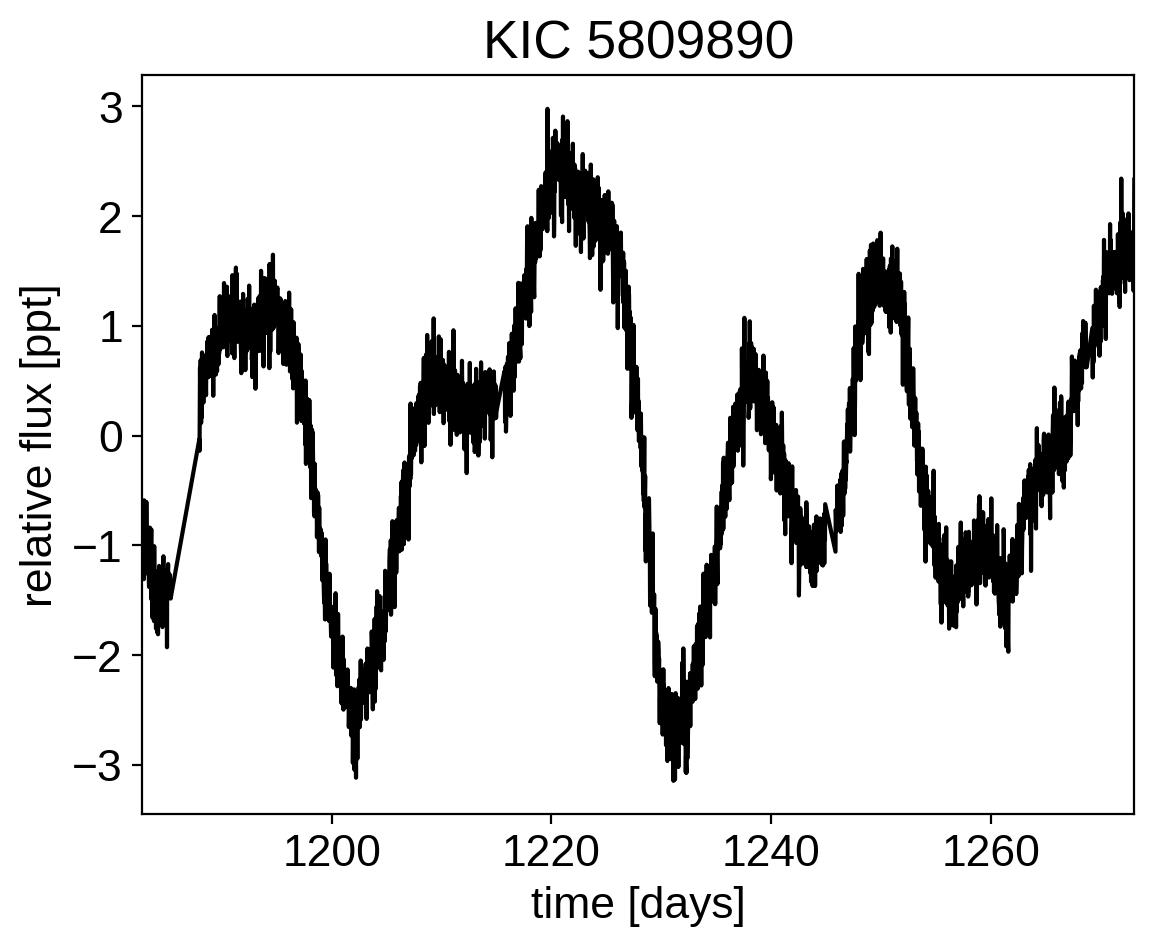

In [3]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt

lcf = lk.search_lightcurvefile("KIC 5809890", quarter=13).download(
    quality_bitmask="hardest"
)
lc = lcf.PDCSAP_FLUX.normalize().remove_nans().remove_outliers()

x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray(lc.flux, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err, dtype=np.float64)
mu = np.mean(y)
y = (y / mu - 1) * 1e3
yerr = yerr * 1e3 / mu

plt.plot(x, y, "k")
plt.xlim(x.min(), x.max())
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("KIC 5809890");

## A Gaussian process model for stellar variability

This looks like the light curve of a rotating star, and [it has been shown](https://arxiv.org/abs/1706.05459) that it is possible to model this variability by using a quasiperiodic Gaussian process.
To start with, let's get an estimate of the rotation period using the Lomb-Scargle periodogram:

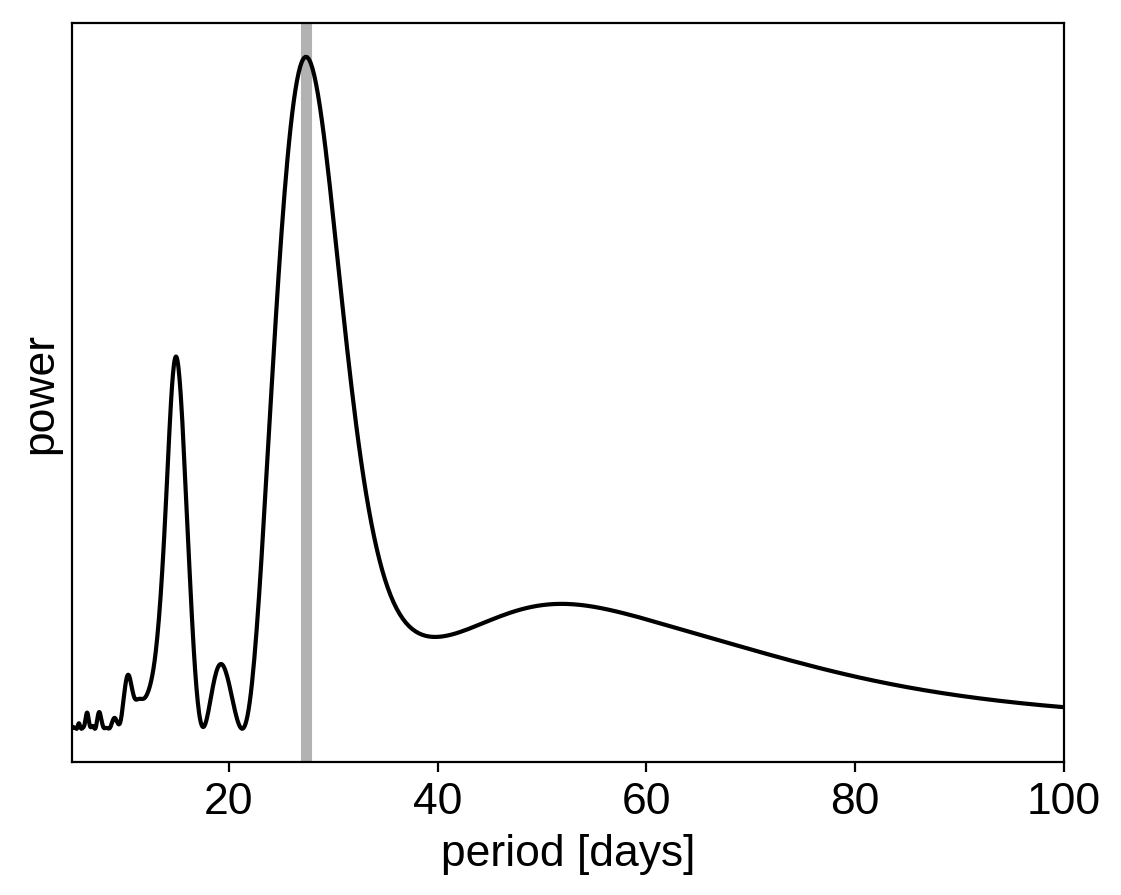

In [4]:
import exoplanet as xo

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=5.0, max_period=100.0, samples_per_peak=50
)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(1 / freq, power, "k")
plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
plt.xlim((1 / freq).min(), (1 / freq).max())
plt.yticks([])
plt.xlabel("period [days]")
plt.ylabel("power");

Now, using this initialization, we can set up the GP model in *exoplanet*.
We'll use the :class:`exoplanet.gp.terms.RotationTerm` kernel that is a mixture of two simple harmonic oscillators with periods separated by a factor of two.
As you can see from the periodogram above, this might be a good model for this light curve and I've found that it works well in many cases.

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:

    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sd=10.0)

    # A jitter term describing excess white noise
    logs2 = pm.Normal("logs2", mu=2 * np.log(np.mean(yerr)), sd=2.0)

    # A term to describe the non-periodic variability
    logSw4 = pm.Normal("logSw4", mu=np.log(np.var(y)), sd=5.0)
    logw0 = pm.Normal("logw0", mu=np.log(2 * np.pi / 10), sd=5.0)

    # The parameters of the RotationTerm kernel
    logamp = pm.Normal("logamp", mu=np.log(np.var(y)), sd=5.0)
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0, upper=np.log(50))
    logperiod = BoundedNormal("logperiod", mu=np.log(peak["period"]), sd=5.0)
    logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
    logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
    mix = xo.distributions.UnitUniform("mix")

    # Track the period as a deterministic
    period = pm.Deterministic("period", tt.exp(logperiod))

    # Set up the Gaussian Process model
    kernel = xo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, Q=1 / np.sqrt(2))
    kernel += xo.gp.terms.RotationTerm(
        log_amp=logamp, period=period, log_Q0=logQ0, log_deltaQ=logdeltaQ, mix=mix
    )
    gp = xo.gp.GP(kernel, x, yerr ** 2 + tt.exp(logs2))

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    pm.Potential("loglike", gp.log_likelihood(y - mean))

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict())

    # Optimize to find the maximum a posteriori parameters
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.672569e+02]

1it [00:00, 63.56it/s, logp=2.672569e+02]

2it [00:00, 94.61it/s, logp=2.672569e+02]

3it [00:00, 110.05it/s, logp=5.136323e+02]

4it [00:00, 118.29it/s, logp=1.156425e+02]

5it [00:00, 126.67it/s, logp=5.979256e+02]

6it [00:00, 132.27it/s, logp=5.714984e+02]

7it [00:00, 137.07it/s, logp=6.326147e+02]

8it [00:00, 140.23it/s, logp=6.068474e+02]

9it [00:00, 143.54it/s, logp=6.417452e+02]

10it [00:00, 146.32it/s, logp=6.581322e+02]

11it [00:00, 148.46it/s, logp=6.674794e+02]

12it [00:00, 150.44it/s, logp=6.613014e+02]

13it [00:00, 152.57it/s, logp=6.757355e+02]

14it [00:00, 154.30it/s, logp=6.789136e+02]

15it [00:00, 155.62it/s, logp=6.838594e+02]

16it [00:00, 156.68it/s, logp=6.861378e+02]

17it [00:00, 165.14it/s, logp=6.861378e+02]

17it [00:00, 165.14it/s, logp=6.865861e+02]

18it [00:00, 165.14it/s, logp=6.871456e+02]

19it [00:00, 165.14it/s, logp=6.876705e+02]

20it [00:00, 165.14it/s, logp=6.876475e+02]

21it [00:00, 165.14it/s, logp=6.878897e+02]

22it [00:00, 165.14it/s, logp=6.881082e+02]

23it [00:00, 165.14it/s, logp=6.885047e+02]

24it [00:00, 165.14it/s, logp=6.891367e+02]

25it [00:00, 165.14it/s, logp=6.901976e+02]

26it [00:00, 165.14it/s, logp=6.909579e+02]

27it [00:00, 165.14it/s, logp=6.916029e+02]

28it [00:00, 165.14it/s, logp=6.920778e+02]

29it [00:00, 165.14it/s, logp=6.924232e+02]

30it [00:00, 165.14it/s, logp=6.931738e+02]

31it [00:00, 165.14it/s, logp=6.904344e+02]

32it [00:00, 165.14it/s, logp=6.938591e+02]

33it [00:00, 165.14it/s, logp=6.905932e+02]

34it [00:00, 165.14it/s, logp=6.946126e+02]

35it [00:00, 168.71it/s, logp=6.946126e+02]

35it [00:00, 168.71it/s, logp=6.956241e+02]

36it [00:00, 168.71it/s, logp=6.968903e+02]

37it [00:00, 168.71it/s, logp=6.985163e+02]

38it [00:00, 168.71it/s, logp=6.996495e+02]

39it [00:00, 168.71it/s, logp=6.999613e+02]

40it [00:00, 168.71it/s, logp=7.002774e+02]

41it [00:00, 168.71it/s, logp=7.005226e+02]

42it [00:00, 168.71it/s, logp=7.006902e+02]

43it [00:00, 168.71it/s, logp=7.009343e+02]

44it [00:00, 168.71it/s, logp=7.010994e+02]

45it [00:00, 168.71it/s, logp=7.012373e+02]

46it [00:00, 168.71it/s, logp=7.013984e+02]

47it [00:00, 168.71it/s, logp=7.014793e+02]

48it [00:00, 168.71it/s, logp=7.015101e+02]

49it [00:00, 168.71it/s, logp=7.015674e+02]

50it [00:00, 168.71it/s, logp=7.016709e+02]

51it [00:00, 168.71it/s, logp=7.018427e+02]

52it [00:00, 168.71it/s, logp=7.020861e+02]

53it [00:00, 171.74it/s, logp=7.020861e+02]

53it [00:00, 171.74it/s, logp=7.023415e+02]

54it [00:00, 171.74it/s, logp=7.026723e+02]

55it [00:00, 171.74it/s, logp=7.025339e+02]

56it [00:00, 171.74it/s, logp=7.014986e+02]

57it [00:00, 171.74it/s, logp=7.026330e+02]

58it [00:00, 171.74it/s, logp=7.020678e+02]

59it [00:00, 171.74it/s, logp=7.026833e+02]

60it [00:00, 171.74it/s, logp=7.026669e+02]

61it [00:00, 171.74it/s, logp=7.027172e+02]

62it [00:00, 171.74it/s, logp=7.027824e+02]

63it [00:00, 171.74it/s, logp=7.029731e+02]

64it [00:00, 171.74it/s, logp=7.029217e+02]

65it [00:00, 171.74it/s, logp=7.030916e+02]

66it [00:00, 171.74it/s, logp=7.031036e+02]

67it [00:00, 171.74it/s, logp=7.031254e+02]

68it [00:00, 171.74it/s, logp=7.031583e+02]

69it [00:00, 171.74it/s, logp=7.031682e+02]

70it [00:00, 171.74it/s, logp=7.031690e+02]

71it [00:00, 171.74it/s, logp=7.031699e+02]

72it [00:00, 175.15it/s, logp=7.031699e+02]

72it [00:00, 175.15it/s, logp=7.031712e+02]

73it [00:00, 175.15it/s, logp=7.031722e+02]

74it [00:00, 175.15it/s, logp=7.031724e+02]

75it [00:00, 175.15it/s, logp=7.031724e+02]

76it [00:00, 175.15it/s, logp=7.031724e+02]

77it [00:00, 175.15it/s, logp=7.031724e+02]

78it [00:00, 175.15it/s, logp=7.031724e+02]

79it [00:00, 175.15it/s, logp=7.031724e+02]

80it [00:00, 175.15it/s, logp=7.031724e+02]

81it [00:00, 175.15it/s, logp=7.031724e+02]

82it [00:00, 175.15it/s, logp=7.031724e+02]

83it [00:00, 175.15it/s, logp=7.031724e+02]

84it [00:00, 175.15it/s, logp=7.031724e+02]

85it [00:00, 175.15it/s, logp=7.031724e+02]

86it [00:00, 156.26it/s, logp=7.031724e+02]

86it [00:00, 156.26it/s, logp=7.031724e+02]

87it [00:00, 156.26it/s, logp=7.031724e+02]

88it [00:00, 156.26it/s, logp=7.031724e+02]

89it [00:00, 156.26it/s, logp=7.031724e+02]

90it [00:00, 156.26it/s, logp=7.031724e+02]

91it [00:00, 156.26it/s, logp=7.031724e+02]

92it [00:00, 156.26it/s, logp=7.031724e+02]

93it [00:00, 156.26it/s, logp=7.031724e+02]

94it [00:00, 156.26it/s, logp=7.031724e+02]

95it [00:00, 156.26it/s, logp=7.031724e+02]

96it [00:00, 156.26it/s, logp=7.031724e+02]

97it [00:00, 156.26it/s, logp=7.031724e+02]

98it [00:00, 156.26it/s, logp=7.031724e+02]

99it [00:00, 156.26it/s, logp=7.031724e+02]

100it [00:00, 156.26it/s, logp=7.031724e+02]

101it [00:00, 156.26it/s, logp=7.031724e+02]

102it [00:00, 156.26it/s, logp=7.031724e+02]

103it [00:00, 156.26it/s, logp=7.031724e+02]

104it [00:00, 156.26it/s, logp=7.031724e+02]

105it [00:00, 164.00it/s, logp=7.031724e+02]

105it [00:00, 164.00it/s, logp=7.031724e+02]

106it [00:00, 164.00it/s, logp=7.031724e+02]

107it [00:00, 164.00it/s, logp=7.031724e+02]

108it [00:00, 164.00it/s, logp=7.031724e+02]

109it [00:00, 164.00it/s, logp=7.031724e+02]

110it [00:00, 164.00it/s, logp=7.031724e+02]

111it [00:00, 164.00it/s, logp=7.031724e+02]

112it [00:00, 164.00it/s, logp=7.031724e+02]

113it [00:00, 164.00it/s, logp=7.031724e+02]

114it [00:00, 164.00it/s, logp=7.031724e+02]

115it [00:00, 164.00it/s, logp=7.031724e+02]

116it [00:00, 164.00it/s, logp=7.031724e+02]

117it [00:00, 164.00it/s, logp=7.031724e+02]

118it [00:00, 164.00it/s, logp=7.031724e+02]

119it [00:00, 164.00it/s, logp=7.031724e+02]

120it [00:00, 164.00it/s, logp=7.031724e+02]

121it [00:00, 164.00it/s, logp=7.031724e+02]

122it [00:00, 164.00it/s, logp=7.031724e+02]

123it [00:00, 164.00it/s, logp=7.031724e+02]

124it [00:00, 169.99it/s, logp=7.031724e+02]

124it [00:00, 169.99it/s, logp=7.031724e+02]

125it [00:00, 169.99it/s, logp=7.031724e+02]

126it [00:00, 169.99it/s, logp=7.031724e+02]

127it [00:00, 169.99it/s, logp=7.031724e+02]

128it [00:00, 169.99it/s, logp=7.031724e+02]

129it [00:00, 169.99it/s, logp=7.031724e+02]

130it [00:00, 169.99it/s, logp=7.031724e+02]

131it [00:00, 169.99it/s, logp=7.031724e+02]

132it [00:00, 169.99it/s, logp=7.031724e+02]

133it [00:00, 169.99it/s, logp=7.031724e+02]

134it [00:00, 169.99it/s, logp=7.031724e+02]

135it [00:00, 169.99it/s, logp=7.031724e+02]

136it [00:00, 169.99it/s, logp=7.031724e+02]

137it [00:00, 169.99it/s, logp=7.031724e+02]

138it [00:00, 169.99it/s, logp=7.031724e+02]

139it [00:00, 169.99it/s, logp=7.031724e+02]

140it [00:00, 169.99it/s, logp=7.031724e+02]

141it [00:00, 169.99it/s, logp=7.031724e+02]

142it [00:00, 169.99it/s, logp=7.031724e+02]

143it [00:00, 173.30it/s, logp=7.031724e+02]

143it [00:00, 173.30it/s, logp=7.031724e+02]

144it [00:00, 173.30it/s, logp=7.031724e+02]

145it [00:00, 173.30it/s, logp=7.031724e+02]

146it [00:00, 173.30it/s, logp=7.031724e+02]

147it [00:00, 173.30it/s, logp=7.031724e+02]

148it [00:00, 173.30it/s, logp=7.031724e+02]

149it [00:00, 173.30it/s, logp=7.031724e+02]

150it [00:00, 173.30it/s, logp=7.031724e+02]

151it [00:00, 173.30it/s, logp=7.031724e+02]

152it [00:00, 173.30it/s, logp=7.031724e+02]

153it [00:00, 173.30it/s, logp=7.031724e+02]

154it [00:00, 173.30it/s, logp=7.031724e+02]

155it [00:00, 173.30it/s, logp=7.031724e+02]

156it [00:00, 173.30it/s, logp=7.031724e+02]

157it [00:00, 173.30it/s, logp=7.031724e+02]

158it [00:00, 173.30it/s, logp=7.031724e+02]

159it [00:00, 173.30it/s, logp=7.031724e+02]

160it [00:00, 156.65it/s, logp=7.031724e+02]

160it [00:00, 156.65it/s, logp=7.031724e+02]

161it [00:00, 156.65it/s, logp=7.031724e+02]

162it [00:00, 156.65it/s, logp=7.031724e+02]

163it [00:12, 13.35it/s, logp=7.031724e+02] 


message: Desired error not necessarily achieved due to precision loss.
logp: 267.25686032200514 -> 703.1723809089232


Now that we have the model set up, let's plot the maximum a posteriori model prediction.

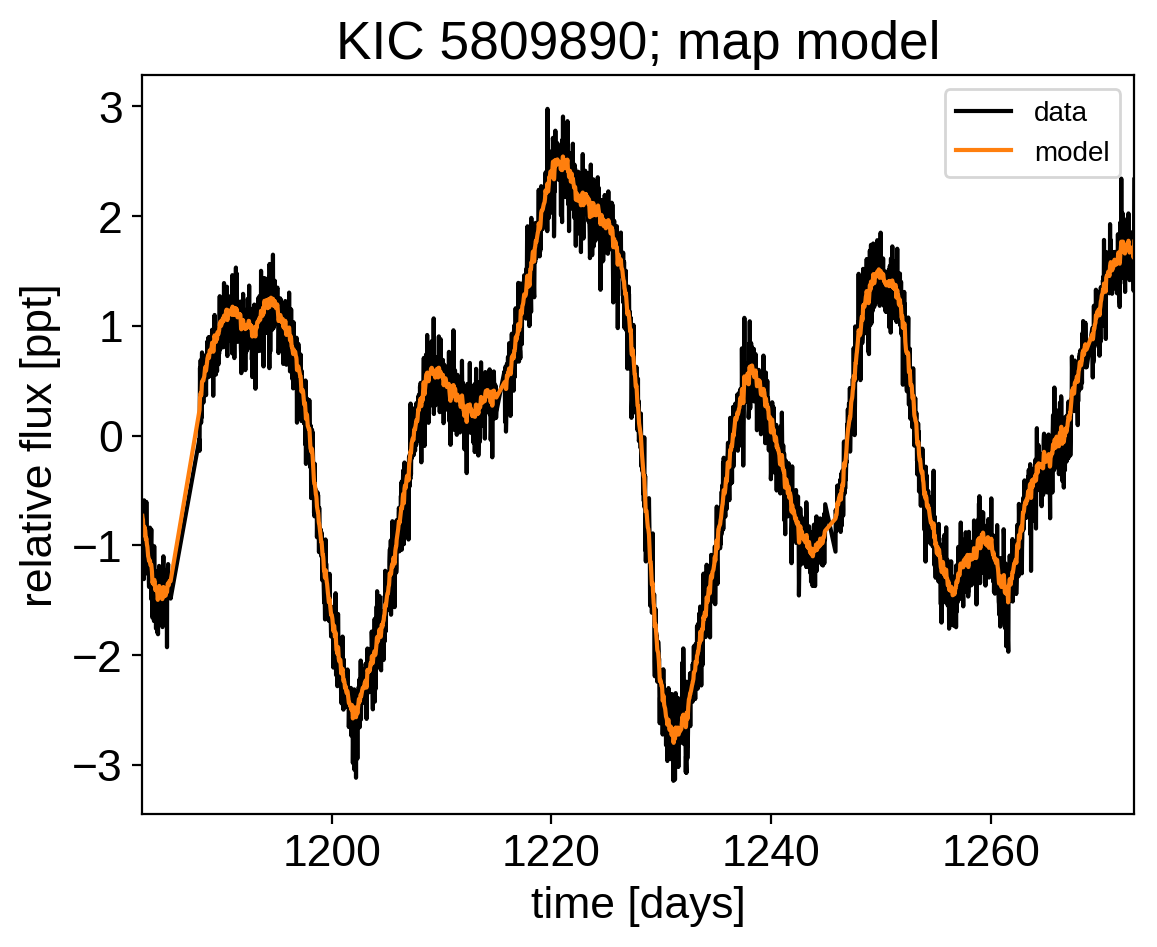

In [6]:
plt.plot(x, y, "k", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("KIC 5809890; map model");

That looks pretty good!
Now let's sample from the posterior using :func:`exoplanet.get_dense_nuts_step`.

In [7]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=2000,
        draws=2000,
        start=map_soln,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]


Sampling 4 chains:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 8/16000 [00:00<03:39, 72.87draws/s]

Sampling 4 chains:   0%|          | 11/16000 [00:01<27:45,  9.60draws/s]

Sampling 4 chains:   0%|          | 13/16000 [00:01<29:49,  8.93draws/s]

Sampling 4 chains:   0%|          | 15/16000 [00:01<30:29,  8.74draws/s]

Sampling 4 chains:   0%|          | 17/16000 [00:02<43:43,  6.09draws/s]

Sampling 4 chains:   0%|          | 19/16000 [00:02<39:35,  6.73draws/s]

Sampling 4 chains:   0%|          | 20/16000 [00:02<44:42,  5.96draws/s]

Sampling 4 chains:   0%|          | 21/16000 [00:02<57:41,  4.62draws/s]

Sampling 4 chains:   0%|          | 22/16000 [00:03<53:10,  5.01draws/s]

Sampling 4 chains:   0%|          | 23/16000 [00:03<45:42,  5.83draws/s]

Sampling 4 chains:   0%|          | 24/16000 [00:03<49:23,  5.39draws/s]

Sampling 4 chains:   0%|          | 25/16000 [00:03<48:42,  5.47draws/s]

Sampling 4 chains:   0%|          | 26/16000 [00:03<1:01:10,  4.35draws/s]

Sampling 4 chains:   0%|          | 28/16000 [00:04<49:21,  5.39draws/s]  

Sampling 4 chains:   0%|          | 29/16000 [00:04<47:59,  5.55draws/s]

Sampling 4 chains:   0%|          | 30/16000 [00:04<49:59,  5.32draws/s]

Sampling 4 chains:   0%|          | 31/16000 [00:04<1:00:48,  4.38draws/s]

Sampling 4 chains:   0%|          | 32/16000 [00:04<53:37,  4.96draws/s]  

Sampling 4 chains:   0%|          | 34/16000 [00:05<47:37,  5.59draws/s]

Sampling 4 chains:   0%|          | 35/16000 [00:05<43:27,  6.12draws/s]

Sampling 4 chains:   0%|          | 37/16000 [00:05<45:20,  5.87draws/s]

Sampling 4 chains:   0%|          | 40/16000 [00:05<36:11,  7.35draws/s]

Sampling 4 chains:   0%|          | 41/16000 [00:06<45:25,  5.85draws/s]

Sampling 4 chains:   0%|          | 42/16000 [00:06<1:01:39,  4.31draws/s]

Sampling 4 chains:   0%|          | 43/16000 [00:06<1:00:22,  4.41draws/s]

Sampling 4 chains:   0%|          | 46/16000 [00:06<46:34,  5.71draws/s]  

Sampling 4 chains:   0%|          | 48/16000 [00:06<37:46,  7.04draws/s]

Sampling 4 chains:   0%|          | 50/16000 [00:07<44:49,  5.93draws/s]

Sampling 4 chains:   0%|          | 51/16000 [00:07<52:44,  5.04draws/s]

Sampling 4 chains:   0%|          | 53/16000 [00:07<42:41,  6.22draws/s]

Sampling 4 chains:   0%|          | 54/16000 [00:07<39:40,  6.70draws/s]

Sampling 4 chains:   0%|          | 56/16000 [00:08<33:19,  7.97draws/s]

Sampling 4 chains:   0%|          | 58/16000 [00:08<43:37,  6.09draws/s]

Sampling 4 chains:   0%|          | 60/16000 [00:08<34:44,  7.65draws/s]

Sampling 4 chains:   0%|          | 62/16000 [00:08<34:05,  7.79draws/s]

Sampling 4 chains:   0%|          | 64/16000 [00:09<53:45,  4.94draws/s]

Sampling 4 chains:   0%|          | 66/16000 [00:09<42:33,  6.24draws/s]

Sampling 4 chains:   0%|          | 68/16000 [00:09<35:38,  7.45draws/s]

Sampling 4 chains:   0%|          | 70/16000 [00:10<38:54,  6.82draws/s]

Sampling 4 chains:   0%|          | 71/16000 [00:10<1:02:39,  4.24draws/s]

Sampling 4 chains:   0%|          | 72/16000 [00:10<59:07,  4.49draws/s]  

Sampling 4 chains:   0%|          | 74/16000 [00:11<45:45,  5.80draws/s]

Sampling 4 chains:   0%|          | 76/16000 [00:11<50:48,  5.22draws/s]

Sampling 4 chains:   0%|          | 77/16000 [00:11<1:06:16,  4.00draws/s]

Sampling 4 chains:   0%|          | 79/16000 [00:12<51:44,  5.13draws/s]  

Sampling 4 chains:   0%|          | 80/16000 [00:12<47:03,  5.64draws/s]

Sampling 4 chains:   1%|          | 81/16000 [00:12<52:11,  5.08draws/s]

Sampling 4 chains:   1%|          | 83/16000 [00:12<47:45,  5.55draws/s]

Sampling 4 chains:   1%|          | 85/16000 [00:12<43:18,  6.13draws/s]

Sampling 4 chains:   1%|          | 86/16000 [00:13<40:35,  6.53draws/s]

Sampling 4 chains:   1%|          | 87/16000 [00:13<57:37,  4.60draws/s]

Sampling 4 chains:   1%|          | 88/16000 [00:13<1:01:42,  4.30draws/s]

Sampling 4 chains:   1%|          | 92/16000 [00:13<48:17,  5.49draws/s]  

Sampling 4 chains:   1%|          | 93/16000 [00:14<44:17,  5.99draws/s]

Sampling 4 chains:   1%|          | 94/16000 [00:14<1:00:31,  4.38draws/s]

Sampling 4 chains:   1%|          | 95/16000 [00:14<54:12,  4.89draws/s]  

Sampling 4 chains:   1%|          | 96/16000 [00:14<48:09,  5.50draws/s]

Sampling 4 chains:   1%|          | 97/16000 [00:14<51:33,  5.14draws/s]

Sampling 4 chains:   1%|          | 99/16000 [00:15<42:02,  6.30draws/s]

Sampling 4 chains:   1%|          | 100/16000 [00:15<39:57,  6.63draws/s]

Sampling 4 chains:   1%|          | 101/16000 [00:15<37:18,  7.10draws/s]

Sampling 4 chains:   1%|          | 102/16000 [00:15<46:19,  5.72draws/s]

Sampling 4 chains:   1%|          | 103/16000 [00:15<42:47,  6.19draws/s]

Sampling 4 chains:   1%|          | 105/16000 [00:15<35:01,  7.57draws/s]

Sampling 4 chains:   1%|          | 106/16000 [00:16<34:37,  7.65draws/s]

Sampling 4 chains:   1%|          | 108/16000 [00:16<44:07,  6.00draws/s]

Sampling 4 chains:   1%|          | 110/16000 [00:16<37:53,  6.99draws/s]

Sampling 4 chains:   1%|          | 111/16000 [00:17<53:54,  4.91draws/s]

Sampling 4 chains:   1%|          | 113/16000 [00:17<43:58,  6.02draws/s]

Sampling 4 chains:   1%|          | 114/16000 [00:17<1:00:17,  4.39draws/s]

Sampling 4 chains:   1%|          | 116/16000 [00:17<52:26,  5.05draws/s]  

Sampling 4 chains:   1%|          | 117/16000 [00:18<56:46,  4.66draws/s]

Sampling 4 chains:   1%|          | 119/16000 [00:18<46:19,  5.71draws/s]

Sampling 4 chains:   1%|          | 122/16000 [00:18<41:42,  6.34draws/s]

Sampling 4 chains:   1%|          | 123/16000 [00:18<49:12,  5.38draws/s]

Sampling 4 chains:   1%|          | 124/16000 [00:19<49:36,  5.33draws/s]

Sampling 4 chains:   1%|          | 126/16000 [00:19<43:54,  6.03draws/s]

Sampling 4 chains:   1%|          | 128/16000 [00:19<36:40,  7.21draws/s]

Sampling 4 chains:   1%|          | 129/16000 [00:19<35:12,  7.51draws/s]

Sampling 4 chains:   1%|          | 131/16000 [00:19<34:03,  7.77draws/s]

Sampling 4 chains:   1%|          | 133/16000 [00:20<34:20,  7.70draws/s]

Sampling 4 chains:   1%|          | 135/16000 [00:20<29:58,  8.82draws/s]

Sampling 4 chains:   1%|          | 136/16000 [00:20<31:15,  8.46draws/s]

Sampling 4 chains:   1%|          | 138/16000 [00:20<31:57,  8.27draws/s]

Sampling 4 chains:   1%|          | 139/16000 [00:20<40:10,  6.58draws/s]

Sampling 4 chains:   1%|          | 141/16000 [00:21<40:23,  6.55draws/s]

Sampling 4 chains:   1%|          | 142/16000 [00:21<36:37,  7.22draws/s]

Sampling 4 chains:   1%|          | 143/16000 [00:21<36:20,  7.27draws/s]

Sampling 4 chains:   1%|          | 144/16000 [00:21<46:58,  5.63draws/s]

Sampling 4 chains:   1%|          | 145/16000 [00:21<41:25,  6.38draws/s]

Sampling 4 chains:   1%|          | 148/16000 [00:22<39:39,  6.66draws/s]

Sampling 4 chains:   1%|          | 149/16000 [00:22<46:16,  5.71draws/s]

Sampling 4 chains:   1%|          | 150/16000 [00:22<54:58,  4.81draws/s]

Sampling 4 chains:   1%|          | 151/16000 [00:22<49:02,  5.39draws/s]

Sampling 4 chains:   1%|          | 153/16000 [00:23<48:06,  5.49draws/s]

Sampling 4 chains:   1%|          | 155/16000 [00:23<55:23,  4.77draws/s]

Sampling 4 chains:   1%|          | 157/16000 [00:23<43:34,  6.06draws/s]

Sampling 4 chains:   1%|          | 159/16000 [00:24<41:08,  6.42draws/s]

Sampling 4 chains:   1%|          | 161/16000 [00:24<38:20,  6.89draws/s]

Sampling 4 chains:   1%|          | 163/16000 [00:24<35:57,  7.34draws/s]

Sampling 4 chains:   1%|          | 165/16000 [00:24<36:04,  7.32draws/s]

Sampling 4 chains:   1%|          | 166/16000 [00:25<44:25,  5.94draws/s]

Sampling 4 chains:   1%|          | 167/16000 [00:25<44:10,  5.97draws/s]

Sampling 4 chains:   1%|          | 168/16000 [00:25<39:22,  6.70draws/s]

Sampling 4 chains:   1%|          | 169/16000 [00:25<47:08,  5.60draws/s]

Sampling 4 chains:   1%|          | 172/16000 [00:25<37:03,  7.12draws/s]

Sampling 4 chains:   1%|          | 174/16000 [00:25<30:09,  8.75draws/s]

Sampling 4 chains:   1%|          | 176/16000 [00:25<27:04,  9.74draws/s]

Sampling 4 chains:   1%|          | 178/16000 [00:26<32:25,  8.13draws/s]

Sampling 4 chains:   1%|          | 182/16000 [00:26<27:40,  9.53draws/s]

Sampling 4 chains:   1%|          | 184/16000 [00:27<39:11,  6.73draws/s]

Sampling 4 chains:   1%|          | 187/16000 [00:27<34:50,  7.56draws/s]

Sampling 4 chains:   1%|          | 189/16000 [00:27<33:30,  7.86draws/s]

Sampling 4 chains:   1%|          | 191/16000 [00:27<31:19,  8.41draws/s]

Sampling 4 chains:   1%|          | 193/16000 [00:28<33:07,  7.95draws/s]

Sampling 4 chains:   1%|          | 195/16000 [00:28<33:44,  7.81draws/s]

Sampling 4 chains:   1%|          | 198/16000 [00:28<26:38,  9.88draws/s]

Sampling 4 chains:   1%|▏         | 200/16000 [00:28<38:51,  6.78draws/s]

Sampling 4 chains:   1%|▏         | 202/16000 [00:29<38:16,  6.88draws/s]

Sampling 4 chains:   1%|▏         | 203/16000 [00:29<34:54,  7.54draws/s]

Sampling 4 chains:   1%|▏         | 205/16000 [00:29<30:28,  8.64draws/s]

Sampling 4 chains:   1%|▏         | 207/16000 [00:29<26:19, 10.00draws/s]

Sampling 4 chains:   1%|▏         | 209/16000 [00:29<28:43,  9.16draws/s]

Sampling 4 chains:   1%|▏         | 211/16000 [00:30<28:08,  9.35draws/s]

Sampling 4 chains:   1%|▏         | 213/16000 [00:30<26:43,  9.85draws/s]

Sampling 4 chains:   1%|▏         | 215/16000 [00:30<31:32,  8.34draws/s]

Sampling 4 chains:   1%|▏         | 217/16000 [00:30<29:24,  8.95draws/s]

Sampling 4 chains:   1%|▏         | 220/16000 [00:30<25:34, 10.28draws/s]

Sampling 4 chains:   1%|▏         | 222/16000 [00:31<25:24, 10.35draws/s]

Sampling 4 chains:   1%|▏         | 224/16000 [00:31<27:09,  9.68draws/s]

Sampling 4 chains:   1%|▏         | 227/16000 [00:31<28:14,  9.31draws/s]

Sampling 4 chains:   1%|▏         | 228/16000 [00:31<28:45,  9.14draws/s]

Sampling 4 chains:   1%|▏         | 231/16000 [00:32<23:24, 11.23draws/s]

Sampling 4 chains:   1%|▏         | 233/16000 [00:32<21:24, 12.27draws/s]

Sampling 4 chains:   1%|▏         | 235/16000 [00:32<27:32,  9.54draws/s]

Sampling 4 chains:   1%|▏         | 237/16000 [00:32<39:31,  6.65draws/s]

Sampling 4 chains:   1%|▏         | 239/16000 [00:33<37:36,  6.99draws/s]

Sampling 4 chains:   2%|▏         | 241/16000 [00:33<31:08,  8.43draws/s]

Sampling 4 chains:   2%|▏         | 243/16000 [00:33<27:26,  9.57draws/s]

Sampling 4 chains:   2%|▏         | 245/16000 [00:33<29:20,  8.95draws/s]

Sampling 4 chains:   2%|▏         | 248/16000 [00:33<23:35, 11.12draws/s]

Sampling 4 chains:   2%|▏         | 250/16000 [00:34<32:32,  8.07draws/s]

Sampling 4 chains:   2%|▏         | 254/16000 [00:34<26:52,  9.77draws/s]

Sampling 4 chains:   2%|▏         | 256/16000 [00:34<24:30, 10.71draws/s]

Sampling 4 chains:   2%|▏         | 258/16000 [00:34<26:30,  9.90draws/s]

Sampling 4 chains:   2%|▏         | 260/16000 [00:35<25:39, 10.23draws/s]

Sampling 4 chains:   2%|▏         | 262/16000 [00:35<26:09, 10.03draws/s]

Sampling 4 chains:   2%|▏         | 264/16000 [00:35<28:42,  9.13draws/s]

Sampling 4 chains:   2%|▏         | 267/16000 [00:35<23:42, 11.06draws/s]

Sampling 4 chains:   2%|▏         | 269/16000 [00:35<23:14, 11.28draws/s]

Sampling 4 chains:   2%|▏         | 271/16000 [00:36<26:47,  9.78draws/s]

Sampling 4 chains:   2%|▏         | 273/16000 [00:36<29:09,  8.99draws/s]

Sampling 4 chains:   2%|▏         | 275/16000 [00:36<29:13,  8.97draws/s]

Sampling 4 chains:   2%|▏         | 277/16000 [00:36<24:57, 10.50draws/s]

Sampling 4 chains:   2%|▏         | 279/16000 [00:36<26:24,  9.92draws/s]

Sampling 4 chains:   2%|▏         | 281/16000 [00:37<25:46, 10.16draws/s]

Sampling 4 chains:   2%|▏         | 283/16000 [00:37<32:19,  8.10draws/s]

Sampling 4 chains:   2%|▏         | 285/16000 [00:37<27:18,  9.59draws/s]

Sampling 4 chains:   2%|▏         | 287/16000 [00:37<24:39, 10.62draws/s]

Sampling 4 chains:   2%|▏         | 290/16000 [00:37<21:29, 12.18draws/s]

Sampling 4 chains:   2%|▏         | 292/16000 [00:38<24:23, 10.74draws/s]

Sampling 4 chains:   2%|▏         | 295/16000 [00:38<19:53, 13.16draws/s]

Sampling 4 chains:   2%|▏         | 297/16000 [00:38<25:36, 10.22draws/s]

Sampling 4 chains:   2%|▏         | 299/16000 [00:38<26:21,  9.93draws/s]

Sampling 4 chains:   2%|▏         | 301/16000 [00:39<35:57,  7.28draws/s]

Sampling 4 chains:   2%|▏         | 303/16000 [00:39<29:23,  8.90draws/s]

Sampling 4 chains:   2%|▏         | 305/16000 [00:39<33:51,  7.73draws/s]

Sampling 4 chains:   2%|▏         | 307/16000 [00:39<30:32,  8.56draws/s]

Sampling 4 chains:   2%|▏         | 309/16000 [00:39<28:43,  9.10draws/s]

Sampling 4 chains:   2%|▏         | 311/16000 [00:40<31:14,  8.37draws/s]

Sampling 4 chains:   2%|▏         | 312/16000 [00:40<31:45,  8.23draws/s]

Sampling 4 chains:   2%|▏         | 313/16000 [00:40<32:27,  8.06draws/s]

Sampling 4 chains:   2%|▏         | 314/16000 [00:40<40:56,  6.39draws/s]

Sampling 4 chains:   2%|▏         | 315/16000 [00:40<36:52,  7.09draws/s]

Sampling 4 chains:   2%|▏         | 317/16000 [00:41<37:42,  6.93draws/s]

Sampling 4 chains:   2%|▏         | 320/16000 [00:41<30:01,  8.70draws/s]

Sampling 4 chains:   2%|▏         | 322/16000 [00:41<28:25,  9.20draws/s]

Sampling 4 chains:   2%|▏         | 324/16000 [00:41<25:15, 10.34draws/s]

Sampling 4 chains:   2%|▏         | 326/16000 [00:41<25:09, 10.38draws/s]

Sampling 4 chains:   2%|▏         | 328/16000 [00:42<26:27,  9.87draws/s]

Sampling 4 chains:   2%|▏         | 330/16000 [00:42<27:23,  9.53draws/s]

Sampling 4 chains:   2%|▏         | 333/16000 [00:42<21:48, 11.97draws/s]

Sampling 4 chains:   2%|▏         | 335/16000 [00:42<21:40, 12.05draws/s]

Sampling 4 chains:   2%|▏         | 339/16000 [00:42<20:18, 12.86draws/s]

Sampling 4 chains:   2%|▏         | 342/16000 [00:42<17:53, 14.58draws/s]

Sampling 4 chains:   2%|▏         | 344/16000 [00:43<17:45, 14.69draws/s]

Sampling 4 chains:   2%|▏         | 346/16000 [00:43<16:38, 15.69draws/s]

Sampling 4 chains:   2%|▏         | 349/16000 [00:43<15:34, 16.75draws/s]

Sampling 4 chains:   2%|▏         | 351/16000 [00:43<16:31, 15.79draws/s]

Sampling 4 chains:   2%|▏         | 353/16000 [00:43<16:13, 16.07draws/s]

Sampling 4 chains:   2%|▏         | 355/16000 [00:43<16:45, 15.56draws/s]

Sampling 4 chains:   2%|▏         | 358/16000 [00:43<15:05, 17.28draws/s]

Sampling 4 chains:   2%|▏         | 361/16000 [00:44<13:55, 18.71draws/s]

Sampling 4 chains:   2%|▏         | 363/16000 [00:44<14:43, 17.70draws/s]

Sampling 4 chains:   2%|▏         | 366/16000 [00:44<14:33, 17.91draws/s]

Sampling 4 chains:   2%|▏         | 369/16000 [00:44<12:52, 20.24draws/s]

Sampling 4 chains:   2%|▏         | 372/16000 [00:44<13:09, 19.79draws/s]

Sampling 4 chains:   2%|▏         | 376/16000 [00:44<11:11, 23.26draws/s]

Sampling 4 chains:   2%|▏         | 379/16000 [00:44<14:21, 18.13draws/s]

Sampling 4 chains:   2%|▏         | 382/16000 [00:45<13:35, 19.14draws/s]

Sampling 4 chains:   2%|▏         | 385/16000 [00:45<16:16, 16.00draws/s]

Sampling 4 chains:   2%|▏         | 388/16000 [00:45<16:28, 15.80draws/s]

Sampling 4 chains:   2%|▏         | 390/16000 [00:45<16:39, 15.62draws/s]

Sampling 4 chains:   2%|▏         | 392/16000 [00:45<18:53, 13.77draws/s]

Sampling 4 chains:   2%|▏         | 397/16000 [00:45<15:02, 17.29draws/s]

Sampling 4 chains:   2%|▎         | 400/16000 [00:46<14:27, 17.99draws/s]

Sampling 4 chains:   3%|▎         | 403/16000 [00:46<14:23, 18.06draws/s]

Sampling 4 chains:   3%|▎         | 406/16000 [00:46<12:43, 20.42draws/s]

Sampling 4 chains:   3%|▎         | 410/16000 [00:46<14:28, 17.95draws/s]

Sampling 4 chains:   3%|▎         | 413/16000 [00:46<15:59, 16.24draws/s]

Sampling 4 chains:   3%|▎         | 416/16000 [00:47<14:44, 17.62draws/s]

Sampling 4 chains:   3%|▎         | 419/16000 [00:47<18:33, 13.99draws/s]

Sampling 4 chains:   3%|▎         | 423/16000 [00:47<15:36, 16.62draws/s]

Sampling 4 chains:   3%|▎         | 426/16000 [00:47<15:04, 17.21draws/s]

Sampling 4 chains:   3%|▎         | 428/16000 [00:47<15:30, 16.73draws/s]

Sampling 4 chains:   3%|▎         | 430/16000 [00:47<14:55, 17.38draws/s]

Sampling 4 chains:   3%|▎         | 434/16000 [00:48<15:30, 16.73draws/s]

Sampling 4 chains:   3%|▎         | 436/16000 [00:48<16:45, 15.47draws/s]

Sampling 4 chains:   3%|▎         | 438/16000 [00:48<16:43, 15.51draws/s]

Sampling 4 chains:   3%|▎         | 440/16000 [00:48<15:42, 16.50draws/s]

Sampling 4 chains:   3%|▎         | 442/16000 [00:48<15:57, 16.26draws/s]

Sampling 4 chains:   3%|▎         | 445/16000 [00:48<14:35, 17.76draws/s]

Sampling 4 chains:   3%|▎         | 447/16000 [00:48<15:12, 17.05draws/s]

Sampling 4 chains:   3%|▎         | 451/16000 [00:49<13:08, 19.73draws/s]

Sampling 4 chains:   3%|▎         | 454/16000 [00:49<12:29, 20.73draws/s]

Sampling 4 chains:   3%|▎         | 460/16000 [00:49<10:24, 24.88draws/s]

Sampling 4 chains:   3%|▎         | 464/16000 [00:49<09:48, 26.40draws/s]

Sampling 4 chains:   3%|▎         | 467/16000 [00:49<10:10, 25.43draws/s]

Sampling 4 chains:   3%|▎         | 470/16000 [00:49<10:34, 24.46draws/s]

Sampling 4 chains:   3%|▎         | 473/16000 [00:49<10:47, 23.97draws/s]

Sampling 4 chains:   3%|▎         | 476/16000 [00:49<11:11, 23.13draws/s]

Sampling 4 chains:   3%|▎         | 479/16000 [00:50<10:54, 23.72draws/s]

Sampling 4 chains:   3%|▎         | 482/16000 [00:50<10:57, 23.59draws/s]

Sampling 4 chains:   3%|▎         | 487/16000 [00:50<09:39, 26.79draws/s]

Sampling 4 chains:   3%|▎         | 490/16000 [00:50<10:16, 25.14draws/s]

Sampling 4 chains:   3%|▎         | 494/16000 [00:50<09:31, 27.15draws/s]

Sampling 4 chains:   3%|▎         | 497/16000 [00:50<09:36, 26.90draws/s]

Sampling 4 chains:   3%|▎         | 501/16000 [00:50<09:20, 27.67draws/s]

Sampling 4 chains:   3%|▎         | 504/16000 [00:50<09:46, 26.43draws/s]

Sampling 4 chains:   3%|▎         | 508/16000 [00:51<09:41, 26.63draws/s]

Sampling 4 chains:   3%|▎         | 511/16000 [00:51<09:53, 26.12draws/s]

Sampling 4 chains:   3%|▎         | 514/16000 [00:51<10:14, 25.20draws/s]

Sampling 4 chains:   3%|▎         | 517/16000 [00:51<10:44, 24.03draws/s]

Sampling 4 chains:   3%|▎         | 521/16000 [00:51<09:56, 25.95draws/s]

Sampling 4 chains:   3%|▎         | 525/16000 [00:51<09:31, 27.07draws/s]

Sampling 4 chains:   3%|▎         | 529/16000 [00:51<09:09, 28.14draws/s]

Sampling 4 chains:   3%|▎         | 532/16000 [00:51<09:18, 27.70draws/s]

Sampling 4 chains:   3%|▎         | 536/16000 [00:52<08:44, 29.47draws/s]

Sampling 4 chains:   3%|▎         | 540/16000 [00:52<09:32, 26.99draws/s]

Sampling 4 chains:   3%|▎         | 544/16000 [00:52<09:10, 28.07draws/s]

Sampling 4 chains:   3%|▎         | 548/16000 [00:52<08:35, 29.99draws/s]

Sampling 4 chains:   3%|▎         | 554/16000 [00:52<07:33, 34.04draws/s]

Sampling 4 chains:   3%|▎         | 559/16000 [00:52<07:28, 34.40draws/s]

Sampling 4 chains:   4%|▎         | 563/16000 [00:52<07:41, 33.47draws/s]

Sampling 4 chains:   4%|▎         | 568/16000 [00:53<07:25, 34.64draws/s]

Sampling 4 chains:   4%|▎         | 572/16000 [00:53<07:42, 33.37draws/s]

Sampling 4 chains:   4%|▎         | 576/16000 [00:53<07:53, 32.57draws/s]

Sampling 4 chains:   4%|▎         | 580/16000 [00:53<08:04, 31.83draws/s]

Sampling 4 chains:   4%|▎         | 585/16000 [00:53<07:27, 34.45draws/s]

Sampling 4 chains:   4%|▎         | 592/16000 [00:53<06:33, 39.18draws/s]

Sampling 4 chains:   4%|▎         | 597/16000 [00:53<06:44, 38.05draws/s]

Sampling 4 chains:   4%|▍         | 602/16000 [00:53<07:12, 35.61draws/s]

Sampling 4 chains:   4%|▍         | 606/16000 [00:54<07:46, 33.00draws/s]

Sampling 4 chains:   4%|▍         | 610/16000 [00:54<07:27, 34.36draws/s]

Sampling 4 chains:   4%|▍         | 614/16000 [00:54<08:11, 31.33draws/s]

Sampling 4 chains:   4%|▍         | 619/16000 [00:54<07:42, 33.27draws/s]

Sampling 4 chains:   4%|▍         | 624/16000 [00:54<07:24, 34.58draws/s]

Sampling 4 chains:   4%|▍         | 628/16000 [00:54<07:46, 32.97draws/s]

Sampling 4 chains:   4%|▍         | 632/16000 [00:54<08:34, 29.90draws/s]

Sampling 4 chains:   4%|▍         | 636/16000 [00:55<08:02, 31.86draws/s]

Sampling 4 chains:   4%|▍         | 642/16000 [00:55<07:20, 34.83draws/s]

Sampling 4 chains:   4%|▍         | 646/16000 [00:55<08:47, 29.08draws/s]

Sampling 4 chains:   4%|▍         | 650/16000 [00:55<10:42, 23.90draws/s]

Sampling 4 chains:   4%|▍         | 655/16000 [00:55<09:35, 26.67draws/s]

Sampling 4 chains:   4%|▍         | 661/16000 [00:55<08:24, 30.42draws/s]

Sampling 4 chains:   4%|▍         | 667/16000 [00:55<07:11, 35.53draws/s]

Sampling 4 chains:   4%|▍         | 672/16000 [00:56<07:38, 33.44draws/s]

Sampling 4 chains:   4%|▍         | 676/16000 [00:56<08:15, 30.92draws/s]

Sampling 4 chains:   4%|▍         | 680/16000 [00:56<08:21, 30.55draws/s]

Sampling 4 chains:   4%|▍         | 684/16000 [00:56<09:25, 27.07draws/s]

Sampling 4 chains:   4%|▍         | 688/16000 [00:56<09:01, 28.30draws/s]

Sampling 4 chains:   4%|▍         | 692/16000 [00:56<09:22, 27.19draws/s]

Sampling 4 chains:   4%|▍         | 695/16000 [00:57<09:58, 25.56draws/s]

Sampling 4 chains:   4%|▍         | 702/16000 [00:57<08:32, 29.87draws/s]

Sampling 4 chains:   4%|▍         | 707/16000 [00:57<08:13, 30.99draws/s]

Sampling 4 chains:   4%|▍         | 711/16000 [00:57<09:32, 26.70draws/s]

Sampling 4 chains:   4%|▍         | 716/16000 [00:57<08:39, 29.42draws/s]

Sampling 4 chains:   4%|▍         | 720/16000 [00:57<08:32, 29.82draws/s]

Sampling 4 chains:   5%|▍         | 725/16000 [00:57<07:59, 31.82draws/s]

Sampling 4 chains:   5%|▍         | 730/16000 [00:58<07:16, 34.98draws/s]

Sampling 4 chains:   5%|▍         | 734/16000 [00:58<07:51, 32.38draws/s]

Sampling 4 chains:   5%|▍         | 738/16000 [00:58<07:52, 32.30draws/s]

Sampling 4 chains:   5%|▍         | 743/16000 [00:58<07:30, 33.90draws/s]

Sampling 4 chains:   5%|▍         | 747/16000 [00:58<07:55, 32.06draws/s]

Sampling 4 chains:   5%|▍         | 751/16000 [00:58<09:06, 27.91draws/s]

Sampling 4 chains:   5%|▍         | 755/16000 [00:58<08:59, 28.27draws/s]

Sampling 4 chains:   5%|▍         | 759/16000 [00:59<08:52, 28.64draws/s]

Sampling 4 chains:   5%|▍         | 763/16000 [00:59<08:56, 28.37draws/s]

Sampling 4 chains:   5%|▍         | 767/16000 [00:59<08:46, 28.95draws/s]

Sampling 4 chains:   5%|▍         | 772/16000 [00:59<08:14, 30.81draws/s]

Sampling 4 chains:   5%|▍         | 776/16000 [00:59<08:20, 30.44draws/s]

Sampling 4 chains:   5%|▍         | 781/16000 [00:59<07:46, 32.63draws/s]

Sampling 4 chains:   5%|▍         | 786/16000 [00:59<07:01, 36.07draws/s]

Sampling 4 chains:   5%|▍         | 791/16000 [00:59<06:30, 38.92draws/s]

Sampling 4 chains:   5%|▍         | 797/16000 [00:59<05:51, 43.30draws/s]

Sampling 4 chains:   5%|▌         | 803/16000 [01:00<05:25, 46.63draws/s]

Sampling 4 chains:   5%|▌         | 808/16000 [01:00<05:28, 46.22draws/s]

Sampling 4 chains:   5%|▌         | 813/16000 [01:00<05:26, 46.58draws/s]

Sampling 4 chains:   5%|▌         | 818/16000 [01:00<06:37, 38.16draws/s]

Sampling 4 chains:   5%|▌         | 823/16000 [01:00<06:37, 38.21draws/s]

Sampling 4 chains:   5%|▌         | 828/16000 [01:00<06:21, 39.75draws/s]

Sampling 4 chains:   5%|▌         | 834/16000 [01:00<06:06, 41.39draws/s]

Sampling 4 chains:   5%|▌         | 839/16000 [01:01<07:08, 35.37draws/s]

Sampling 4 chains:   5%|▌         | 845/16000 [01:01<07:14, 34.91draws/s]

Sampling 4 chains:   5%|▌         | 849/16000 [01:01<07:31, 33.53draws/s]

Sampling 4 chains:   5%|▌         | 854/16000 [01:01<07:01, 35.92draws/s]

Sampling 4 chains:   5%|▌         | 858/16000 [01:01<07:35, 33.27draws/s]

Sampling 4 chains:   5%|▌         | 863/16000 [01:01<07:17, 34.59draws/s]

Sampling 4 chains:   5%|▌         | 867/16000 [01:01<07:00, 36.00draws/s]

Sampling 4 chains:   5%|▌         | 871/16000 [01:01<06:47, 37.08draws/s]

Sampling 4 chains:   5%|▌         | 876/16000 [01:02<06:44, 37.37draws/s]

Sampling 4 chains:   6%|▌         | 881/16000 [01:02<06:43, 37.47draws/s]

Sampling 4 chains:   6%|▌         | 885/16000 [01:02<07:12, 34.98draws/s]

Sampling 4 chains:   6%|▌         | 890/16000 [01:02<06:44, 37.39draws/s]

Sampling 4 chains:   6%|▌         | 896/16000 [01:02<06:22, 39.48draws/s]

Sampling 4 chains:   6%|▌         | 901/16000 [01:02<06:27, 38.94draws/s]

Sampling 4 chains:   6%|▌         | 907/16000 [01:02<05:48, 43.27draws/s]

Sampling 4 chains:   6%|▌         | 912/16000 [01:02<06:09, 40.80draws/s]

Sampling 4 chains:   6%|▌         | 918/16000 [01:03<05:34, 45.12draws/s]

Sampling 4 chains:   6%|▌         | 925/16000 [01:03<05:03, 49.71draws/s]

Sampling 4 chains:   6%|▌         | 931/16000 [01:03<05:03, 49.69draws/s]

Sampling 4 chains:   6%|▌         | 937/16000 [01:03<05:11, 48.34draws/s]

Sampling 4 chains:   6%|▌         | 945/16000 [01:03<04:49, 52.01draws/s]

Sampling 4 chains:   6%|▌         | 951/16000 [01:03<04:44, 52.95draws/s]

Sampling 4 chains:   6%|▌         | 957/16000 [01:03<04:49, 52.01draws/s]

Sampling 4 chains:   6%|▌         | 963/16000 [01:03<04:55, 50.95draws/s]

Sampling 4 chains:   6%|▌         | 969/16000 [01:04<05:27, 45.86draws/s]

Sampling 4 chains:   6%|▌         | 974/16000 [01:04<05:54, 42.33draws/s]

Sampling 4 chains:   6%|▌         | 981/16000 [01:04<05:13, 47.98draws/s]

Sampling 4 chains:   6%|▌         | 987/16000 [01:04<05:23, 46.44draws/s]

Sampling 4 chains:   6%|▌         | 993/16000 [01:04<05:10, 48.39draws/s]

Sampling 4 chains:   6%|▌         | 999/16000 [01:04<05:28, 45.64draws/s]

Sampling 4 chains:   6%|▋         | 1004/16000 [01:04<05:25, 46.04draws/s]

Sampling 4 chains:   6%|▋         | 1009/16000 [01:04<05:52, 42.57draws/s]

Sampling 4 chains:   6%|▋         | 1014/16000 [01:05<05:36, 44.48draws/s]

Sampling 4 chains:   6%|▋         | 1019/16000 [01:05<05:57, 41.93draws/s]

Sampling 4 chains:   6%|▋         | 1024/16000 [01:05<07:19, 34.08draws/s]

Sampling 4 chains:   6%|▋         | 1028/16000 [01:05<07:07, 34.98draws/s]

Sampling 4 chains:   6%|▋         | 1034/16000 [01:05<06:25, 38.82draws/s]

Sampling 4 chains:   6%|▋         | 1040/16000 [01:05<06:03, 41.20draws/s]

Sampling 4 chains:   7%|▋         | 1047/16000 [01:05<05:40, 43.92draws/s]

Sampling 4 chains:   7%|▋         | 1053/16000 [01:06<05:27, 45.63draws/s]

Sampling 4 chains:   7%|▋         | 1059/16000 [01:06<05:32, 44.99draws/s]

Sampling 4 chains:   7%|▋         | 1064/16000 [01:06<05:33, 44.76draws/s]

Sampling 4 chains:   7%|▋         | 1069/16000 [01:06<05:24, 45.99draws/s]

Sampling 4 chains:   7%|▋         | 1074/16000 [01:06<06:07, 40.67draws/s]

Sampling 4 chains:   7%|▋         | 1079/16000 [01:06<06:47, 36.58draws/s]

Sampling 4 chains:   7%|▋         | 1083/16000 [01:06<07:28, 33.26draws/s]

Sampling 4 chains:   7%|▋         | 1087/16000 [01:06<07:07, 34.91draws/s]

Sampling 4 chains:   7%|▋         | 1091/16000 [01:07<07:21, 33.77draws/s]

Sampling 4 chains:   7%|▋         | 1096/16000 [01:07<07:32, 32.97draws/s]

Sampling 4 chains:   7%|▋         | 1100/16000 [01:07<07:37, 32.55draws/s]

Sampling 4 chains:   7%|▋         | 1104/16000 [01:07<07:26, 33.36draws/s]

Sampling 4 chains:   7%|▋         | 1110/16000 [01:07<06:50, 36.28draws/s]

Sampling 4 chains:   7%|▋         | 1116/16000 [01:07<06:24, 38.74draws/s]

Sampling 4 chains:   7%|▋         | 1121/16000 [01:07<06:08, 40.36draws/s]

Sampling 4 chains:   7%|▋         | 1126/16000 [01:07<06:45, 36.65draws/s]

Sampling 4 chains:   7%|▋         | 1130/16000 [01:08<07:19, 33.84draws/s]

Sampling 4 chains:   7%|▋         | 1134/16000 [01:08<07:19, 33.84draws/s]

Sampling 4 chains:   7%|▋         | 1139/16000 [01:08<06:54, 35.88draws/s]

Sampling 4 chains:   7%|▋         | 1143/16000 [01:08<07:06, 34.86draws/s]

Sampling 4 chains:   7%|▋         | 1147/16000 [01:08<06:50, 36.15draws/s]

Sampling 4 chains:   7%|▋         | 1152/16000 [01:08<06:54, 35.86draws/s]

Sampling 4 chains:   7%|▋         | 1156/16000 [01:08<07:19, 33.76draws/s]

Sampling 4 chains:   7%|▋         | 1160/16000 [01:09<07:52, 31.42draws/s]

Sampling 4 chains:   7%|▋         | 1165/16000 [01:09<07:14, 34.12draws/s]

Sampling 4 chains:   7%|▋         | 1170/16000 [01:09<07:03, 35.05draws/s]

Sampling 4 chains:   7%|▋         | 1175/16000 [01:09<06:27, 38.28draws/s]

Sampling 4 chains:   7%|▋         | 1180/16000 [01:09<06:55, 35.67draws/s]

Sampling 4 chains:   7%|▋         | 1185/16000 [01:09<07:09, 34.46draws/s]

Sampling 4 chains:   7%|▋         | 1191/16000 [01:09<06:18, 39.08draws/s]

Sampling 4 chains:   7%|▋         | 1196/16000 [01:09<06:26, 38.28draws/s]

Sampling 4 chains:   8%|▊         | 1201/16000 [01:10<06:12, 39.76draws/s]

Sampling 4 chains:   8%|▊         | 1207/16000 [01:10<06:08, 40.09draws/s]

Sampling 4 chains:   8%|▊         | 1212/16000 [01:10<06:18, 39.09draws/s]

Sampling 4 chains:   8%|▊         | 1219/16000 [01:10<05:38, 43.63draws/s]

Sampling 4 chains:   8%|▊         | 1224/16000 [01:10<06:27, 38.09draws/s]

Sampling 4 chains:   8%|▊         | 1229/16000 [01:10<07:23, 33.29draws/s]

Sampling 4 chains:   8%|▊         | 1233/16000 [01:10<07:05, 34.73draws/s]

Sampling 4 chains:   8%|▊         | 1237/16000 [01:11<07:07, 34.56draws/s]

Sampling 4 chains:   8%|▊         | 1241/16000 [01:11<06:53, 35.73draws/s]

Sampling 4 chains:   8%|▊         | 1245/16000 [01:11<06:42, 36.69draws/s]

Sampling 4 chains:   8%|▊         | 1251/16000 [01:11<06:23, 38.49draws/s]

Sampling 4 chains:   8%|▊         | 1257/16000 [01:11<05:51, 41.89draws/s]

Sampling 4 chains:   8%|▊         | 1262/16000 [01:11<06:00, 40.89draws/s]

Sampling 4 chains:   8%|▊         | 1267/16000 [01:11<05:52, 41.84draws/s]

Sampling 4 chains:   8%|▊         | 1272/16000 [01:11<06:22, 38.49draws/s]

Sampling 4 chains:   8%|▊         | 1277/16000 [01:12<06:32, 37.55draws/s]

Sampling 4 chains:   8%|▊         | 1281/16000 [01:12<07:21, 33.33draws/s]

Sampling 4 chains:   8%|▊         | 1286/16000 [01:12<07:11, 34.12draws/s]

Sampling 4 chains:   8%|▊         | 1291/16000 [01:12<06:50, 35.87draws/s]

Sampling 4 chains:   8%|▊         | 1295/16000 [01:12<07:04, 34.68draws/s]

Sampling 4 chains:   8%|▊         | 1300/16000 [01:12<06:34, 37.23draws/s]

Sampling 4 chains:   8%|▊         | 1304/16000 [01:12<06:57, 35.20draws/s]

Sampling 4 chains:   8%|▊         | 1310/16000 [01:12<06:23, 38.28draws/s]

Sampling 4 chains:   8%|▊         | 1317/16000 [01:13<05:42, 42.91draws/s]

Sampling 4 chains:   8%|▊         | 1323/16000 [01:13<05:23, 45.37draws/s]

Sampling 4 chains:   8%|▊         | 1328/16000 [01:13<05:53, 41.45draws/s]

Sampling 4 chains:   8%|▊         | 1333/16000 [01:13<06:20, 38.57draws/s]

Sampling 4 chains:   8%|▊         | 1338/16000 [01:13<06:59, 34.92draws/s]

Sampling 4 chains:   8%|▊         | 1343/16000 [01:13<06:48, 35.86draws/s]

Sampling 4 chains:   8%|▊         | 1347/16000 [01:13<06:54, 35.37draws/s]

Sampling 4 chains:   8%|▊         | 1353/16000 [01:14<06:19, 38.63draws/s]

Sampling 4 chains:   8%|▊         | 1358/16000 [01:14<06:45, 36.14draws/s]

Sampling 4 chains:   9%|▊         | 1362/16000 [01:14<06:58, 34.95draws/s]

Sampling 4 chains:   9%|▊         | 1368/16000 [01:14<06:17, 38.78draws/s]

Sampling 4 chains:   9%|▊         | 1373/16000 [01:14<06:16, 38.83draws/s]

Sampling 4 chains:   9%|▊         | 1378/16000 [01:14<06:16, 38.82draws/s]

Sampling 4 chains:   9%|▊         | 1382/16000 [01:14<06:14, 39.01draws/s]

Sampling 4 chains:   9%|▊         | 1387/16000 [01:14<06:21, 38.30draws/s]

Sampling 4 chains:   9%|▊         | 1393/16000 [01:15<06:02, 40.29draws/s]

Sampling 4 chains:   9%|▊         | 1399/16000 [01:15<05:47, 41.98draws/s]

Sampling 4 chains:   9%|▉         | 1405/16000 [01:15<05:41, 42.69draws/s]

Sampling 4 chains:   9%|▉         | 1412/16000 [01:15<05:20, 45.46draws/s]

Sampling 4 chains:   9%|▉         | 1417/16000 [01:15<05:39, 42.92draws/s]

Sampling 4 chains:   9%|▉         | 1422/16000 [01:15<05:52, 41.41draws/s]

Sampling 4 chains:   9%|▉         | 1427/16000 [01:15<05:35, 43.37draws/s]

Sampling 4 chains:   9%|▉         | 1433/16000 [01:15<05:36, 43.32draws/s]

Sampling 4 chains:   9%|▉         | 1440/16000 [01:16<05:21, 45.28draws/s]

Sampling 4 chains:   9%|▉         | 1446/16000 [01:16<05:19, 45.49draws/s]

Sampling 4 chains:   9%|▉         | 1453/16000 [01:16<04:46, 50.78draws/s]

Sampling 4 chains:   9%|▉         | 1459/16000 [01:16<04:40, 51.87draws/s]

Sampling 4 chains:   9%|▉         | 1466/16000 [01:16<04:49, 50.21draws/s]

Sampling 4 chains:   9%|▉         | 1472/16000 [01:16<04:36, 52.63draws/s]

Sampling 4 chains:   9%|▉         | 1478/16000 [01:16<05:14, 46.23draws/s]

Sampling 4 chains:   9%|▉         | 1484/16000 [01:16<05:14, 46.18draws/s]

Sampling 4 chains:   9%|▉         | 1490/16000 [01:17<05:14, 46.15draws/s]

Sampling 4 chains:   9%|▉         | 1496/16000 [01:17<05:13, 46.26draws/s]

Sampling 4 chains:   9%|▉         | 1503/16000 [01:17<04:58, 48.49draws/s]

Sampling 4 chains:   9%|▉         | 1508/16000 [01:17<05:21, 45.05draws/s]

Sampling 4 chains:   9%|▉         | 1513/16000 [01:17<05:38, 42.77draws/s]

Sampling 4 chains:   9%|▉         | 1518/16000 [01:17<06:13, 38.82draws/s]

Sampling 4 chains:  10%|▉         | 1524/16000 [01:17<05:50, 41.33draws/s]

Sampling 4 chains:  10%|▉         | 1529/16000 [01:18<06:02, 39.93draws/s]

Sampling 4 chains:  10%|▉         | 1534/16000 [01:18<05:43, 42.12draws/s]

Sampling 4 chains:  10%|▉         | 1540/16000 [01:18<05:33, 43.32draws/s]

Sampling 4 chains:  10%|▉         | 1546/16000 [01:18<05:25, 44.38draws/s]

Sampling 4 chains:  10%|▉         | 1551/16000 [01:18<05:34, 43.23draws/s]

Sampling 4 chains:  10%|▉         | 1556/16000 [01:18<05:52, 40.95draws/s]

Sampling 4 chains:  10%|▉         | 1561/16000 [01:18<05:59, 40.21draws/s]

Sampling 4 chains:  10%|▉         | 1566/16000 [01:18<06:05, 39.47draws/s]

Sampling 4 chains:  10%|▉         | 1572/16000 [01:19<05:41, 42.21draws/s]

Sampling 4 chains:  10%|▉         | 1577/16000 [01:19<05:38, 42.55draws/s]

Sampling 4 chains:  10%|▉         | 1582/16000 [01:19<05:33, 43.20draws/s]

Sampling 4 chains:  10%|▉         | 1588/16000 [01:19<05:18, 45.29draws/s]

Sampling 4 chains:  10%|▉         | 1594/16000 [01:19<05:48, 41.30draws/s]

Sampling 4 chains:  10%|▉         | 1599/16000 [01:19<05:48, 41.30draws/s]

Sampling 4 chains:  10%|█         | 1605/16000 [01:19<05:37, 42.60draws/s]

Sampling 4 chains:  10%|█         | 1610/16000 [01:19<05:40, 42.29draws/s]

Sampling 4 chains:  10%|█         | 1615/16000 [01:20<06:10, 38.86draws/s]

Sampling 4 chains:  10%|█         | 1619/16000 [01:20<06:29, 36.92draws/s]

Sampling 4 chains:  10%|█         | 1625/16000 [01:20<05:44, 41.71draws/s]

Sampling 4 chains:  10%|█         | 1630/16000 [01:20<06:13, 38.52draws/s]

Sampling 4 chains:  10%|█         | 1635/16000 [01:20<07:29, 31.97draws/s]

Sampling 4 chains:  10%|█         | 1639/16000 [01:20<07:10, 33.36draws/s]

Sampling 4 chains:  10%|█         | 1643/16000 [01:20<07:46, 30.78draws/s]

Sampling 4 chains:  10%|█         | 1650/16000 [01:21<06:54, 34.64draws/s]

Sampling 4 chains:  10%|█         | 1654/16000 [01:21<06:48, 35.12draws/s]

Sampling 4 chains:  10%|█         | 1658/16000 [01:21<06:40, 35.79draws/s]

Sampling 4 chains:  10%|█         | 1662/16000 [01:21<06:38, 36.02draws/s]

Sampling 4 chains:  10%|█         | 1666/16000 [01:21<06:44, 35.46draws/s]

Sampling 4 chains:  10%|█         | 1670/16000 [01:21<07:18, 32.70draws/s]

Sampling 4 chains:  10%|█         | 1676/16000 [01:21<06:50, 34.92draws/s]

Sampling 4 chains:  11%|█         | 1682/16000 [01:21<06:27, 36.91draws/s]

Sampling 4 chains:  11%|█         | 1687/16000 [01:22<06:49, 34.94draws/s]

Sampling 4 chains:  11%|█         | 1691/16000 [01:22<06:47, 35.15draws/s]

Sampling 4 chains:  11%|█         | 1695/16000 [01:22<06:44, 35.37draws/s]

Sampling 4 chains:  11%|█         | 1699/16000 [01:22<07:16, 32.77draws/s]

Sampling 4 chains:  11%|█         | 1703/16000 [01:22<07:43, 30.83draws/s]

Sampling 4 chains:  11%|█         | 1707/16000 [01:22<08:10, 29.12draws/s]

Sampling 4 chains:  11%|█         | 1710/16000 [01:22<08:17, 28.74draws/s]

Sampling 4 chains:  11%|█         | 1714/16000 [01:22<07:41, 30.94draws/s]

Sampling 4 chains:  11%|█         | 1718/16000 [01:23<07:42, 30.87draws/s]

Sampling 4 chains:  11%|█         | 1723/16000 [01:23<07:51, 30.28draws/s]

Sampling 4 chains:  11%|█         | 1728/16000 [01:23<07:32, 31.56draws/s]

Sampling 4 chains:  11%|█         | 1732/16000 [01:23<07:08, 33.32draws/s]

Sampling 4 chains:  11%|█         | 1736/16000 [01:23<08:36, 27.64draws/s]

Sampling 4 chains:  11%|█         | 1739/16000 [01:23<08:36, 27.63draws/s]

Sampling 4 chains:  11%|█         | 1743/16000 [01:24<09:09, 25.95draws/s]

Sampling 4 chains:  11%|█         | 1747/16000 [01:24<08:15, 28.75draws/s]

Sampling 4 chains:  11%|█         | 1752/16000 [01:24<08:48, 26.95draws/s]

Sampling 4 chains:  11%|█         | 1756/16000 [01:24<08:43, 27.19draws/s]

Sampling 4 chains:  11%|█         | 1760/16000 [01:24<09:01, 26.28draws/s]

Sampling 4 chains:  11%|█         | 1765/16000 [01:24<07:56, 29.85draws/s]

Sampling 4 chains:  11%|█         | 1771/16000 [01:24<06:53, 34.37draws/s]

Sampling 4 chains:  11%|█         | 1775/16000 [01:24<06:56, 34.14draws/s]

Sampling 4 chains:  11%|█         | 1779/16000 [01:25<06:40, 35.51draws/s]

Sampling 4 chains:  11%|█         | 1785/16000 [01:25<06:28, 36.60draws/s]

Sampling 4 chains:  11%|█         | 1792/16000 [01:25<06:01, 39.30draws/s]

Sampling 4 chains:  11%|█         | 1797/16000 [01:25<06:32, 36.21draws/s]

Sampling 4 chains:  11%|█▏        | 1801/16000 [01:25<06:43, 35.21draws/s]

Sampling 4 chains:  11%|█▏        | 1805/16000 [01:25<06:49, 34.64draws/s]

Sampling 4 chains:  11%|█▏        | 1809/16000 [01:25<07:14, 32.70draws/s]

Sampling 4 chains:  11%|█▏        | 1816/16000 [01:26<06:35, 35.84draws/s]

Sampling 4 chains:  11%|█▏        | 1821/16000 [01:26<06:32, 36.14draws/s]

Sampling 4 chains:  11%|█▏        | 1825/16000 [01:26<06:24, 36.84draws/s]

Sampling 4 chains:  11%|█▏        | 1830/16000 [01:26<06:55, 34.14draws/s]

Sampling 4 chains:  11%|█▏        | 1836/16000 [01:26<06:08, 38.41draws/s]

Sampling 4 chains:  12%|█▏        | 1841/16000 [01:26<06:45, 34.94draws/s]

Sampling 4 chains:  12%|█▏        | 1846/16000 [01:26<06:38, 35.51draws/s]

Sampling 4 chains:  12%|█▏        | 1851/16000 [01:27<06:50, 34.47draws/s]

Sampling 4 chains:  12%|█▏        | 1856/16000 [01:27<06:15, 37.68draws/s]

Sampling 4 chains:  12%|█▏        | 1860/16000 [01:27<06:09, 38.23draws/s]

Sampling 4 chains:  12%|█▏        | 1865/16000 [01:27<05:46, 40.82draws/s]

Sampling 4 chains:  12%|█▏        | 1871/16000 [01:27<05:22, 43.84draws/s]

Sampling 4 chains:  12%|█▏        | 1876/16000 [01:27<05:22, 43.77draws/s]

Sampling 4 chains:  12%|█▏        | 1881/16000 [01:27<05:10, 45.40draws/s]

Sampling 4 chains:  12%|█▏        | 1886/16000 [01:27<05:54, 39.83draws/s]

Sampling 4 chains:  12%|█▏        | 1892/16000 [01:27<05:22, 43.71draws/s]

Sampling 4 chains:  12%|█▏        | 1897/16000 [01:28<05:13, 44.98draws/s]

Sampling 4 chains:  12%|█▏        | 1902/16000 [01:28<05:34, 42.20draws/s]

Sampling 4 chains:  12%|█▏        | 1907/16000 [01:28<05:44, 40.92draws/s]

Sampling 4 chains:  12%|█▏        | 1912/16000 [01:28<06:04, 38.63draws/s]

Sampling 4 chains:  12%|█▏        | 1916/16000 [01:28<06:44, 34.80draws/s]

Sampling 4 chains:  12%|█▏        | 1921/16000 [01:28<06:41, 35.03draws/s]

Sampling 4 chains:  12%|█▏        | 1927/16000 [01:28<06:24, 36.63draws/s]

Sampling 4 chains:  12%|█▏        | 1931/16000 [01:29<06:22, 36.78draws/s]

Sampling 4 chains:  12%|█▏        | 1936/16000 [01:29<06:28, 36.22draws/s]

Sampling 4 chains:  12%|█▏        | 1941/16000 [01:29<06:03, 38.64draws/s]

Sampling 4 chains:  12%|█▏        | 1945/16000 [01:29<06:12, 37.70draws/s]

Sampling 4 chains:  12%|█▏        | 1949/16000 [01:29<07:08, 32.81draws/s]

Sampling 4 chains:  12%|█▏        | 1954/16000 [01:29<06:44, 34.72draws/s]

Sampling 4 chains:  12%|█▏        | 1958/16000 [01:29<06:34, 35.63draws/s]

Sampling 4 chains:  12%|█▏        | 1962/16000 [01:29<06:23, 36.60draws/s]

Sampling 4 chains:  12%|█▏        | 1967/16000 [01:30<06:31, 35.86draws/s]

Sampling 4 chains:  12%|█▏        | 1973/16000 [01:30<06:24, 36.49draws/s]

Sampling 4 chains:  12%|█▏        | 1978/16000 [01:30<05:55, 39.39draws/s]

Sampling 4 chains:  12%|█▏        | 1983/16000 [01:30<06:14, 37.46draws/s]

Sampling 4 chains:  12%|█▏        | 1989/16000 [01:30<05:58, 39.08draws/s]

Sampling 4 chains:  12%|█▏        | 1994/16000 [01:30<05:57, 39.19draws/s]

Sampling 4 chains:  12%|█▏        | 1999/16000 [01:30<05:41, 41.00draws/s]

Sampling 4 chains:  13%|█▎        | 2004/16000 [01:30<05:38, 41.37draws/s]

Sampling 4 chains:  13%|█▎        | 2009/16000 [01:31<05:46, 40.32draws/s]

Sampling 4 chains:  13%|█▎        | 2014/16000 [01:31<05:53, 39.58draws/s]

Sampling 4 chains:  13%|█▎        | 2018/16000 [01:31<05:57, 39.11draws/s]

Sampling 4 chains:  13%|█▎        | 2023/16000 [01:31<06:00, 38.78draws/s]

Sampling 4 chains:  13%|█▎        | 2028/16000 [01:31<05:46, 40.30draws/s]

Sampling 4 chains:  13%|█▎        | 2034/16000 [01:31<05:58, 38.93draws/s]

Sampling 4 chains:  13%|█▎        | 2039/16000 [01:31<05:41, 40.93draws/s]

Sampling 4 chains:  13%|█▎        | 2044/16000 [01:31<05:55, 39.24draws/s]

Sampling 4 chains:  13%|█▎        | 2048/16000 [01:32<06:00, 38.69draws/s]

Sampling 4 chains:  13%|█▎        | 2052/16000 [01:32<06:01, 38.61draws/s]

Sampling 4 chains:  13%|█▎        | 2057/16000 [01:32<05:40, 40.92draws/s]

Sampling 4 chains:  13%|█▎        | 2062/16000 [01:32<06:59, 33.24draws/s]

Sampling 4 chains:  13%|█▎        | 2066/16000 [01:32<06:57, 33.39draws/s]

Sampling 4 chains:  13%|█▎        | 2071/16000 [01:32<06:36, 35.14draws/s]

Sampling 4 chains:  13%|█▎        | 2075/16000 [01:32<06:32, 35.50draws/s]

Sampling 4 chains:  13%|█▎        | 2080/16000 [01:32<06:38, 34.94draws/s]

Sampling 4 chains:  13%|█▎        | 2088/16000 [01:33<05:55, 39.11draws/s]

Sampling 4 chains:  13%|█▎        | 2093/16000 [01:33<06:03, 38.28draws/s]

Sampling 4 chains:  13%|█▎        | 2097/16000 [01:33<06:13, 37.24draws/s]

Sampling 4 chains:  13%|█▎        | 2101/16000 [01:33<06:29, 35.66draws/s]

Sampling 4 chains:  13%|█▎        | 2106/16000 [01:33<06:36, 35.04draws/s]

Sampling 4 chains:  13%|█▎        | 2113/16000 [01:33<05:53, 39.32draws/s]

Sampling 4 chains:  13%|█▎        | 2118/16000 [01:33<05:43, 40.38draws/s]

Sampling 4 chains:  13%|█▎        | 2123/16000 [01:34<05:59, 38.58draws/s]

Sampling 4 chains:  13%|█▎        | 2128/16000 [01:34<05:45, 40.10draws/s]

Sampling 4 chains:  13%|█▎        | 2133/16000 [01:34<06:03, 38.18draws/s]

Sampling 4 chains:  13%|█▎        | 2137/16000 [01:34<05:59, 38.57draws/s]

Sampling 4 chains:  13%|█▎        | 2141/16000 [01:34<06:11, 37.32draws/s]

Sampling 4 chains:  13%|█▎        | 2146/16000 [01:34<05:46, 39.94draws/s]

Sampling 4 chains:  13%|█▎        | 2151/16000 [01:34<06:04, 37.98draws/s]

Sampling 4 chains:  13%|█▎        | 2155/16000 [01:34<06:08, 37.54draws/s]

Sampling 4 chains:  14%|█▎        | 2160/16000 [01:35<06:08, 37.52draws/s]

Sampling 4 chains:  14%|█▎        | 2164/16000 [01:35<06:07, 37.63draws/s]

Sampling 4 chains:  14%|█▎        | 2170/16000 [01:35<06:22, 36.20draws/s]

Sampling 4 chains:  14%|█▎        | 2176/16000 [01:35<05:59, 38.47draws/s]

Sampling 4 chains:  14%|█▎        | 2180/16000 [01:35<06:10, 37.34draws/s]

Sampling 4 chains:  14%|█▎        | 2184/16000 [01:35<06:31, 35.26draws/s]

Sampling 4 chains:  14%|█▎        | 2189/16000 [01:35<06:24, 35.92draws/s]

Sampling 4 chains:  14%|█▎        | 2194/16000 [01:35<06:03, 37.96draws/s]

Sampling 4 chains:  14%|█▍        | 2200/16000 [01:36<05:41, 40.45draws/s]

Sampling 4 chains:  14%|█▍        | 2205/16000 [01:36<05:32, 41.54draws/s]

Sampling 4 chains:  14%|█▍        | 2210/16000 [01:36<06:18, 36.46draws/s]

Sampling 4 chains:  14%|█▍        | 2216/16000 [01:36<05:35, 41.11draws/s]

Sampling 4 chains:  14%|█▍        | 2221/16000 [01:36<05:33, 41.36draws/s]

Sampling 4 chains:  14%|█▍        | 2227/16000 [01:36<05:30, 41.63draws/s]

Sampling 4 chains:  14%|█▍        | 2234/16000 [01:36<05:14, 43.75draws/s]

Sampling 4 chains:  14%|█▍        | 2241/16000 [01:36<05:02, 45.49draws/s]

Sampling 4 chains:  14%|█▍        | 2246/16000 [01:37<05:31, 41.55draws/s]

Sampling 4 chains:  14%|█▍        | 2251/16000 [01:37<05:28, 41.82draws/s]

Sampling 4 chains:  14%|█▍        | 2257/16000 [01:37<05:16, 43.40draws/s]

Sampling 4 chains:  14%|█▍        | 2262/16000 [01:37<05:11, 44.13draws/s]

Sampling 4 chains:  14%|█▍        | 2268/16000 [01:37<05:03, 45.23draws/s]

Sampling 4 chains:  14%|█▍        | 2273/16000 [01:37<04:55, 46.39draws/s]

Sampling 4 chains:  14%|█▍        | 2278/16000 [01:37<04:52, 46.96draws/s]

Sampling 4 chains:  14%|█▍        | 2283/16000 [01:37<05:17, 43.24draws/s]

Sampling 4 chains:  14%|█▍        | 2288/16000 [01:38<06:59, 32.72draws/s]

Sampling 4 chains:  14%|█▍        | 2295/16000 [01:38<06:14, 36.59draws/s]

Sampling 4 chains:  14%|█▍        | 2300/16000 [01:38<06:21, 35.91draws/s]

Sampling 4 chains:  14%|█▍        | 2306/16000 [01:38<06:00, 38.01draws/s]

Sampling 4 chains:  14%|█▍        | 2311/16000 [01:38<06:03, 37.61draws/s]

Sampling 4 chains:  14%|█▍        | 2315/16000 [01:38<06:00, 37.94draws/s]

Sampling 4 chains:  14%|█▍        | 2319/16000 [01:38<06:31, 34.97draws/s]

Sampling 4 chains:  15%|█▍        | 2325/16000 [01:39<05:46, 39.43draws/s]

Sampling 4 chains:  15%|█▍        | 2330/16000 [01:39<05:40, 40.20draws/s]

Sampling 4 chains:  15%|█▍        | 2336/16000 [01:39<05:26, 41.90draws/s]

Sampling 4 chains:  15%|█▍        | 2344/16000 [01:39<04:55, 46.26draws/s]

Sampling 4 chains:  15%|█▍        | 2349/16000 [01:39<04:49, 47.19draws/s]

Sampling 4 chains:  15%|█▍        | 2354/16000 [01:39<05:14, 43.44draws/s]

Sampling 4 chains:  15%|█▍        | 2359/16000 [01:39<05:10, 43.91draws/s]

Sampling 4 chains:  15%|█▍        | 2364/16000 [01:39<05:30, 41.26draws/s]

Sampling 4 chains:  15%|█▍        | 2369/16000 [01:40<05:40, 40.07draws/s]

Sampling 4 chains:  15%|█▍        | 2374/16000 [01:40<05:24, 41.97draws/s]

Sampling 4 chains:  15%|█▍        | 2380/16000 [01:40<05:16, 43.07draws/s]

Sampling 4 chains:  15%|█▍        | 2386/16000 [01:40<05:18, 42.81draws/s]

Sampling 4 chains:  15%|█▍        | 2394/16000 [01:40<04:45, 47.65draws/s]

Sampling 4 chains:  15%|█▍        | 2399/16000 [01:40<04:56, 45.82draws/s]

Sampling 4 chains:  15%|█▌        | 2404/16000 [01:40<05:21, 42.32draws/s]

Sampling 4 chains:  15%|█▌        | 2411/16000 [01:40<04:43, 47.96draws/s]

Sampling 4 chains:  15%|█▌        | 2417/16000 [01:41<04:48, 47.08draws/s]

Sampling 4 chains:  15%|█▌        | 2423/16000 [01:41<04:32, 49.80draws/s]

Sampling 4 chains:  15%|█▌        | 2429/16000 [01:41<04:27, 50.80draws/s]

Sampling 4 chains:  15%|█▌        | 2435/16000 [01:41<05:19, 42.51draws/s]

Sampling 4 chains:  15%|█▌        | 2440/16000 [01:41<05:15, 43.03draws/s]

Sampling 4 chains:  15%|█▌        | 2445/16000 [01:41<05:07, 44.03draws/s]

Sampling 4 chains:  15%|█▌        | 2451/16000 [01:41<04:55, 45.83draws/s]

Sampling 4 chains:  15%|█▌        | 2457/16000 [01:41<04:54, 46.06draws/s]

Sampling 4 chains:  15%|█▌        | 2463/16000 [01:42<04:34, 49.23draws/s]

Sampling 4 chains:  15%|█▌        | 2469/16000 [01:42<04:40, 48.18draws/s]

Sampling 4 chains:  15%|█▌        | 2475/16000 [01:42<04:25, 51.02draws/s]

Sampling 4 chains:  16%|█▌        | 2481/16000 [01:42<04:33, 49.51draws/s]

Sampling 4 chains:  16%|█▌        | 2487/16000 [01:42<05:21, 41.99draws/s]

Sampling 4 chains:  16%|█▌        | 2493/16000 [01:42<05:13, 43.14draws/s]

Sampling 4 chains:  16%|█▌        | 2499/16000 [01:42<05:09, 43.68draws/s]

Sampling 4 chains:  16%|█▌        | 2505/16000 [01:43<05:01, 44.75draws/s]

Sampling 4 chains:  16%|█▌        | 2511/16000 [01:43<05:20, 42.11draws/s]

Sampling 4 chains:  16%|█▌        | 2518/16000 [01:43<04:44, 47.44draws/s]

Sampling 4 chains:  16%|█▌        | 2524/16000 [01:43<04:48, 46.70draws/s]

Sampling 4 chains:  16%|█▌        | 2529/16000 [01:43<05:01, 44.68draws/s]

Sampling 4 chains:  16%|█▌        | 2536/16000 [01:43<04:49, 46.48draws/s]

Sampling 4 chains:  16%|█▌        | 2543/16000 [01:43<04:29, 49.92draws/s]

Sampling 4 chains:  16%|█▌        | 2549/16000 [01:43<04:45, 47.06draws/s]

Sampling 4 chains:  16%|█▌        | 2556/16000 [01:44<04:27, 50.27draws/s]

Sampling 4 chains:  16%|█▌        | 2562/16000 [01:44<04:43, 47.43draws/s]

Sampling 4 chains:  16%|█▌        | 2569/16000 [01:44<04:24, 50.86draws/s]

Sampling 4 chains:  16%|█▌        | 2576/16000 [01:44<04:26, 50.44draws/s]

Sampling 4 chains:  16%|█▌        | 2582/16000 [01:44<04:27, 50.14draws/s]

Sampling 4 chains:  16%|█▌        | 2589/16000 [01:44<04:05, 54.65draws/s]

Sampling 4 chains:  16%|█▌        | 2595/16000 [01:44<04:27, 50.17draws/s]

Sampling 4 chains:  16%|█▋        | 2601/16000 [01:44<04:18, 51.87draws/s]

Sampling 4 chains:  16%|█▋        | 2607/16000 [01:45<04:10, 53.54draws/s]

Sampling 4 chains:  16%|█▋        | 2613/16000 [01:45<04:27, 50.09draws/s]

Sampling 4 chains:  16%|█▋        | 2619/16000 [01:45<04:20, 51.42draws/s]

Sampling 4 chains:  16%|█▋        | 2626/16000 [01:45<04:04, 54.70draws/s]

Sampling 4 chains:  16%|█▋        | 2632/16000 [01:45<04:12, 52.92draws/s]

Sampling 4 chains:  16%|█▋        | 2638/16000 [01:45<04:18, 51.69draws/s]

Sampling 4 chains:  17%|█▋        | 2644/16000 [01:45<04:52, 45.59draws/s]

Sampling 4 chains:  17%|█▋        | 2649/16000 [01:45<04:48, 46.28draws/s]

Sampling 4 chains:  17%|█▋        | 2654/16000 [01:46<05:10, 43.01draws/s]

Sampling 4 chains:  17%|█▋        | 2659/16000 [01:46<05:01, 44.19draws/s]

Sampling 4 chains:  17%|█▋        | 2665/16000 [01:46<04:52, 45.55draws/s]

Sampling 4 chains:  17%|█▋        | 2671/16000 [01:46<04:40, 47.55draws/s]

Sampling 4 chains:  17%|█▋        | 2678/16000 [01:46<04:25, 50.27draws/s]

Sampling 4 chains:  17%|█▋        | 2685/16000 [01:46<04:08, 53.51draws/s]

Sampling 4 chains:  17%|█▋        | 2691/16000 [01:46<04:12, 52.65draws/s]

Sampling 4 chains:  17%|█▋        | 2698/16000 [01:46<04:05, 54.25draws/s]

Sampling 4 chains:  17%|█▋        | 2704/16000 [01:46<04:33, 48.53draws/s]

Sampling 4 chains:  17%|█▋        | 2710/16000 [01:47<05:15, 42.14draws/s]

Sampling 4 chains:  17%|█▋        | 2715/16000 [01:47<05:08, 43.08draws/s]

Sampling 4 chains:  17%|█▋        | 2720/16000 [01:47<05:55, 37.39draws/s]

Sampling 4 chains:  17%|█▋        | 2725/16000 [01:47<05:28, 40.35draws/s]

Sampling 4 chains:  17%|█▋        | 2732/16000 [01:47<04:48, 45.96draws/s]

Sampling 4 chains:  17%|█▋        | 2740/16000 [01:47<04:25, 49.95draws/s]

Sampling 4 chains:  17%|█▋        | 2748/16000 [01:47<04:12, 52.47draws/s]

Sampling 4 chains:  17%|█▋        | 2756/16000 [01:48<04:06, 53.77draws/s]

Sampling 4 chains:  17%|█▋        | 2762/16000 [01:48<04:06, 53.70draws/s]

Sampling 4 chains:  17%|█▋        | 2770/16000 [01:48<04:03, 54.44draws/s]

Sampling 4 chains:  17%|█▋        | 2778/16000 [01:48<03:42, 59.47draws/s]

Sampling 4 chains:  17%|█▋        | 2785/16000 [01:48<04:04, 54.07draws/s]

Sampling 4 chains:  17%|█▋        | 2791/16000 [01:48<04:01, 54.70draws/s]

Sampling 4 chains:  17%|█▋        | 2797/16000 [01:48<05:12, 42.21draws/s]

Sampling 4 chains:  18%|█▊        | 2802/16000 [01:49<05:17, 41.54draws/s]

Sampling 4 chains:  18%|█▊        | 2807/16000 [01:49<05:34, 39.43draws/s]

Sampling 4 chains:  18%|█▊        | 2814/16000 [01:49<05:07, 42.92draws/s]

Sampling 4 chains:  18%|█▊        | 2820/16000 [01:49<04:43, 46.45draws/s]

Sampling 4 chains:  18%|█▊        | 2825/16000 [01:49<04:43, 46.44draws/s]

Sampling 4 chains:  18%|█▊        | 2830/16000 [01:49<05:03, 43.38draws/s]

Sampling 4 chains:  18%|█▊        | 2835/16000 [01:49<05:15, 41.75draws/s]

Sampling 4 chains:  18%|█▊        | 2840/16000 [01:49<05:22, 40.78draws/s]

Sampling 4 chains:  18%|█▊        | 2845/16000 [01:50<05:06, 42.94draws/s]

Sampling 4 chains:  18%|█▊        | 2850/16000 [01:50<04:58, 44.07draws/s]

Sampling 4 chains:  18%|█▊        | 2856/16000 [01:50<04:55, 44.51draws/s]

Sampling 4 chains:  18%|█▊        | 2861/16000 [01:50<05:07, 42.68draws/s]

Sampling 4 chains:  18%|█▊        | 2867/16000 [01:50<04:43, 46.25draws/s]

Sampling 4 chains:  18%|█▊        | 2872/16000 [01:50<05:33, 39.35draws/s]

Sampling 4 chains:  18%|█▊        | 2877/16000 [01:50<05:57, 36.72draws/s]

Sampling 4 chains:  18%|█▊        | 2884/16000 [01:50<05:26, 40.20draws/s]

Sampling 4 chains:  18%|█▊        | 2891/16000 [01:51<05:11, 42.10draws/s]

Sampling 4 chains:  18%|█▊        | 2896/16000 [01:51<05:27, 39.99draws/s]

Sampling 4 chains:  18%|█▊        | 2901/16000 [01:51<05:30, 39.63draws/s]

Sampling 4 chains:  18%|█▊        | 2906/16000 [01:51<05:37, 38.79draws/s]

Sampling 4 chains:  18%|█▊        | 2910/16000 [01:51<05:35, 39.00draws/s]

Sampling 4 chains:  18%|█▊        | 2914/16000 [01:51<06:23, 34.08draws/s]

Sampling 4 chains:  18%|█▊        | 2918/16000 [01:51<06:22, 34.23draws/s]

Sampling 4 chains:  18%|█▊        | 2923/16000 [01:51<05:48, 37.47draws/s]

Sampling 4 chains:  18%|█▊        | 2930/16000 [01:52<05:20, 40.73draws/s]

Sampling 4 chains:  18%|█▊        | 2937/16000 [01:52<04:46, 45.59draws/s]

Sampling 4 chains:  18%|█▊        | 2943/16000 [01:52<04:30, 48.20draws/s]

Sampling 4 chains:  18%|█▊        | 2949/16000 [01:52<04:17, 50.74draws/s]

Sampling 4 chains:  18%|█▊        | 2955/16000 [01:52<04:15, 51.01draws/s]

Sampling 4 chains:  19%|█▊        | 2962/16000 [01:52<04:12, 51.68draws/s]

Sampling 4 chains:  19%|█▊        | 2968/16000 [01:52<04:50, 44.90draws/s]

Sampling 4 chains:  19%|█▊        | 2974/16000 [01:52<04:37, 46.91draws/s]

Sampling 4 chains:  19%|█▊        | 2980/16000 [01:53<04:22, 49.62draws/s]

Sampling 4 chains:  19%|█▊        | 2986/16000 [01:53<04:29, 48.36draws/s]

Sampling 4 chains:  19%|█▊        | 2991/16000 [01:53<04:28, 48.47draws/s]

Sampling 4 chains:  19%|█▊        | 2996/16000 [01:53<04:41, 46.25draws/s]

Sampling 4 chains:  19%|█▉        | 3002/16000 [01:53<04:27, 48.63draws/s]

Sampling 4 chains:  19%|█▉        | 3007/16000 [01:53<04:35, 47.24draws/s]

Sampling 4 chains:  19%|█▉        | 3012/16000 [01:53<04:58, 43.48draws/s]

Sampling 4 chains:  19%|█▉        | 3017/16000 [01:53<05:05, 42.46draws/s]

Sampling 4 chains:  19%|█▉        | 3022/16000 [01:54<05:12, 41.53draws/s]

Sampling 4 chains:  19%|█▉        | 3027/16000 [01:54<05:21, 40.33draws/s]

Sampling 4 chains:  19%|█▉        | 3032/16000 [01:54<05:41, 37.97draws/s]

Sampling 4 chains:  19%|█▉        | 3036/16000 [01:54<05:43, 37.79draws/s]

Sampling 4 chains:  19%|█▉        | 3040/16000 [01:54<06:05, 35.42draws/s]

Sampling 4 chains:  19%|█▉        | 3047/16000 [01:54<05:29, 39.33draws/s]

Sampling 4 chains:  19%|█▉        | 3052/16000 [01:54<05:49, 36.99draws/s]

Sampling 4 chains:  19%|█▉        | 3058/16000 [01:54<05:13, 41.28draws/s]

Sampling 4 chains:  19%|█▉        | 3063/16000 [01:55<05:11, 41.47draws/s]

Sampling 4 chains:  19%|█▉        | 3068/16000 [01:55<04:57, 43.49draws/s]

Sampling 4 chains:  19%|█▉        | 3073/16000 [01:55<04:46, 45.15draws/s]

Sampling 4 chains:  19%|█▉        | 3078/16000 [01:55<05:06, 42.15draws/s]

Sampling 4 chains:  19%|█▉        | 3087/16000 [01:55<04:34, 47.09draws/s]

Sampling 4 chains:  19%|█▉        | 3094/16000 [01:55<04:15, 50.56draws/s]

Sampling 4 chains:  19%|█▉        | 3100/16000 [01:55<04:05, 52.52draws/s]

Sampling 4 chains:  19%|█▉        | 3106/16000 [01:55<04:10, 51.52draws/s]

Sampling 4 chains:  19%|█▉        | 3112/16000 [01:56<04:20, 49.42draws/s]

Sampling 4 chains:  19%|█▉        | 3118/16000 [01:56<04:16, 50.18draws/s]

Sampling 4 chains:  20%|█▉        | 3124/16000 [01:56<04:07, 51.99draws/s]

Sampling 4 chains:  20%|█▉        | 3130/16000 [01:56<04:05, 52.34draws/s]

Sampling 4 chains:  20%|█▉        | 3136/16000 [01:56<04:05, 52.46draws/s]

Sampling 4 chains:  20%|█▉        | 3143/16000 [01:56<03:58, 53.92draws/s]

Sampling 4 chains:  20%|█▉        | 3149/16000 [01:56<04:16, 50.18draws/s]

Sampling 4 chains:  20%|█▉        | 3155/16000 [01:56<04:13, 50.59draws/s]

Sampling 4 chains:  20%|█▉        | 3161/16000 [01:56<04:07, 51.82draws/s]

Sampling 4 chains:  20%|█▉        | 3169/16000 [01:57<03:55, 54.49draws/s]

Sampling 4 chains:  20%|█▉        | 3175/16000 [01:57<04:08, 51.71draws/s]

Sampling 4 chains:  20%|█▉        | 3181/16000 [01:57<04:17, 49.83draws/s]

Sampling 4 chains:  20%|█▉        | 3187/16000 [01:57<04:16, 49.90draws/s]

Sampling 4 chains:  20%|█▉        | 3193/16000 [01:57<04:05, 52.17draws/s]

Sampling 4 chains:  20%|█▉        | 3199/16000 [01:57<04:11, 50.85draws/s]

Sampling 4 chains:  20%|██        | 3205/16000 [01:57<04:44, 44.95draws/s]

Sampling 4 chains:  20%|██        | 3212/16000 [01:57<04:24, 48.28draws/s]

Sampling 4 chains:  20%|██        | 3218/16000 [01:58<04:34, 46.63draws/s]

Sampling 4 chains:  20%|██        | 3223/16000 [01:58<04:46, 44.64draws/s]

Sampling 4 chains:  20%|██        | 3229/16000 [01:58<04:41, 45.38draws/s]

Sampling 4 chains:  20%|██        | 3235/16000 [01:58<04:40, 45.53draws/s]

Sampling 4 chains:  20%|██        | 3241/16000 [01:58<04:38, 45.78draws/s]

Sampling 4 chains:  20%|██        | 3247/16000 [01:58<04:43, 44.98draws/s]

Sampling 4 chains:  20%|██        | 3253/16000 [01:58<04:29, 47.35draws/s]

Sampling 4 chains:  20%|██        | 3261/16000 [01:59<04:20, 48.90draws/s]

Sampling 4 chains:  20%|██        | 3266/16000 [01:59<04:29, 47.29draws/s]

Sampling 4 chains:  20%|██        | 3272/16000 [01:59<04:13, 50.26draws/s]

Sampling 4 chains:  20%|██        | 3278/16000 [01:59<04:47, 44.21draws/s]

Sampling 4 chains:  21%|██        | 3283/16000 [01:59<05:27, 38.77draws/s]

Sampling 4 chains:  21%|██        | 3289/16000 [01:59<05:18, 39.87draws/s]

Sampling 4 chains:  21%|██        | 3294/16000 [01:59<05:27, 38.82draws/s]

Sampling 4 chains:  21%|██        | 3300/16000 [02:00<05:20, 39.58draws/s]

Sampling 4 chains:  21%|██        | 3306/16000 [02:00<04:49, 43.92draws/s]

Sampling 4 chains:  21%|██        | 3312/16000 [02:00<04:31, 46.71draws/s]

Sampling 4 chains:  21%|██        | 3317/16000 [02:00<04:38, 45.59draws/s]

Sampling 4 chains:  21%|██        | 3324/16000 [02:00<04:31, 46.62draws/s]

Sampling 4 chains:  21%|██        | 3332/16000 [02:00<04:12, 50.25draws/s]

Sampling 4 chains:  21%|██        | 3340/16000 [02:00<03:45, 56.08draws/s]

Sampling 4 chains:  21%|██        | 3346/16000 [02:00<03:46, 55.91draws/s]

Sampling 4 chains:  21%|██        | 3352/16000 [02:00<04:00, 52.60draws/s]

Sampling 4 chains:  21%|██        | 3358/16000 [02:01<04:45, 44.33draws/s]

Sampling 4 chains:  21%|██        | 3363/16000 [02:01<04:39, 45.29draws/s]

Sampling 4 chains:  21%|██        | 3368/16000 [02:01<04:34, 46.02draws/s]

Sampling 4 chains:  21%|██        | 3374/16000 [02:01<04:32, 46.41draws/s]

Sampling 4 chains:  21%|██        | 3381/16000 [02:01<04:23, 47.92draws/s]

Sampling 4 chains:  21%|██        | 3386/16000 [02:01<04:43, 44.56draws/s]

Sampling 4 chains:  21%|██        | 3393/16000 [02:01<04:23, 47.77draws/s]

Sampling 4 chains:  21%|██        | 3399/16000 [02:01<04:10, 50.36draws/s]

Sampling 4 chains:  21%|██▏       | 3405/16000 [02:02<04:01, 52.20draws/s]

Sampling 4 chains:  21%|██▏       | 3412/16000 [02:02<03:54, 53.58draws/s]

Sampling 4 chains:  21%|██▏       | 3419/16000 [02:02<03:38, 57.58draws/s]

Sampling 4 chains:  21%|██▏       | 3425/16000 [02:02<03:48, 54.98draws/s]

Sampling 4 chains:  21%|██▏       | 3432/16000 [02:02<03:37, 57.89draws/s]

Sampling 4 chains:  21%|██▏       | 3438/16000 [02:02<03:37, 57.76draws/s]

Sampling 4 chains:  22%|██▏       | 3445/16000 [02:02<03:27, 60.48draws/s]

Sampling 4 chains:  22%|██▏       | 3452/16000 [02:02<03:34, 58.45draws/s]

Sampling 4 chains:  22%|██▏       | 3458/16000 [02:02<04:03, 51.41draws/s]

Sampling 4 chains:  22%|██▏       | 3464/16000 [02:03<04:19, 48.39draws/s]

Sampling 4 chains:  22%|██▏       | 3470/16000 [02:03<04:05, 51.05draws/s]

Sampling 4 chains:  22%|██▏       | 3476/16000 [02:03<04:13, 49.49draws/s]

Sampling 4 chains:  22%|██▏       | 3482/16000 [02:03<04:12, 49.61draws/s]

Sampling 4 chains:  22%|██▏       | 3488/16000 [02:03<04:19, 48.19draws/s]

Sampling 4 chains:  22%|██▏       | 3495/16000 [02:03<04:05, 50.98draws/s]

Sampling 4 chains:  22%|██▏       | 3501/16000 [02:03<04:11, 49.62draws/s]

Sampling 4 chains:  22%|██▏       | 3510/16000 [02:03<03:42, 56.20draws/s]

Sampling 4 chains:  22%|██▏       | 3516/16000 [02:04<03:38, 57.14draws/s]

Sampling 4 chains:  22%|██▏       | 3522/16000 [02:04<03:43, 55.79draws/s]

Sampling 4 chains:  22%|██▏       | 3528/16000 [02:04<03:52, 53.58draws/s]

Sampling 4 chains:  22%|██▏       | 3535/16000 [02:04<03:49, 54.39draws/s]

Sampling 4 chains:  22%|██▏       | 3543/16000 [02:04<03:42, 56.09draws/s]

Sampling 4 chains:  22%|██▏       | 3551/16000 [02:04<03:22, 61.39draws/s]

Sampling 4 chains:  22%|██▏       | 3558/16000 [02:04<03:46, 54.92draws/s]

Sampling 4 chains:  22%|██▏       | 3564/16000 [02:04<03:46, 54.82draws/s]

Sampling 4 chains:  22%|██▏       | 3570/16000 [02:05<03:47, 54.64draws/s]

Sampling 4 chains:  22%|██▏       | 3576/16000 [02:05<04:01, 51.44draws/s]

Sampling 4 chains:  22%|██▏       | 3582/16000 [02:05<04:13, 48.90draws/s]

Sampling 4 chains:  22%|██▏       | 3588/16000 [02:05<04:08, 50.02draws/s]

Sampling 4 chains:  22%|██▏       | 3594/16000 [02:05<04:18, 48.00draws/s]

Sampling 4 chains:  22%|██▏       | 3599/16000 [02:05<04:24, 46.97draws/s]

Sampling 4 chains:  23%|██▎       | 3605/16000 [02:05<04:07, 50.13draws/s]

Sampling 4 chains:  23%|██▎       | 3611/16000 [02:05<04:14, 48.70draws/s]

Sampling 4 chains:  23%|██▎       | 3617/16000 [02:06<04:10, 49.34draws/s]

Sampling 4 chains:  23%|██▎       | 3623/16000 [02:06<04:13, 48.75draws/s]

Sampling 4 chains:  23%|██▎       | 3629/16000 [02:06<04:09, 49.66draws/s]

Sampling 4 chains:  23%|██▎       | 3635/16000 [02:06<03:59, 51.53draws/s]

Sampling 4 chains:  23%|██▎       | 3641/16000 [02:06<04:43, 43.58draws/s]

Sampling 4 chains:  23%|██▎       | 3646/16000 [02:06<04:54, 42.01draws/s]

Sampling 4 chains:  23%|██▎       | 3651/16000 [02:06<05:01, 40.90draws/s]

Sampling 4 chains:  23%|██▎       | 3656/16000 [02:06<05:07, 40.11draws/s]

Sampling 4 chains:  23%|██▎       | 3661/16000 [02:07<04:50, 42.48draws/s]

Sampling 4 chains:  23%|██▎       | 3667/16000 [02:07<04:27, 46.03draws/s]

Sampling 4 chains:  23%|██▎       | 3672/16000 [02:07<04:47, 42.93draws/s]

Sampling 4 chains:  23%|██▎       | 3677/16000 [02:07<04:56, 41.57draws/s]

Sampling 4 chains:  23%|██▎       | 3682/16000 [02:07<04:44, 43.37draws/s]

Sampling 4 chains:  23%|██▎       | 3687/16000 [02:07<04:46, 42.99draws/s]

Sampling 4 chains:  23%|██▎       | 3693/16000 [02:07<04:27, 45.95draws/s]

Sampling 4 chains:  23%|██▎       | 3698/16000 [02:07<04:34, 44.79draws/s]

Sampling 4 chains:  23%|██▎       | 3705/16000 [02:07<04:12, 48.70draws/s]

Sampling 4 chains:  23%|██▎       | 3711/16000 [02:08<04:03, 50.51draws/s]

Sampling 4 chains:  23%|██▎       | 3717/16000 [02:08<04:03, 50.42draws/s]

Sampling 4 chains:  23%|██▎       | 3723/16000 [02:08<04:12, 48.66draws/s]

Sampling 4 chains:  23%|██▎       | 3728/16000 [02:08<04:47, 42.65draws/s]

Sampling 4 chains:  23%|██▎       | 3733/16000 [02:08<04:38, 44.06draws/s]

Sampling 4 chains:  23%|██▎       | 3738/16000 [02:08<04:30, 45.36draws/s]

Sampling 4 chains:  23%|██▎       | 3745/16000 [02:08<04:17, 47.54draws/s]

Sampling 4 chains:  23%|██▎       | 3752/16000 [02:08<03:53, 52.52draws/s]

Sampling 4 chains:  23%|██▎       | 3758/16000 [02:09<04:00, 50.96draws/s]

Sampling 4 chains:  24%|██▎       | 3764/16000 [02:09<04:11, 48.61draws/s]

Sampling 4 chains:  24%|██▎       | 3770/16000 [02:09<04:12, 48.53draws/s]

Sampling 4 chains:  24%|██▎       | 3775/16000 [02:09<04:42, 43.34draws/s]

Sampling 4 chains:  24%|██▎       | 3781/16000 [02:09<04:18, 47.26draws/s]

Sampling 4 chains:  24%|██▎       | 3786/16000 [02:09<04:21, 46.71draws/s]

Sampling 4 chains:  24%|██▎       | 3793/16000 [02:09<03:56, 51.59draws/s]

Sampling 4 chains:  24%|██▎       | 3799/16000 [02:09<04:08, 49.14draws/s]

Sampling 4 chains:  24%|██▍       | 3805/16000 [02:10<04:07, 49.22draws/s]

Sampling 4 chains:  24%|██▍       | 3811/16000 [02:10<04:19, 46.89draws/s]

Sampling 4 chains:  24%|██▍       | 3817/16000 [02:10<04:20, 46.79draws/s]

Sampling 4 chains:  24%|██▍       | 3826/16000 [02:10<04:00, 50.63draws/s]

Sampling 4 chains:  24%|██▍       | 3832/16000 [02:10<04:07, 49.19draws/s]

Sampling 4 chains:  24%|██▍       | 3839/16000 [02:10<03:55, 51.68draws/s]

Sampling 4 chains:  24%|██▍       | 3845/16000 [02:10<04:00, 50.61draws/s]

Sampling 4 chains:  24%|██▍       | 3851/16000 [02:10<03:59, 50.76draws/s]

Sampling 4 chains:  24%|██▍       | 3858/16000 [02:11<03:59, 50.67draws/s]

Sampling 4 chains:  24%|██▍       | 3865/16000 [02:11<04:00, 50.49draws/s]

Sampling 4 chains:  24%|██▍       | 3872/16000 [02:11<04:04, 49.68draws/s]

Sampling 4 chains:  24%|██▍       | 3878/16000 [02:11<04:04, 49.65draws/s]

Sampling 4 chains:  24%|██▍       | 3884/16000 [02:11<04:11, 48.21draws/s]

Sampling 4 chains:  24%|██▍       | 3891/16000 [02:11<03:49, 52.74draws/s]

Sampling 4 chains:  24%|██▍       | 3897/16000 [02:11<03:59, 50.48draws/s]

Sampling 4 chains:  24%|██▍       | 3903/16000 [02:11<04:06, 49.17draws/s]

Sampling 4 chains:  24%|██▍       | 3909/16000 [02:12<04:31, 44.59draws/s]

Sampling 4 chains:  24%|██▍       | 3915/16000 [02:12<04:25, 45.48draws/s]

Sampling 4 chains:  25%|██▍       | 3921/16000 [02:12<04:22, 46.03draws/s]

Sampling 4 chains:  25%|██▍       | 3926/16000 [02:12<04:38, 43.40draws/s]

Sampling 4 chains:  25%|██▍       | 3932/16000 [02:12<04:16, 47.03draws/s]

Sampling 4 chains:  25%|██▍       | 3938/16000 [02:12<04:10, 48.19draws/s]

Sampling 4 chains:  25%|██▍       | 3943/16000 [02:12<04:16, 46.95draws/s]

Sampling 4 chains:  25%|██▍       | 3949/16000 [02:12<04:00, 50.01draws/s]

Sampling 4 chains:  25%|██▍       | 3956/16000 [02:13<03:57, 50.63draws/s]

Sampling 4 chains:  25%|██▍       | 3964/16000 [02:13<03:49, 52.41draws/s]

Sampling 4 chains:  25%|██▍       | 3971/16000 [02:13<03:49, 52.52draws/s]

Sampling 4 chains:  25%|██▍       | 3978/16000 [02:13<03:56, 50.93draws/s]

Sampling 4 chains:  25%|██▍       | 3985/16000 [02:13<03:58, 50.28draws/s]

Sampling 4 chains:  25%|██▍       | 3991/16000 [02:13<03:59, 50.11draws/s]

Sampling 4 chains:  25%|██▍       | 3998/16000 [02:13<03:49, 52.32draws/s]

Sampling 4 chains:  25%|██▌       | 4004/16000 [02:14<03:47, 52.78draws/s]

Sampling 4 chains:  25%|██▌       | 4011/16000 [02:14<03:49, 52.23draws/s]

Sampling 4 chains:  25%|██▌       | 4019/16000 [02:14<03:40, 54.33draws/s]

Sampling 4 chains:  25%|██▌       | 4026/16000 [02:14<03:46, 52.81draws/s]

Sampling 4 chains:  25%|██▌       | 4033/16000 [02:14<03:55, 50.91draws/s]

Sampling 4 chains:  25%|██▌       | 4040/16000 [02:14<03:51, 51.75draws/s]

Sampling 4 chains:  25%|██▌       | 4046/16000 [02:14<04:10, 47.72draws/s]

Sampling 4 chains:  25%|██▌       | 4053/16000 [02:14<03:56, 50.57draws/s]

Sampling 4 chains:  25%|██▌       | 4060/16000 [02:15<03:39, 54.39draws/s]

Sampling 4 chains:  25%|██▌       | 4066/16000 [02:15<03:41, 54.00draws/s]

Sampling 4 chains:  25%|██▌       | 4072/16000 [02:15<04:09, 47.87draws/s]

Sampling 4 chains:  25%|██▌       | 4078/16000 [02:15<04:25, 44.97draws/s]

Sampling 4 chains:  26%|██▌       | 4084/16000 [02:15<04:08, 47.93draws/s]

Sampling 4 chains:  26%|██▌       | 4089/16000 [02:15<04:11, 47.28draws/s]

Sampling 4 chains:  26%|██▌       | 4094/16000 [02:15<04:31, 43.87draws/s]

Sampling 4 chains:  26%|██▌       | 4100/16000 [02:15<04:19, 45.88draws/s]

Sampling 4 chains:  26%|██▌       | 4106/16000 [02:16<04:08, 47.93draws/s]

Sampling 4 chains:  26%|██▌       | 4111/16000 [02:16<04:40, 42.38draws/s]

Sampling 4 chains:  26%|██▌       | 4117/16000 [02:16<04:20, 45.64draws/s]

Sampling 4 chains:  26%|██▌       | 4122/16000 [02:16<04:19, 45.81draws/s]

Sampling 4 chains:  26%|██▌       | 4128/16000 [02:16<04:08, 47.79draws/s]

Sampling 4 chains:  26%|██▌       | 4133/16000 [02:16<04:07, 47.95draws/s]

Sampling 4 chains:  26%|██▌       | 4139/16000 [02:16<03:54, 50.67draws/s]

Sampling 4 chains:  26%|██▌       | 4145/16000 [02:16<03:45, 52.53draws/s]

Sampling 4 chains:  26%|██▌       | 4153/16000 [02:17<03:40, 53.84draws/s]

Sampling 4 chains:  26%|██▌       | 4161/16000 [02:17<03:21, 58.65draws/s]

Sampling 4 chains:  26%|██▌       | 4169/16000 [02:17<03:09, 62.34draws/s]

Sampling 4 chains:  26%|██▌       | 4176/16000 [02:17<03:23, 58.09draws/s]

Sampling 4 chains:  26%|██▌       | 4182/16000 [02:17<03:39, 53.92draws/s]

Sampling 4 chains:  26%|██▌       | 4189/16000 [02:17<03:41, 53.27draws/s]

Sampling 4 chains:  26%|██▌       | 4196/16000 [02:17<03:45, 52.37draws/s]

Sampling 4 chains:  26%|██▋       | 4202/16000 [02:17<04:00, 49.00draws/s]

Sampling 4 chains:  26%|██▋       | 4208/16000 [02:18<04:07, 47.58draws/s]

Sampling 4 chains:  26%|██▋       | 4214/16000 [02:18<03:56, 49.85draws/s]

Sampling 4 chains:  26%|██▋       | 4220/16000 [02:18<04:25, 44.42draws/s]

Sampling 4 chains:  26%|██▋       | 4225/16000 [02:18<04:16, 45.96draws/s]

Sampling 4 chains:  26%|██▋       | 4230/16000 [02:18<04:13, 46.43draws/s]

Sampling 4 chains:  26%|██▋       | 4235/16000 [02:18<04:18, 45.43draws/s]

Sampling 4 chains:  27%|██▋       | 4241/16000 [02:18<04:40, 41.93draws/s]

Sampling 4 chains:  27%|██▋       | 4247/16000 [02:18<04:18, 45.41draws/s]

Sampling 4 chains:  27%|██▋       | 4253/16000 [02:19<04:18, 45.36draws/s]

Sampling 4 chains:  27%|██▋       | 4259/16000 [02:19<04:23, 44.61draws/s]

Sampling 4 chains:  27%|██▋       | 4266/16000 [02:19<03:57, 49.30draws/s]

Sampling 4 chains:  27%|██▋       | 4272/16000 [02:19<03:46, 51.76draws/s]

Sampling 4 chains:  27%|██▋       | 4278/16000 [02:19<03:59, 48.92draws/s]

Sampling 4 chains:  27%|██▋       | 4284/16000 [02:19<03:53, 50.20draws/s]

Sampling 4 chains:  27%|██▋       | 4290/16000 [02:19<03:52, 50.34draws/s]

Sampling 4 chains:  27%|██▋       | 4296/16000 [02:19<03:59, 48.84draws/s]

Sampling 4 chains:  27%|██▋       | 4301/16000 [02:20<04:06, 47.49draws/s]

Sampling 4 chains:  27%|██▋       | 4306/16000 [02:20<04:23, 44.43draws/s]

Sampling 4 chains:  27%|██▋       | 4311/16000 [02:20<04:45, 40.98draws/s]

Sampling 4 chains:  27%|██▋       | 4316/16000 [02:20<04:31, 43.08draws/s]

Sampling 4 chains:  27%|██▋       | 4324/16000 [02:20<04:05, 47.65draws/s]

Sampling 4 chains:  27%|██▋       | 4330/16000 [02:20<03:53, 49.95draws/s]

Sampling 4 chains:  27%|██▋       | 4336/16000 [02:20<03:56, 49.40draws/s]

Sampling 4 chains:  27%|██▋       | 4343/16000 [02:20<03:37, 53.55draws/s]

Sampling 4 chains:  27%|██▋       | 4349/16000 [02:20<03:44, 51.85draws/s]

Sampling 4 chains:  27%|██▋       | 4355/16000 [02:21<03:41, 52.62draws/s]

Sampling 4 chains:  27%|██▋       | 4361/16000 [02:21<03:51, 50.29draws/s]

Sampling 4 chains:  27%|██▋       | 4368/16000 [02:21<03:56, 49.09draws/s]

Sampling 4 chains:  27%|██▋       | 4375/16000 [02:21<03:44, 51.75draws/s]

Sampling 4 chains:  27%|██▋       | 4382/16000 [02:21<03:51, 50.28draws/s]

Sampling 4 chains:  27%|██▋       | 4388/16000 [02:21<03:58, 48.66draws/s]

Sampling 4 chains:  27%|██▋       | 4394/16000 [02:21<03:47, 51.05draws/s]

Sampling 4 chains:  28%|██▊       | 4401/16000 [02:21<03:31, 54.96draws/s]

Sampling 4 chains:  28%|██▊       | 4407/16000 [02:22<03:26, 56.12draws/s]

Sampling 4 chains:  28%|██▊       | 4413/16000 [02:22<03:36, 53.50draws/s]

Sampling 4 chains:  28%|██▊       | 4419/16000 [02:22<03:33, 54.21draws/s]

Sampling 4 chains:  28%|██▊       | 4425/16000 [02:22<04:05, 47.14draws/s]

Sampling 4 chains:  28%|██▊       | 4432/16000 [02:22<03:45, 51.30draws/s]

Sampling 4 chains:  28%|██▊       | 4438/16000 [02:22<03:41, 52.29draws/s]

Sampling 4 chains:  28%|██▊       | 4444/16000 [02:22<03:38, 52.79draws/s]

Sampling 4 chains:  28%|██▊       | 4450/16000 [02:22<03:48, 50.51draws/s]

Sampling 4 chains:  28%|██▊       | 4456/16000 [02:23<03:47, 50.71draws/s]

Sampling 4 chains:  28%|██▊       | 4462/16000 [02:23<03:40, 52.23draws/s]

Sampling 4 chains:  28%|██▊       | 4468/16000 [02:23<04:00, 47.98draws/s]

Sampling 4 chains:  28%|██▊       | 4475/16000 [02:23<03:39, 52.48draws/s]

Sampling 4 chains:  28%|██▊       | 4481/16000 [02:23<04:22, 43.85draws/s]

Sampling 4 chains:  28%|██▊       | 4487/16000 [02:23<04:19, 44.42draws/s]

Sampling 4 chains:  28%|██▊       | 4492/16000 [02:23<04:30, 42.49draws/s]

Sampling 4 chains:  28%|██▊       | 4499/16000 [02:24<04:12, 45.52draws/s]

Sampling 4 chains:  28%|██▊       | 4505/16000 [02:24<03:55, 48.91draws/s]

Sampling 4 chains:  28%|██▊       | 4511/16000 [02:24<04:01, 47.65draws/s]

Sampling 4 chains:  28%|██▊       | 4516/16000 [02:24<04:29, 42.56draws/s]

Sampling 4 chains:  28%|██▊       | 4521/16000 [02:24<04:44, 40.40draws/s]

Sampling 4 chains:  28%|██▊       | 4526/16000 [02:24<04:32, 42.18draws/s]

Sampling 4 chains:  28%|██▊       | 4531/16000 [02:24<05:01, 38.05draws/s]

Sampling 4 chains:  28%|██▊       | 4535/16000 [02:24<05:00, 38.21draws/s]

Sampling 4 chains:  28%|██▊       | 4540/16000 [02:24<04:41, 40.74draws/s]

Sampling 4 chains:  28%|██▊       | 4545/16000 [02:25<04:50, 39.43draws/s]

Sampling 4 chains:  28%|██▊       | 4551/16000 [02:25<04:45, 40.11draws/s]

Sampling 4 chains:  28%|██▊       | 4556/16000 [02:25<05:11, 36.76draws/s]

Sampling 4 chains:  29%|██▊       | 4561/16000 [02:25<04:52, 39.09draws/s]

Sampling 4 chains:  29%|██▊       | 4567/16000 [02:25<04:49, 39.51draws/s]

Sampling 4 chains:  29%|██▊       | 4573/16000 [02:25<04:41, 40.60draws/s]

Sampling 4 chains:  29%|██▊       | 4578/16000 [02:25<04:51, 39.20draws/s]

Sampling 4 chains:  29%|██▊       | 4585/16000 [02:26<04:28, 42.44draws/s]

Sampling 4 chains:  29%|██▊       | 4590/16000 [02:26<04:21, 43.60draws/s]

Sampling 4 chains:  29%|██▊       | 4596/16000 [02:26<04:24, 43.10draws/s]

Sampling 4 chains:  29%|██▉       | 4602/16000 [02:26<04:14, 44.85draws/s]

Sampling 4 chains:  29%|██▉       | 4607/16000 [02:26<04:24, 43.02draws/s]

Sampling 4 chains:  29%|██▉       | 4612/16000 [02:26<04:33, 41.65draws/s]

Sampling 4 chains:  29%|██▉       | 4618/16000 [02:26<04:27, 42.49draws/s]

Sampling 4 chains:  29%|██▉       | 4623/16000 [02:26<04:18, 44.06draws/s]

Sampling 4 chains:  29%|██▉       | 4628/16000 [02:27<04:13, 44.87draws/s]

Sampling 4 chains:  29%|██▉       | 4633/16000 [02:27<04:32, 41.76draws/s]

Sampling 4 chains:  29%|██▉       | 4638/16000 [02:27<04:35, 41.28draws/s]

Sampling 4 chains:  29%|██▉       | 4643/16000 [02:27<04:40, 40.50draws/s]

Sampling 4 chains:  29%|██▉       | 4649/16000 [02:27<04:29, 42.05draws/s]

Sampling 4 chains:  29%|██▉       | 4654/16000 [02:27<05:21, 35.28draws/s]

Sampling 4 chains:  29%|██▉       | 4658/16000 [02:27<05:36, 33.72draws/s]

Sampling 4 chains:  29%|██▉       | 4663/16000 [02:28<05:08, 36.73draws/s]

Sampling 4 chains:  29%|██▉       | 4667/16000 [02:28<05:11, 36.33draws/s]

Sampling 4 chains:  29%|██▉       | 4671/16000 [02:28<05:20, 35.32draws/s]

Sampling 4 chains:  29%|██▉       | 4676/16000 [02:28<05:04, 37.17draws/s]

Sampling 4 chains:  29%|██▉       | 4682/16000 [02:28<04:32, 41.53draws/s]

Sampling 4 chains:  29%|██▉       | 4687/16000 [02:28<04:27, 42.30draws/s]

Sampling 4 chains:  29%|██▉       | 4695/16000 [02:28<04:07, 45.73draws/s]

Sampling 4 chains:  29%|██▉       | 4703/16000 [02:28<03:55, 47.90draws/s]

Sampling 4 chains:  29%|██▉       | 4710/16000 [02:29<03:47, 49.56draws/s]

Sampling 4 chains:  29%|██▉       | 4718/16000 [02:29<03:21, 55.86draws/s]

Sampling 4 chains:  30%|██▉       | 4724/16000 [02:29<03:18, 56.83draws/s]

Sampling 4 chains:  30%|██▉       | 4730/16000 [02:29<03:15, 57.68draws/s]

Sampling 4 chains:  30%|██▉       | 4736/16000 [02:29<03:32, 53.12draws/s]

Sampling 4 chains:  30%|██▉       | 4743/16000 [02:29<03:22, 55.67draws/s]

Sampling 4 chains:  30%|██▉       | 4749/16000 [02:29<03:44, 50.21draws/s]

Sampling 4 chains:  30%|██▉       | 4755/16000 [02:29<03:41, 50.83draws/s]

Sampling 4 chains:  30%|██▉       | 4761/16000 [02:29<03:49, 48.91draws/s]

Sampling 4 chains:  30%|██▉       | 4767/16000 [02:30<03:56, 47.59draws/s]

Sampling 4 chains:  30%|██▉       | 4772/16000 [02:30<04:16, 43.82draws/s]

Sampling 4 chains:  30%|██▉       | 4777/16000 [02:30<04:21, 42.86draws/s]

Sampling 4 chains:  30%|██▉       | 4783/16000 [02:30<04:17, 43.48draws/s]

Sampling 4 chains:  30%|██▉       | 4790/16000 [02:30<03:57, 47.25draws/s]

Sampling 4 chains:  30%|██▉       | 4796/16000 [02:30<03:42, 50.41draws/s]

Sampling 4 chains:  30%|███       | 4802/16000 [02:30<03:51, 48.42draws/s]

Sampling 4 chains:  30%|███       | 4807/16000 [02:30<03:58, 46.86draws/s]

Sampling 4 chains:  30%|███       | 4814/16000 [02:31<03:47, 49.12draws/s]

Sampling 4 chains:  30%|███       | 4821/16000 [02:31<03:44, 49.90draws/s]

Sampling 4 chains:  30%|███       | 4827/16000 [02:31<03:56, 47.33draws/s]

Sampling 4 chains:  30%|███       | 4833/16000 [02:31<03:41, 50.40draws/s]

Sampling 4 chains:  30%|███       | 4839/16000 [02:31<03:48, 48.85draws/s]

Sampling 4 chains:  30%|███       | 4846/16000 [02:31<03:44, 49.58draws/s]

Sampling 4 chains:  30%|███       | 4852/16000 [02:31<03:33, 52.16draws/s]

Sampling 4 chains:  30%|███       | 4858/16000 [02:31<03:47, 49.05draws/s]

Sampling 4 chains:  30%|███       | 4863/16000 [02:32<03:52, 47.87draws/s]

Sampling 4 chains:  30%|███       | 4868/16000 [02:32<04:11, 44.27draws/s]

Sampling 4 chains:  30%|███       | 4875/16000 [02:32<03:44, 49.61draws/s]

Sampling 4 chains:  31%|███       | 4881/16000 [02:32<03:49, 48.50draws/s]

Sampling 4 chains:  31%|███       | 4887/16000 [02:32<03:53, 47.65draws/s]

Sampling 4 chains:  31%|███       | 4893/16000 [02:32<03:54, 47.42draws/s]

Sampling 4 chains:  31%|███       | 4898/16000 [02:32<03:55, 47.05draws/s]

Sampling 4 chains:  31%|███       | 4903/16000 [02:32<04:02, 45.79draws/s]

Sampling 4 chains:  31%|███       | 4908/16000 [02:33<03:58, 46.52draws/s]

Sampling 4 chains:  31%|███       | 4915/16000 [02:33<03:45, 49.16draws/s]

Sampling 4 chains:  31%|███       | 4923/16000 [02:33<03:33, 51.99draws/s]

Sampling 4 chains:  31%|███       | 4930/16000 [02:33<03:18, 55.88draws/s]

Sampling 4 chains:  31%|███       | 4936/16000 [02:33<03:23, 54.27draws/s]

Sampling 4 chains:  31%|███       | 4942/16000 [02:33<03:36, 51.11draws/s]

Sampling 4 chains:  31%|███       | 4948/16000 [02:33<03:56, 46.71draws/s]

Sampling 4 chains:  31%|███       | 4955/16000 [02:33<03:52, 47.60draws/s]

Sampling 4 chains:  31%|███       | 4962/16000 [02:34<03:41, 49.88draws/s]

Sampling 4 chains:  31%|███       | 4968/16000 [02:34<03:34, 51.38draws/s]

Sampling 4 chains:  31%|███       | 4974/16000 [02:34<03:46, 48.72draws/s]

Sampling 4 chains:  31%|███       | 4980/16000 [02:34<03:36, 50.82draws/s]

Sampling 4 chains:  31%|███       | 4986/16000 [02:34<03:48, 48.12draws/s]

Sampling 4 chains:  31%|███       | 4992/16000 [02:34<03:46, 48.53draws/s]

Sampling 4 chains:  31%|███       | 4999/16000 [02:34<03:25, 53.44draws/s]

Sampling 4 chains:  31%|███▏      | 5005/16000 [02:34<03:37, 50.58draws/s]

Sampling 4 chains:  31%|███▏      | 5011/16000 [02:35<03:44, 49.01draws/s]

Sampling 4 chains:  31%|███▏      | 5018/16000 [02:35<03:41, 49.51draws/s]

Sampling 4 chains:  31%|███▏      | 5024/16000 [02:35<03:44, 48.94draws/s]

Sampling 4 chains:  31%|███▏      | 5030/16000 [02:35<03:40, 49.67draws/s]

Sampling 4 chains:  31%|███▏      | 5036/16000 [02:35<04:00, 45.53draws/s]

Sampling 4 chains:  32%|███▏      | 5041/16000 [02:35<04:14, 43.10draws/s]

Sampling 4 chains:  32%|███▏      | 5046/16000 [02:35<04:17, 42.60draws/s]

Sampling 4 chains:  32%|███▏      | 5053/16000 [02:35<04:02, 45.20draws/s]

Sampling 4 chains:  32%|███▏      | 5060/16000 [02:36<03:44, 48.71draws/s]

Sampling 4 chains:  32%|███▏      | 5066/16000 [02:36<03:52, 47.08draws/s]

Sampling 4 chains:  32%|███▏      | 5073/16000 [02:36<03:48, 47.80draws/s]

Sampling 4 chains:  32%|███▏      | 5079/16000 [02:36<03:35, 50.68draws/s]

Sampling 4 chains:  32%|███▏      | 5085/16000 [02:36<03:28, 52.35draws/s]

Sampling 4 chains:  32%|███▏      | 5091/16000 [02:36<03:37, 50.25draws/s]

Sampling 4 chains:  32%|███▏      | 5097/16000 [02:36<03:51, 47.05draws/s]

Sampling 4 chains:  32%|███▏      | 5103/16000 [02:36<03:42, 48.91draws/s]

Sampling 4 chains:  32%|███▏      | 5109/16000 [02:37<03:31, 51.56draws/s]

Sampling 4 chains:  32%|███▏      | 5115/16000 [02:37<03:33, 50.98draws/s]

Sampling 4 chains:  32%|███▏      | 5121/16000 [02:37<03:46, 48.09draws/s]

Sampling 4 chains:  32%|███▏      | 5128/16000 [02:37<03:34, 50.68draws/s]

Sampling 4 chains:  32%|███▏      | 5134/16000 [02:37<03:41, 48.95draws/s]

Sampling 4 chains:  32%|███▏      | 5141/16000 [02:37<03:23, 53.26draws/s]

Sampling 4 chains:  32%|███▏      | 5147/16000 [02:37<03:54, 46.37draws/s]

Sampling 4 chains:  32%|███▏      | 5152/16000 [02:37<03:49, 47.23draws/s]

Sampling 4 chains:  32%|███▏      | 5159/16000 [02:38<03:34, 50.47draws/s]

Sampling 4 chains:  32%|███▏      | 5165/16000 [02:38<03:31, 51.15draws/s]

Sampling 4 chains:  32%|███▏      | 5171/16000 [02:38<04:09, 43.38draws/s]

Sampling 4 chains:  32%|███▏      | 5176/16000 [02:38<04:26, 40.59draws/s]

Sampling 4 chains:  32%|███▏      | 5181/16000 [02:38<04:32, 39.70draws/s]

Sampling 4 chains:  32%|███▏      | 5186/16000 [02:38<05:21, 33.67draws/s]

Sampling 4 chains:  32%|███▏      | 5190/16000 [02:38<05:28, 32.92draws/s]

Sampling 4 chains:  32%|███▏      | 5197/16000 [02:39<04:41, 38.32draws/s]

Sampling 4 chains:  33%|███▎      | 5202/16000 [02:39<04:41, 38.32draws/s]

Sampling 4 chains:  33%|███▎      | 5207/16000 [02:39<04:22, 41.07draws/s]

Sampling 4 chains:  33%|███▎      | 5212/16000 [02:39<04:24, 40.76draws/s]

Sampling 4 chains:  33%|███▎      | 5217/16000 [02:39<04:56, 36.32draws/s]

Sampling 4 chains:  33%|███▎      | 5223/16000 [02:39<04:32, 39.53draws/s]

Sampling 4 chains:  33%|███▎      | 5228/16000 [02:39<04:39, 38.47draws/s]

Sampling 4 chains:  33%|███▎      | 5234/16000 [02:39<04:18, 41.59draws/s]

Sampling 4 chains:  33%|███▎      | 5239/16000 [02:40<04:38, 38.69draws/s]

Sampling 4 chains:  33%|███▎      | 5244/16000 [02:40<04:37, 38.81draws/s]

Sampling 4 chains:  33%|███▎      | 5249/16000 [02:40<04:57, 36.12draws/s]

Sampling 4 chains:  33%|███▎      | 5254/16000 [02:40<04:51, 36.90draws/s]

Sampling 4 chains:  33%|███▎      | 5260/16000 [02:40<04:41, 38.15draws/s]

Sampling 4 chains:  33%|███▎      | 5265/16000 [02:40<04:32, 39.46draws/s]

Sampling 4 chains:  33%|███▎      | 5272/16000 [02:40<04:06, 43.53draws/s]

Sampling 4 chains:  33%|███▎      | 5278/16000 [02:41<04:04, 43.89draws/s]

Sampling 4 chains:  33%|███▎      | 5285/16000 [02:41<03:38, 49.12draws/s]

Sampling 4 chains:  33%|███▎      | 5291/16000 [02:41<03:26, 51.90draws/s]

Sampling 4 chains:  33%|███▎      | 5297/16000 [02:41<03:46, 47.27draws/s]

Sampling 4 chains:  33%|███▎      | 5302/16000 [02:41<04:19, 41.15draws/s]

Sampling 4 chains:  33%|███▎      | 5308/16000 [02:41<04:18, 41.43draws/s]

Sampling 4 chains:  33%|███▎      | 5314/16000 [02:41<04:00, 44.41draws/s]

Sampling 4 chains:  33%|███▎      | 5319/16000 [02:41<03:54, 45.55draws/s]

Sampling 4 chains:  33%|███▎      | 5325/16000 [02:42<03:53, 45.76draws/s]

Sampling 4 chains:  33%|███▎      | 5332/16000 [02:42<03:53, 45.67draws/s]

Sampling 4 chains:  33%|███▎      | 5338/16000 [02:42<03:40, 48.39draws/s]

Sampling 4 chains:  33%|███▎      | 5343/16000 [02:42<03:47, 46.88draws/s]

Sampling 4 chains:  33%|███▎      | 5349/16000 [02:42<03:36, 49.26draws/s]

Sampling 4 chains:  33%|███▎      | 5355/16000 [02:42<03:41, 48.11draws/s]

Sampling 4 chains:  34%|███▎      | 5360/16000 [02:42<03:43, 47.50draws/s]

Sampling 4 chains:  34%|███▎      | 5366/16000 [02:42<03:33, 49.77draws/s]

Sampling 4 chains:  34%|███▎      | 5372/16000 [02:43<03:39, 48.49draws/s]

Sampling 4 chains:  34%|███▎      | 5378/16000 [02:43<03:27, 51.29draws/s]

Sampling 4 chains:  34%|███▎      | 5384/16000 [02:43<03:31, 50.09draws/s]

Sampling 4 chains:  34%|███▎      | 5390/16000 [02:43<03:40, 48.20draws/s]

Sampling 4 chains:  34%|███▎      | 5395/16000 [02:43<03:49, 46.25draws/s]

Sampling 4 chains:  34%|███▍      | 5403/16000 [02:43<03:32, 49.95draws/s]

Sampling 4 chains:  34%|███▍      | 5409/16000 [02:43<03:46, 46.84draws/s]

Sampling 4 chains:  34%|███▍      | 5414/16000 [02:43<03:50, 45.93draws/s]

Sampling 4 chains:  34%|███▍      | 5420/16000 [02:44<03:54, 45.10draws/s]

Sampling 4 chains:  34%|███▍      | 5425/16000 [02:44<04:48, 36.63draws/s]

Sampling 4 chains:  34%|███▍      | 5430/16000 [02:44<04:44, 37.16draws/s]

Sampling 4 chains:  34%|███▍      | 5436/16000 [02:44<04:13, 41.65draws/s]

Sampling 4 chains:  34%|███▍      | 5442/16000 [02:44<03:57, 44.53draws/s]

Sampling 4 chains:  34%|███▍      | 5448/16000 [02:44<03:45, 46.90draws/s]

Sampling 4 chains:  34%|███▍      | 5453/16000 [02:44<03:52, 45.41draws/s]

Sampling 4 chains:  34%|███▍      | 5459/16000 [02:44<03:36, 48.58draws/s]

Sampling 4 chains:  34%|███▍      | 5465/16000 [02:45<03:27, 50.73draws/s]

Sampling 4 chains:  34%|███▍      | 5471/16000 [02:45<03:28, 50.41draws/s]

Sampling 4 chains:  34%|███▍      | 5477/16000 [02:45<03:21, 52.21draws/s]

Sampling 4 chains:  34%|███▍      | 5483/16000 [02:45<03:37, 48.28draws/s]

Sampling 4 chains:  34%|███▍      | 5488/16000 [02:45<03:37, 48.43draws/s]

Sampling 4 chains:  34%|███▍      | 5493/16000 [02:45<03:39, 47.78draws/s]

Sampling 4 chains:  34%|███▍      | 5500/16000 [02:45<03:34, 49.00draws/s]

Sampling 4 chains:  34%|███▍      | 5506/16000 [02:45<03:37, 48.28draws/s]

Sampling 4 chains:  34%|███▍      | 5511/16000 [02:45<03:35, 48.60draws/s]

Sampling 4 chains:  34%|███▍      | 5516/16000 [02:46<03:49, 45.60draws/s]

Sampling 4 chains:  35%|███▍      | 5523/16000 [02:46<03:26, 50.72draws/s]

Sampling 4 chains:  35%|███▍      | 5529/16000 [02:46<03:30, 49.86draws/s]

Sampling 4 chains:  35%|███▍      | 5535/16000 [02:46<03:38, 47.84draws/s]

Sampling 4 chains:  35%|███▍      | 5542/16000 [02:46<03:39, 47.61draws/s]

Sampling 4 chains:  35%|███▍      | 5548/16000 [02:46<03:43, 46.78draws/s]

Sampling 4 chains:  35%|███▍      | 5555/16000 [02:46<03:35, 48.44draws/s]

Sampling 4 chains:  35%|███▍      | 5563/16000 [02:47<03:22, 51.48draws/s]

Sampling 4 chains:  35%|███▍      | 5570/16000 [02:47<03:22, 51.41draws/s]

Sampling 4 chains:  35%|███▍      | 5577/16000 [02:47<03:19, 52.14draws/s]

Sampling 4 chains:  35%|███▍      | 5583/16000 [02:47<03:28, 50.07draws/s]

Sampling 4 chains:  35%|███▍      | 5590/16000 [02:47<03:23, 51.06draws/s]

Sampling 4 chains:  35%|███▍      | 5597/16000 [02:47<03:18, 52.32draws/s]

Sampling 4 chains:  35%|███▌      | 5605/16000 [02:47<03:14, 53.58draws/s]

Sampling 4 chains:  35%|███▌      | 5612/16000 [02:47<03:01, 57.23draws/s]

Sampling 4 chains:  35%|███▌      | 5618/16000 [02:48<03:17, 52.57draws/s]

Sampling 4 chains:  35%|███▌      | 5624/16000 [02:48<03:21, 51.46draws/s]

Sampling 4 chains:  35%|███▌      | 5630/16000 [02:48<03:12, 53.75draws/s]

Sampling 4 chains:  35%|███▌      | 5636/16000 [02:48<03:23, 51.04draws/s]

Sampling 4 chains:  35%|███▌      | 5642/16000 [02:48<03:29, 49.35draws/s]

Sampling 4 chains:  35%|███▌      | 5648/16000 [02:48<03:28, 49.74draws/s]

Sampling 4 chains:  35%|███▌      | 5654/16000 [02:48<03:37, 47.65draws/s]

Sampling 4 chains:  35%|███▌      | 5659/16000 [02:48<03:39, 47.12draws/s]

Sampling 4 chains:  35%|███▌      | 5664/16000 [02:49<03:57, 43.46draws/s]

Sampling 4 chains:  35%|███▌      | 5669/16000 [02:49<04:20, 39.68draws/s]

Sampling 4 chains:  35%|███▌      | 5675/16000 [02:49<04:09, 41.44draws/s]

Sampling 4 chains:  36%|███▌      | 5681/16000 [02:49<04:06, 41.94draws/s]

Sampling 4 chains:  36%|███▌      | 5687/16000 [02:49<04:01, 42.70draws/s]

Sampling 4 chains:  36%|███▌      | 5693/16000 [02:49<03:57, 43.34draws/s]

Sampling 4 chains:  36%|███▌      | 5700/16000 [02:49<03:42, 46.38draws/s]

Sampling 4 chains:  36%|███▌      | 5706/16000 [02:49<03:44, 45.76draws/s]

Sampling 4 chains:  36%|███▌      | 5711/16000 [02:50<04:06, 41.68draws/s]

Sampling 4 chains:  36%|███▌      | 5716/16000 [02:50<04:00, 42.83draws/s]

Sampling 4 chains:  36%|███▌      | 5721/16000 [02:50<04:25, 38.77draws/s]

Sampling 4 chains:  36%|███▌      | 5726/16000 [02:50<04:41, 36.50draws/s]

Sampling 4 chains:  36%|███▌      | 5731/16000 [02:50<04:20, 39.49draws/s]

Sampling 4 chains:  36%|███▌      | 5736/16000 [02:50<04:18, 39.76draws/s]

Sampling 4 chains:  36%|███▌      | 5741/16000 [02:50<04:47, 35.70draws/s]

Sampling 4 chains:  36%|███▌      | 5746/16000 [02:51<04:52, 35.04draws/s]

Sampling 4 chains:  36%|███▌      | 5752/16000 [02:51<04:34, 37.34draws/s]

Sampling 4 chains:  36%|███▌      | 5756/16000 [02:51<04:37, 36.90draws/s]

Sampling 4 chains:  36%|███▌      | 5761/16000 [02:51<04:44, 36.04draws/s]

Sampling 4 chains:  36%|███▌      | 5765/16000 [02:51<04:38, 36.73draws/s]

Sampling 4 chains:  36%|███▌      | 5769/16000 [02:51<04:34, 37.28draws/s]

Sampling 4 chains:  36%|███▌      | 5773/16000 [02:51<04:52, 34.96draws/s]

Sampling 4 chains:  36%|███▌      | 5778/16000 [02:51<04:29, 37.98draws/s]

Sampling 4 chains:  36%|███▌      | 5782/16000 [02:52<04:59, 34.16draws/s]

Sampling 4 chains:  36%|███▌      | 5786/16000 [02:52<05:22, 31.63draws/s]

Sampling 4 chains:  36%|███▌      | 5790/16000 [02:52<05:03, 33.64draws/s]

Sampling 4 chains:  36%|███▌      | 5795/16000 [02:52<04:48, 35.43draws/s]

Sampling 4 chains:  36%|███▌      | 5799/16000 [02:52<04:43, 35.92draws/s]

Sampling 4 chains:  36%|███▋      | 5805/16000 [02:52<04:23, 38.76draws/s]

Sampling 4 chains:  36%|███▋      | 5810/16000 [02:52<04:18, 39.49draws/s]

Sampling 4 chains:  36%|███▋      | 5815/16000 [02:52<04:10, 40.65draws/s]

Sampling 4 chains:  36%|███▋      | 5820/16000 [02:53<04:04, 41.62draws/s]

Sampling 4 chains:  36%|███▋      | 5825/16000 [02:53<03:59, 42.56draws/s]

Sampling 4 chains:  36%|███▋      | 5830/16000 [02:53<04:12, 40.32draws/s]

Sampling 4 chains:  36%|███▋      | 5835/16000 [02:53<04:21, 38.86draws/s]

Sampling 4 chains:  37%|███▋      | 5841/16000 [02:53<04:11, 40.33draws/s]

Sampling 4 chains:  37%|███▋      | 5846/16000 [02:53<04:34, 36.93draws/s]

Sampling 4 chains:  37%|███▋      | 5851/16000 [02:53<04:15, 39.73draws/s]

Sampling 4 chains:  37%|███▋      | 5857/16000 [02:53<03:54, 43.34draws/s]

Sampling 4 chains:  37%|███▋      | 5863/16000 [02:54<03:54, 43.18draws/s]

Sampling 4 chains:  37%|███▋      | 5871/16000 [02:54<03:47, 44.59draws/s]

Sampling 4 chains:  37%|███▋      | 5876/16000 [02:54<03:48, 44.24draws/s]

Sampling 4 chains:  37%|███▋      | 5881/16000 [02:54<04:02, 41.73draws/s]

Sampling 4 chains:  37%|███▋      | 5887/16000 [02:54<03:42, 45.53draws/s]

Sampling 4 chains:  37%|███▋      | 5892/16000 [02:54<03:48, 44.15draws/s]

Sampling 4 chains:  37%|███▋      | 5897/16000 [02:54<03:46, 44.65draws/s]

Sampling 4 chains:  37%|███▋      | 5902/16000 [02:54<03:47, 44.45draws/s]

Sampling 4 chains:  37%|███▋      | 5909/16000 [02:55<03:25, 49.11draws/s]

Sampling 4 chains:  37%|███▋      | 5915/16000 [02:55<03:26, 48.74draws/s]

Sampling 4 chains:  37%|███▋      | 5921/16000 [02:55<03:35, 46.77draws/s]

Sampling 4 chains:  37%|███▋      | 5926/16000 [02:55<03:55, 42.70draws/s]

Sampling 4 chains:  37%|███▋      | 5931/16000 [02:55<04:02, 41.44draws/s]

Sampling 4 chains:  37%|███▋      | 5936/16000 [02:55<03:58, 42.25draws/s]

Sampling 4 chains:  37%|███▋      | 5941/16000 [02:55<04:11, 39.93draws/s]

Sampling 4 chains:  37%|███▋      | 5946/16000 [02:56<04:39, 36.02draws/s]

Sampling 4 chains:  37%|███▋      | 5950/16000 [02:56<04:52, 34.37draws/s]

Sampling 4 chains:  37%|███▋      | 5955/16000 [02:56<04:28, 37.39draws/s]

Sampling 4 chains:  37%|███▋      | 5961/16000 [02:56<04:16, 39.10draws/s]

Sampling 4 chains:  37%|███▋      | 5966/16000 [02:56<04:26, 37.67draws/s]

Sampling 4 chains:  37%|███▋      | 5971/16000 [02:56<04:13, 39.50draws/s]

Sampling 4 chains:  37%|███▋      | 5976/16000 [02:56<04:02, 41.35draws/s]

Sampling 4 chains:  37%|███▋      | 5981/16000 [02:56<04:03, 41.22draws/s]

Sampling 4 chains:  37%|███▋      | 5986/16000 [02:57<04:31, 36.87draws/s]

Sampling 4 chains:  37%|███▋      | 5990/16000 [02:57<04:40, 35.67draws/s]

Sampling 4 chains:  37%|███▋      | 5996/16000 [02:57<04:37, 36.00draws/s]

Sampling 4 chains:  38%|███▊      | 6002/16000 [02:57<04:07, 40.43draws/s]

Sampling 4 chains:  38%|███▊      | 6007/16000 [02:57<04:15, 39.07draws/s]

Sampling 4 chains:  38%|███▊      | 6012/16000 [02:57<04:11, 39.68draws/s]

Sampling 4 chains:  38%|███▊      | 6017/16000 [02:57<04:14, 39.30draws/s]

Sampling 4 chains:  38%|███▊      | 6022/16000 [02:57<04:12, 39.51draws/s]

Sampling 4 chains:  38%|███▊      | 6027/16000 [02:58<04:02, 41.17draws/s]

Sampling 4 chains:  38%|███▊      | 6032/16000 [02:58<03:54, 42.46draws/s]

Sampling 4 chains:  38%|███▊      | 6037/16000 [02:58<04:07, 40.24draws/s]

Sampling 4 chains:  38%|███▊      | 6043/16000 [02:58<04:04, 40.74draws/s]

Sampling 4 chains:  38%|███▊      | 6049/16000 [02:58<03:44, 44.27draws/s]

Sampling 4 chains:  38%|███▊      | 6054/16000 [02:58<03:46, 43.93draws/s]

Sampling 4 chains:  38%|███▊      | 6059/16000 [02:58<03:54, 42.39draws/s]

Sampling 4 chains:  38%|███▊      | 6064/16000 [02:58<04:04, 40.71draws/s]

Sampling 4 chains:  38%|███▊      | 6069/16000 [02:59<04:34, 36.19draws/s]

Sampling 4 chains:  38%|███▊      | 6074/16000 [02:59<04:22, 37.74draws/s]

Sampling 4 chains:  38%|███▊      | 6080/16000 [02:59<03:59, 41.37draws/s]

Sampling 4 chains:  38%|███▊      | 6085/16000 [02:59<04:01, 41.04draws/s]

Sampling 4 chains:  38%|███▊      | 6091/16000 [02:59<03:40, 44.92draws/s]

Sampling 4 chains:  38%|███▊      | 6098/16000 [02:59<03:28, 47.39draws/s]

Sampling 4 chains:  38%|███▊      | 6103/16000 [02:59<03:27, 47.78draws/s]

Sampling 4 chains:  38%|███▊      | 6110/16000 [02:59<03:13, 51.03draws/s]

Sampling 4 chains:  38%|███▊      | 6117/16000 [03:00<03:00, 54.79draws/s]

Sampling 4 chains:  38%|███▊      | 6123/16000 [03:00<03:23, 48.44draws/s]

Sampling 4 chains:  38%|███▊      | 6129/16000 [03:00<03:45, 43.74draws/s]

Sampling 4 chains:  38%|███▊      | 6134/16000 [03:00<04:02, 40.73draws/s]

Sampling 4 chains:  38%|███▊      | 6139/16000 [03:00<03:56, 41.74draws/s]

Sampling 4 chains:  38%|███▊      | 6144/16000 [03:00<03:51, 42.58draws/s]

Sampling 4 chains:  38%|███▊      | 6149/16000 [03:00<04:11, 39.17draws/s]

Sampling 4 chains:  38%|███▊      | 6155/16000 [03:00<03:47, 43.24draws/s]

Sampling 4 chains:  38%|███▊      | 6160/16000 [03:01<04:08, 39.60draws/s]

Sampling 4 chains:  39%|███▊      | 6165/16000 [03:01<04:05, 40.00draws/s]

Sampling 4 chains:  39%|███▊      | 6170/16000 [03:01<03:59, 40.97draws/s]

Sampling 4 chains:  39%|███▊      | 6175/16000 [03:01<04:12, 38.88draws/s]

Sampling 4 chains:  39%|███▊      | 6180/16000 [03:01<04:12, 38.82draws/s]

Sampling 4 chains:  39%|███▊      | 6185/16000 [03:01<04:27, 36.65draws/s]

Sampling 4 chains:  39%|███▊      | 6189/16000 [03:01<04:49, 33.87draws/s]

Sampling 4 chains:  39%|███▊      | 6194/16000 [03:02<04:44, 34.44draws/s]

Sampling 4 chains:  39%|███▊      | 6198/16000 [03:02<04:34, 35.73draws/s]

Sampling 4 chains:  39%|███▉      | 6204/16000 [03:02<04:01, 40.65draws/s]

Sampling 4 chains:  39%|███▉      | 6209/16000 [03:02<03:52, 42.05draws/s]

Sampling 4 chains:  39%|███▉      | 6216/16000 [03:02<03:37, 44.94draws/s]

Sampling 4 chains:  39%|███▉      | 6221/16000 [03:02<03:35, 45.31draws/s]

Sampling 4 chains:  39%|███▉      | 6227/16000 [03:02<03:20, 48.70draws/s]

Sampling 4 chains:  39%|███▉      | 6233/16000 [03:02<03:33, 45.68draws/s]

Sampling 4 chains:  39%|███▉      | 6238/16000 [03:02<03:30, 46.29draws/s]

Sampling 4 chains:  39%|███▉      | 6243/16000 [03:03<03:45, 43.33draws/s]

Sampling 4 chains:  39%|███▉      | 6248/16000 [03:03<04:02, 40.17draws/s]

Sampling 4 chains:  39%|███▉      | 6254/16000 [03:03<04:08, 39.21draws/s]

Sampling 4 chains:  39%|███▉      | 6259/16000 [03:03<03:56, 41.24draws/s]

Sampling 4 chains:  39%|███▉      | 6264/16000 [03:03<04:26, 36.48draws/s]

Sampling 4 chains:  39%|███▉      | 6270/16000 [03:03<03:56, 41.07draws/s]

Sampling 4 chains:  39%|███▉      | 6275/16000 [03:03<04:25, 36.66draws/s]

Sampling 4 chains:  39%|███▉      | 6280/16000 [03:04<04:18, 37.59draws/s]

Sampling 4 chains:  39%|███▉      | 6285/16000 [03:04<04:15, 37.96draws/s]

Sampling 4 chains:  39%|███▉      | 6290/16000 [03:04<03:58, 40.63draws/s]

Sampling 4 chains:  39%|███▉      | 6296/16000 [03:04<03:48, 42.44draws/s]

Sampling 4 chains:  39%|███▉      | 6301/16000 [03:04<04:10, 38.75draws/s]

Sampling 4 chains:  39%|███▉      | 6307/16000 [03:04<04:07, 39.16draws/s]

Sampling 4 chains:  39%|███▉      | 6312/16000 [03:04<03:54, 41.26draws/s]

Sampling 4 chains:  39%|███▉      | 6317/16000 [03:04<04:08, 38.95draws/s]

Sampling 4 chains:  40%|███▉      | 6324/16000 [03:05<03:38, 44.27draws/s]

Sampling 4 chains:  40%|███▉      | 6329/16000 [03:05<03:32, 45.50draws/s]

Sampling 4 chains:  40%|███▉      | 6334/16000 [03:05<03:28, 46.39draws/s]

Sampling 4 chains:  40%|███▉      | 6339/16000 [03:05<03:23, 47.36draws/s]

Sampling 4 chains:  40%|███▉      | 6345/16000 [03:05<03:19, 48.28draws/s]

Sampling 4 chains:  40%|███▉      | 6350/16000 [03:05<03:27, 46.58draws/s]

Sampling 4 chains:  40%|███▉      | 6355/16000 [03:05<03:32, 45.38draws/s]

Sampling 4 chains:  40%|███▉      | 6360/16000 [03:05<03:41, 43.50draws/s]

Sampling 4 chains:  40%|███▉      | 6365/16000 [03:06<03:44, 42.99draws/s]

Sampling 4 chains:  40%|███▉      | 6372/16000 [03:06<03:32, 45.29draws/s]

Sampling 4 chains:  40%|███▉      | 6379/16000 [03:06<03:14, 49.49draws/s]

Sampling 4 chains:  40%|███▉      | 6385/16000 [03:06<03:23, 47.25draws/s]

Sampling 4 chains:  40%|███▉      | 6390/16000 [03:06<03:47, 42.33draws/s]

Sampling 4 chains:  40%|███▉      | 6398/16000 [03:06<03:36, 44.35draws/s]

Sampling 4 chains:  40%|████      | 6403/16000 [03:06<03:41, 43.32draws/s]

Sampling 4 chains:  40%|████      | 6408/16000 [03:06<03:46, 42.30draws/s]

Sampling 4 chains:  40%|████      | 6414/16000 [03:07<03:34, 44.67draws/s]

Sampling 4 chains:  40%|████      | 6419/16000 [03:07<03:50, 41.56draws/s]

Sampling 4 chains:  40%|████      | 6424/16000 [03:07<04:00, 39.77draws/s]

Sampling 4 chains:  40%|████      | 6429/16000 [03:07<04:22, 36.43draws/s]

Sampling 4 chains:  40%|████      | 6435/16000 [03:07<03:51, 41.25draws/s]

Sampling 4 chains:  40%|████      | 6440/16000 [03:07<03:43, 42.81draws/s]

Sampling 4 chains:  40%|████      | 6445/16000 [03:07<03:50, 41.40draws/s]

Sampling 4 chains:  40%|████      | 6450/16000 [03:07<03:41, 43.17draws/s]

Sampling 4 chains:  40%|████      | 6457/16000 [03:08<03:40, 43.36draws/s]

Sampling 4 chains:  40%|████      | 6463/16000 [03:08<03:46, 42.02draws/s]

Sampling 4 chains:  40%|████      | 6469/16000 [03:08<03:33, 44.72draws/s]

Sampling 4 chains:  40%|████      | 6474/16000 [03:08<03:34, 44.49draws/s]

Sampling 4 chains:  41%|████      | 6481/16000 [03:08<03:25, 46.21draws/s]

Sampling 4 chains:  41%|████      | 6487/16000 [03:08<03:18, 47.85draws/s]

Sampling 4 chains:  41%|████      | 6492/16000 [03:08<03:21, 47.20draws/s]

Sampling 4 chains:  41%|████      | 6497/16000 [03:08<03:19, 47.68draws/s]

Sampling 4 chains:  41%|████      | 6503/16000 [03:09<03:13, 49.16draws/s]

Sampling 4 chains:  41%|████      | 6510/16000 [03:09<03:09, 50.04draws/s]

Sampling 4 chains:  41%|████      | 6516/16000 [03:09<03:12, 49.27draws/s]

Sampling 4 chains:  41%|████      | 6521/16000 [03:09<03:13, 49.04draws/s]

Sampling 4 chains:  41%|████      | 6527/16000 [03:09<03:23, 46.65draws/s]

Sampling 4 chains:  41%|████      | 6533/16000 [03:09<03:28, 45.43draws/s]

Sampling 4 chains:  41%|████      | 6539/16000 [03:09<03:13, 48.86draws/s]

Sampling 4 chains:  41%|████      | 6544/16000 [03:09<03:17, 47.93draws/s]

Sampling 4 chains:  41%|████      | 6549/16000 [03:10<03:36, 43.75draws/s]

Sampling 4 chains:  41%|████      | 6555/16000 [03:10<03:35, 43.82draws/s]

Sampling 4 chains:  41%|████      | 6561/16000 [03:10<03:37, 43.42draws/s]

Sampling 4 chains:  41%|████      | 6569/16000 [03:10<03:19, 47.25draws/s]

Sampling 4 chains:  41%|████      | 6574/16000 [03:10<03:36, 43.53draws/s]

Sampling 4 chains:  41%|████      | 6579/16000 [03:10<03:37, 43.31draws/s]

Sampling 4 chains:  41%|████      | 6584/16000 [03:10<03:31, 44.49draws/s]

Sampling 4 chains:  41%|████      | 6589/16000 [03:10<03:29, 44.91draws/s]

Sampling 4 chains:  41%|████      | 6594/16000 [03:11<03:35, 43.56draws/s]

Sampling 4 chains:  41%|████      | 6599/16000 [03:11<03:42, 42.33draws/s]

Sampling 4 chains:  41%|████▏     | 6604/16000 [03:11<03:33, 43.98draws/s]

Sampling 4 chains:  41%|████▏     | 6609/16000 [03:11<03:29, 44.84draws/s]

Sampling 4 chains:  41%|████▏     | 6615/16000 [03:11<03:29, 44.85draws/s]

Sampling 4 chains:  41%|████▏     | 6623/16000 [03:11<03:12, 48.60draws/s]

Sampling 4 chains:  41%|████▏     | 6629/16000 [03:11<03:15, 47.94draws/s]

Sampling 4 chains:  41%|████▏     | 6636/16000 [03:11<03:02, 51.45draws/s]

Sampling 4 chains:  42%|████▏     | 6642/16000 [03:12<03:00, 51.98draws/s]

Sampling 4 chains:  42%|████▏     | 6648/16000 [03:12<03:08, 49.58draws/s]

Sampling 4 chains:  42%|████▏     | 6654/16000 [03:12<03:28, 44.88draws/s]

Sampling 4 chains:  42%|████▏     | 6659/16000 [03:12<03:29, 44.67draws/s]

Sampling 4 chains:  42%|████▏     | 6665/16000 [03:12<03:22, 46.19draws/s]

Sampling 4 chains:  42%|████▏     | 6670/16000 [03:12<03:28, 44.64draws/s]

Sampling 4 chains:  42%|████▏     | 6675/16000 [03:12<03:32, 43.90draws/s]

Sampling 4 chains:  42%|████▏     | 6680/16000 [03:12<03:41, 42.05draws/s]

Sampling 4 chains:  42%|████▏     | 6686/16000 [03:13<03:36, 43.11draws/s]

Sampling 4 chains:  42%|████▏     | 6692/16000 [03:13<03:18, 46.89draws/s]

Sampling 4 chains:  42%|████▏     | 6697/16000 [03:13<03:22, 45.83draws/s]

Sampling 4 chains:  42%|████▏     | 6702/16000 [03:13<03:24, 45.46draws/s]

Sampling 4 chains:  42%|████▏     | 6709/16000 [03:13<03:06, 49.95draws/s]

Sampling 4 chains:  42%|████▏     | 6715/16000 [03:13<03:09, 49.00draws/s]

Sampling 4 chains:  42%|████▏     | 6723/16000 [03:13<02:57, 52.39draws/s]

Sampling 4 chains:  42%|████▏     | 6731/16000 [03:13<02:49, 54.83draws/s]

Sampling 4 chains:  42%|████▏     | 6738/16000 [03:13<02:43, 56.56draws/s]

Sampling 4 chains:  42%|████▏     | 6744/16000 [03:14<02:55, 52.87draws/s]

Sampling 4 chains:  42%|████▏     | 6750/16000 [03:14<02:54, 52.97draws/s]

Sampling 4 chains:  42%|████▏     | 6756/16000 [03:14<02:56, 52.23draws/s]

Sampling 4 chains:  42%|████▏     | 6763/16000 [03:14<02:43, 56.41draws/s]

Sampling 4 chains:  42%|████▏     | 6769/16000 [03:14<02:44, 56.26draws/s]

Sampling 4 chains:  42%|████▏     | 6775/16000 [03:14<02:44, 56.24draws/s]

Sampling 4 chains:  42%|████▏     | 6781/16000 [03:14<03:11, 48.05draws/s]

Sampling 4 chains:  42%|████▏     | 6788/16000 [03:14<03:03, 50.09draws/s]

Sampling 4 chains:  42%|████▏     | 6794/16000 [03:15<03:08, 48.88draws/s]

Sampling 4 chains:  43%|████▎     | 6801/16000 [03:15<03:04, 49.88draws/s]

Sampling 4 chains:  43%|████▎     | 6808/16000 [03:15<03:13, 47.47draws/s]

Sampling 4 chains:  43%|████▎     | 6814/16000 [03:15<03:02, 50.43draws/s]

Sampling 4 chains:  43%|████▎     | 6820/16000 [03:15<03:10, 48.13draws/s]

Sampling 4 chains:  43%|████▎     | 6825/16000 [03:15<03:30, 43.52draws/s]

Sampling 4 chains:  43%|████▎     | 6830/16000 [03:15<03:30, 43.66draws/s]

Sampling 4 chains:  43%|████▎     | 6835/16000 [03:16<03:35, 42.51draws/s]

Sampling 4 chains:  43%|████▎     | 6842/16000 [03:16<03:12, 47.60draws/s]

Sampling 4 chains:  43%|████▎     | 6848/16000 [03:16<03:09, 48.24draws/s]

Sampling 4 chains:  43%|████▎     | 6854/16000 [03:16<03:09, 48.19draws/s]

Sampling 4 chains:  43%|████▎     | 6860/16000 [03:16<03:01, 50.35draws/s]

Sampling 4 chains:  43%|████▎     | 6866/16000 [03:16<03:02, 50.00draws/s]

Sampling 4 chains:  43%|████▎     | 6872/16000 [03:16<03:06, 48.87draws/s]

Sampling 4 chains:  43%|████▎     | 6879/16000 [03:16<03:02, 50.03draws/s]

Sampling 4 chains:  43%|████▎     | 6886/16000 [03:16<03:00, 50.41draws/s]

Sampling 4 chains:  43%|████▎     | 6893/16000 [03:17<02:47, 54.28draws/s]

Sampling 4 chains:  43%|████▎     | 6899/16000 [03:17<03:09, 47.92draws/s]

Sampling 4 chains:  43%|████▎     | 6905/16000 [03:17<03:14, 46.66draws/s]

Sampling 4 chains:  43%|████▎     | 6910/16000 [03:17<03:22, 44.97draws/s]

Sampling 4 chains:  43%|████▎     | 6916/16000 [03:17<03:18, 45.65draws/s]

Sampling 4 chains:  43%|████▎     | 6921/16000 [03:17<03:29, 43.40draws/s]

Sampling 4 chains:  43%|████▎     | 6926/16000 [03:17<03:40, 41.19draws/s]

Sampling 4 chains:  43%|████▎     | 6931/16000 [03:17<03:29, 43.34draws/s]

Sampling 4 chains:  43%|████▎     | 6936/16000 [03:18<03:37, 41.76draws/s]

Sampling 4 chains:  43%|████▎     | 6941/16000 [03:18<03:26, 43.79draws/s]

Sampling 4 chains:  43%|████▎     | 6946/16000 [03:18<03:27, 43.69draws/s]

Sampling 4 chains:  43%|████▎     | 6952/16000 [03:18<03:33, 42.31draws/s]

Sampling 4 chains:  43%|████▎     | 6958/16000 [03:18<03:28, 43.33draws/s]

Sampling 4 chains:  44%|████▎     | 6964/16000 [03:18<03:28, 43.42draws/s]

Sampling 4 chains:  44%|████▎     | 6969/16000 [03:18<03:35, 41.84draws/s]

Sampling 4 chains:  44%|████▎     | 6975/16000 [03:19<03:20, 45.10draws/s]

Sampling 4 chains:  44%|████▎     | 6981/16000 [03:19<03:27, 43.55draws/s]

Sampling 4 chains:  44%|████▎     | 6987/16000 [03:19<03:13, 46.70draws/s]

Sampling 4 chains:  44%|████▎     | 6994/16000 [03:19<03:04, 48.75draws/s]

Sampling 4 chains:  44%|████▍     | 7000/16000 [03:19<02:55, 51.24draws/s]

Sampling 4 chains:  44%|████▍     | 7006/16000 [03:19<02:51, 52.54draws/s]

Sampling 4 chains:  44%|████▍     | 7012/16000 [03:19<02:57, 50.66draws/s]

Sampling 4 chains:  44%|████▍     | 7018/16000 [03:19<02:57, 50.66draws/s]

Sampling 4 chains:  44%|████▍     | 7024/16000 [03:19<02:52, 52.13draws/s]

Sampling 4 chains:  44%|████▍     | 7031/16000 [03:20<02:38, 56.44draws/s]

Sampling 4 chains:  44%|████▍     | 7038/16000 [03:20<02:40, 55.94draws/s]

Sampling 4 chains:  44%|████▍     | 7044/16000 [03:20<02:51, 52.09draws/s]

Sampling 4 chains:  44%|████▍     | 7052/16000 [03:20<02:46, 53.59draws/s]

Sampling 4 chains:  44%|████▍     | 7060/16000 [03:20<02:43, 54.69draws/s]

Sampling 4 chains:  44%|████▍     | 7067/16000 [03:20<02:32, 58.42draws/s]

Sampling 4 chains:  44%|████▍     | 7073/16000 [03:20<03:00, 49.46draws/s]

Sampling 4 chains:  44%|████▍     | 7079/16000 [03:20<03:03, 48.55draws/s]

Sampling 4 chains:  44%|████▍     | 7087/16000 [03:21<02:52, 51.68draws/s]

Sampling 4 chains:  44%|████▍     | 7094/16000 [03:21<02:39, 55.90draws/s]

Sampling 4 chains:  44%|████▍     | 7101/16000 [03:21<02:41, 55.00draws/s]

Sampling 4 chains:  44%|████▍     | 7107/16000 [03:21<02:38, 56.23draws/s]

Sampling 4 chains:  44%|████▍     | 7113/16000 [03:21<02:41, 55.07draws/s]

Sampling 4 chains:  44%|████▍     | 7119/16000 [03:21<02:44, 53.99draws/s]

Sampling 4 chains:  45%|████▍     | 7125/16000 [03:21<02:53, 51.10draws/s]

Sampling 4 chains:  45%|████▍     | 7131/16000 [03:21<02:59, 49.46draws/s]

Sampling 4 chains:  45%|████▍     | 7137/16000 [03:22<02:59, 49.49draws/s]

Sampling 4 chains:  45%|████▍     | 7142/16000 [03:22<03:05, 47.69draws/s]

Sampling 4 chains:  45%|████▍     | 7149/16000 [03:22<02:52, 51.38draws/s]

Sampling 4 chains:  45%|████▍     | 7155/16000 [03:22<02:45, 53.33draws/s]

Sampling 4 chains:  45%|████▍     | 7162/16000 [03:22<02:34, 57.26draws/s]

Sampling 4 chains:  45%|████▍     | 7168/16000 [03:22<03:09, 46.61draws/s]

Sampling 4 chains:  45%|████▍     | 7174/16000 [03:22<03:11, 46.03draws/s]

Sampling 4 chains:  45%|████▍     | 7180/16000 [03:22<03:11, 46.01draws/s]

Sampling 4 chains:  45%|████▍     | 7186/16000 [03:23<03:10, 46.18draws/s]

Sampling 4 chains:  45%|████▍     | 7192/16000 [03:23<03:10, 46.30draws/s]

Sampling 4 chains:  45%|████▌     | 7201/16000 [03:23<02:53, 50.63draws/s]

Sampling 4 chains:  45%|████▌     | 7208/16000 [03:23<02:49, 51.73draws/s]

Sampling 4 chains:  45%|████▌     | 7214/16000 [03:23<03:03, 47.99draws/s]

Sampling 4 chains:  45%|████▌     | 7221/16000 [03:23<02:51, 51.25draws/s]

Sampling 4 chains:  45%|████▌     | 7227/16000 [03:23<02:49, 51.79draws/s]

Sampling 4 chains:  45%|████▌     | 7233/16000 [03:23<02:50, 51.29draws/s]

Sampling 4 chains:  45%|████▌     | 7239/16000 [03:24<02:55, 49.86draws/s]

Sampling 4 chains:  45%|████▌     | 7249/16000 [03:24<02:33, 57.10draws/s]

Sampling 4 chains:  45%|████▌     | 7256/16000 [03:24<02:29, 58.55draws/s]

Sampling 4 chains:  45%|████▌     | 7265/16000 [03:24<02:16, 64.22draws/s]

Sampling 4 chains:  45%|████▌     | 7272/16000 [03:24<02:19, 62.70draws/s]

Sampling 4 chains:  45%|████▌     | 7279/16000 [03:24<02:20, 62.24draws/s]

Sampling 4 chains:  46%|████▌     | 7286/16000 [03:24<02:26, 59.37draws/s]

Sampling 4 chains:  46%|████▌     | 7293/16000 [03:24<02:28, 58.70draws/s]

Sampling 4 chains:  46%|████▌     | 7299/16000 [03:25<02:40, 54.11draws/s]

Sampling 4 chains:  46%|████▌     | 7307/16000 [03:25<02:28, 58.66draws/s]

Sampling 4 chains:  46%|████▌     | 7314/16000 [03:25<02:32, 56.92draws/s]

Sampling 4 chains:  46%|████▌     | 7321/16000 [03:25<02:32, 56.78draws/s]

Sampling 4 chains:  46%|████▌     | 7327/16000 [03:25<02:41, 53.68draws/s]

Sampling 4 chains:  46%|████▌     | 7335/16000 [03:25<02:40, 53.90draws/s]

Sampling 4 chains:  46%|████▌     | 7341/16000 [03:25<02:49, 51.14draws/s]

Sampling 4 chains:  46%|████▌     | 7347/16000 [03:25<02:52, 50.09draws/s]

Sampling 4 chains:  46%|████▌     | 7354/16000 [03:26<02:51, 50.28draws/s]

Sampling 4 chains:  46%|████▌     | 7360/16000 [03:26<03:01, 47.72draws/s]

Sampling 4 chains:  46%|████▌     | 7366/16000 [03:26<03:00, 47.81draws/s]

Sampling 4 chains:  46%|████▌     | 7371/16000 [03:26<02:59, 48.05draws/s]

Sampling 4 chains:  46%|████▌     | 7376/16000 [03:26<02:58, 48.38draws/s]

Sampling 4 chains:  46%|████▌     | 7382/16000 [03:26<02:51, 50.18draws/s]

Sampling 4 chains:  46%|████▌     | 7388/16000 [03:26<02:54, 49.29draws/s]

Sampling 4 chains:  46%|████▌     | 7393/16000 [03:26<03:10, 45.22draws/s]

Sampling 4 chains:  46%|████▋     | 7400/16000 [03:27<02:51, 50.10draws/s]

Sampling 4 chains:  46%|████▋     | 7406/16000 [03:27<02:44, 52.25draws/s]

Sampling 4 chains:  46%|████▋     | 7412/16000 [03:27<02:46, 51.70draws/s]

Sampling 4 chains:  46%|████▋     | 7419/16000 [03:27<02:34, 55.52draws/s]

Sampling 4 chains:  46%|████▋     | 7425/16000 [03:27<02:47, 51.13draws/s]

Sampling 4 chains:  46%|████▋     | 7431/16000 [03:27<02:48, 50.92draws/s]

Sampling 4 chains:  46%|████▋     | 7437/16000 [03:27<02:45, 51.72draws/s]

Sampling 4 chains:  47%|████▋     | 7443/16000 [03:27<02:41, 53.03draws/s]

Sampling 4 chains:  47%|████▋     | 7449/16000 [03:27<02:51, 49.97draws/s]

Sampling 4 chains:  47%|████▋     | 7456/16000 [03:28<02:37, 54.38draws/s]

Sampling 4 chains:  47%|████▋     | 7462/16000 [03:28<02:43, 52.28draws/s]

Sampling 4 chains:  47%|████▋     | 7468/16000 [03:28<02:43, 52.17draws/s]

Sampling 4 chains:  47%|████▋     | 7475/16000 [03:28<02:32, 55.80draws/s]

Sampling 4 chains:  47%|████▋     | 7481/16000 [03:28<02:33, 55.51draws/s]

Sampling 4 chains:  47%|████▋     | 7487/16000 [03:28<02:44, 51.72draws/s]

Sampling 4 chains:  47%|████▋     | 7493/16000 [03:28<02:39, 53.44draws/s]

Sampling 4 chains:  47%|████▋     | 7499/16000 [03:28<02:44, 51.72draws/s]

Sampling 4 chains:  47%|████▋     | 7507/16000 [03:29<02:38, 53.65draws/s]

Sampling 4 chains:  47%|████▋     | 7514/16000 [03:29<02:39, 53.32draws/s]

Sampling 4 chains:  47%|████▋     | 7521/16000 [03:29<02:40, 52.80draws/s]

Sampling 4 chains:  47%|████▋     | 7529/16000 [03:29<02:34, 54.96draws/s]

Sampling 4 chains:  47%|████▋     | 7537/16000 [03:29<02:24, 58.50draws/s]

Sampling 4 chains:  47%|████▋     | 7543/16000 [03:29<02:42, 52.15draws/s]

Sampling 4 chains:  47%|████▋     | 7549/16000 [03:29<02:47, 50.32draws/s]

Sampling 4 chains:  47%|████▋     | 7556/16000 [03:29<02:44, 51.37draws/s]

Sampling 4 chains:  47%|████▋     | 7563/16000 [03:30<02:32, 55.35draws/s]

Sampling 4 chains:  47%|████▋     | 7569/16000 [03:30<02:41, 52.32draws/s]

Sampling 4 chains:  47%|████▋     | 7576/16000 [03:30<02:37, 53.37draws/s]

Sampling 4 chains:  47%|████▋     | 7583/16000 [03:30<02:36, 53.62draws/s]

Sampling 4 chains:  47%|████▋     | 7591/16000 [03:30<02:30, 56.05draws/s]

Sampling 4 chains:  47%|████▋     | 7599/16000 [03:30<02:25, 57.88draws/s]

Sampling 4 chains:  48%|████▊     | 7606/16000 [03:30<02:27, 56.94draws/s]

Sampling 4 chains:  48%|████▊     | 7613/16000 [03:30<02:32, 54.96draws/s]

Sampling 4 chains:  48%|████▊     | 7619/16000 [03:31<02:40, 52.22draws/s]

Sampling 4 chains:  48%|████▊     | 7627/16000 [03:31<02:38, 52.96draws/s]

Sampling 4 chains:  48%|████▊     | 7633/16000 [03:31<02:38, 52.88draws/s]

Sampling 4 chains:  48%|████▊     | 7640/16000 [03:31<02:37, 52.92draws/s]

Sampling 4 chains:  48%|████▊     | 7646/16000 [03:31<02:45, 50.39draws/s]

Sampling 4 chains:  48%|████▊     | 7652/16000 [03:31<02:38, 52.69draws/s]

Sampling 4 chains:  48%|████▊     | 7658/16000 [03:31<02:44, 50.59draws/s]

Sampling 4 chains:  48%|████▊     | 7664/16000 [03:31<02:37, 52.79draws/s]

Sampling 4 chains:  48%|████▊     | 7670/16000 [03:32<02:32, 54.51draws/s]

Sampling 4 chains:  48%|████▊     | 7676/16000 [03:32<02:44, 50.57draws/s]

Sampling 4 chains:  48%|████▊     | 7682/16000 [03:32<02:44, 50.69draws/s]

Sampling 4 chains:  48%|████▊     | 7688/16000 [03:32<02:46, 49.99draws/s]

Sampling 4 chains:  48%|████▊     | 7694/16000 [03:32<02:49, 48.87draws/s]

Sampling 4 chains:  48%|████▊     | 7700/16000 [03:32<02:40, 51.59draws/s]

Sampling 4 chains:  48%|████▊     | 7706/16000 [03:32<02:48, 49.37draws/s]

Sampling 4 chains:  48%|████▊     | 7712/16000 [03:32<02:45, 50.16draws/s]

Sampling 4 chains:  48%|████▊     | 7719/16000 [03:33<02:38, 52.15draws/s]

Sampling 4 chains:  48%|████▊     | 7726/16000 [03:33<02:26, 56.35draws/s]

Sampling 4 chains:  48%|████▊     | 7733/16000 [03:33<02:21, 58.25draws/s]

Sampling 4 chains:  48%|████▊     | 7741/16000 [03:33<02:12, 62.51draws/s]

Sampling 4 chains:  48%|████▊     | 7748/16000 [03:33<02:13, 61.87draws/s]

Sampling 4 chains:  48%|████▊     | 7755/16000 [03:33<02:18, 59.64draws/s]

Sampling 4 chains:  49%|████▊     | 7763/16000 [03:33<02:18, 59.31draws/s]

Sampling 4 chains:  49%|████▊     | 7770/16000 [03:33<02:19, 59.12draws/s]

Sampling 4 chains:  49%|████▊     | 7778/16000 [03:33<02:17, 59.70draws/s]

Sampling 4 chains:  49%|████▊     | 7785/16000 [03:34<02:21, 58.22draws/s]

Sampling 4 chains:  49%|████▊     | 7792/16000 [03:34<02:22, 57.64draws/s]

Sampling 4 chains:  49%|████▊     | 7798/16000 [03:34<02:33, 53.52draws/s]

Sampling 4 chains:  49%|████▉     | 7806/16000 [03:34<02:33, 53.40draws/s]

Sampling 4 chains:  49%|████▉     | 7812/16000 [03:34<02:56, 46.38draws/s]

Sampling 4 chains:  49%|████▉     | 7819/16000 [03:34<02:49, 48.29draws/s]

Sampling 4 chains:  49%|████▉     | 7825/16000 [03:34<02:43, 49.86draws/s]

Sampling 4 chains:  49%|████▉     | 7831/16000 [03:35<02:57, 46.13draws/s]

Sampling 4 chains:  49%|████▉     | 7836/16000 [03:35<02:54, 46.76draws/s]

Sampling 4 chains:  49%|████▉     | 7843/16000 [03:35<02:37, 51.74draws/s]

Sampling 4 chains:  49%|████▉     | 7849/16000 [03:35<02:34, 52.77draws/s]

Sampling 4 chains:  49%|████▉     | 7855/16000 [03:35<02:39, 50.93draws/s]

Sampling 4 chains:  49%|████▉     | 7861/16000 [03:35<02:53, 46.93draws/s]

Sampling 4 chains:  49%|████▉     | 7866/16000 [03:35<03:26, 39.35draws/s]

Sampling 4 chains:  49%|████▉     | 7872/16000 [03:35<03:06, 43.62draws/s]

Sampling 4 chains:  49%|████▉     | 7877/16000 [03:36<03:10, 42.58draws/s]

Sampling 4 chains:  49%|████▉     | 7885/16000 [03:36<02:44, 49.45draws/s]

Sampling 4 chains:  49%|████▉     | 7892/16000 [03:36<02:42, 49.81draws/s]

Sampling 4 chains:  49%|████▉     | 7898/16000 [03:36<02:53, 46.59draws/s]

Sampling 4 chains:  49%|████▉     | 7903/16000 [03:36<03:03, 44.16draws/s]

Sampling 4 chains:  49%|████▉     | 7909/16000 [03:36<02:56, 45.75draws/s]

Sampling 4 chains:  49%|████▉     | 7914/16000 [03:36<02:53, 46.69draws/s]

Sampling 4 chains:  50%|████▉     | 7921/16000 [03:36<02:37, 51.31draws/s]

Sampling 4 chains:  50%|████▉     | 7930/16000 [03:36<02:18, 58.13draws/s]

Sampling 4 chains:  50%|████▉     | 7937/16000 [03:37<02:16, 58.95draws/s]

Sampling 4 chains:  50%|████▉     | 7944/16000 [03:37<02:12, 60.84draws/s]

Sampling 4 chains:  50%|████▉     | 7951/16000 [03:37<02:07, 62.98draws/s]

Sampling 4 chains:  50%|████▉     | 7958/16000 [03:37<02:11, 61.01draws/s]

Sampling 4 chains:  50%|████▉     | 7965/16000 [03:37<02:15, 59.19draws/s]

Sampling 4 chains:  50%|████▉     | 7973/16000 [03:37<02:13, 59.91draws/s]

Sampling 4 chains:  50%|████▉     | 7981/16000 [03:37<02:06, 63.33draws/s]

Sampling 4 chains:  50%|████▉     | 7988/16000 [03:37<02:16, 58.70draws/s]

Sampling 4 chains:  50%|████▉     | 7995/16000 [03:38<02:20, 57.15draws/s]

Sampling 4 chains:  50%|█████     | 8002/16000 [03:38<02:22, 56.05draws/s]

Sampling 4 chains:  50%|█████     | 8008/16000 [03:38<02:35, 51.27draws/s]

Sampling 4 chains:  50%|█████     | 8015/16000 [03:38<02:33, 52.06draws/s]

Sampling 4 chains:  50%|█████     | 8022/16000 [03:38<02:31, 52.67draws/s]

Sampling 4 chains:  50%|█████     | 8028/16000 [03:38<02:43, 48.78draws/s]

Sampling 4 chains:  50%|█████     | 8033/16000 [03:38<02:42, 49.00draws/s]

Sampling 4 chains:  50%|█████     | 8040/16000 [03:38<02:38, 50.20draws/s]

Sampling 4 chains:  50%|█████     | 8049/16000 [03:39<02:25, 54.74draws/s]

Sampling 4 chains:  50%|█████     | 8057/16000 [03:39<02:24, 54.84draws/s]

Sampling 4 chains:  50%|█████     | 8064/16000 [03:39<02:25, 54.39draws/s]

Sampling 4 chains:  50%|█████     | 8070/16000 [03:39<02:35, 51.15draws/s]

Sampling 4 chains:  50%|█████     | 8077/16000 [03:39<02:26, 54.03draws/s]

Sampling 4 chains:  51%|█████     | 8083/16000 [03:39<02:34, 51.15draws/s]

Sampling 4 chains:  51%|█████     | 8089/16000 [03:39<02:39, 49.72draws/s]

Sampling 4 chains:  51%|█████     | 8095/16000 [03:40<02:42, 48.76draws/s]

Sampling 4 chains:  51%|█████     | 8100/16000 [03:40<02:53, 45.65draws/s]

Sampling 4 chains:  51%|█████     | 8106/16000 [03:40<02:40, 49.06draws/s]

Sampling 4 chains:  51%|█████     | 8113/16000 [03:40<02:30, 52.56draws/s]

Sampling 4 chains:  51%|█████     | 8119/16000 [03:40<02:26, 53.80draws/s]

Sampling 4 chains:  51%|█████     | 8125/16000 [03:40<02:29, 52.67draws/s]

Sampling 4 chains:  51%|█████     | 8131/16000 [03:40<02:32, 51.61draws/s]

Sampling 4 chains:  51%|█████     | 8139/16000 [03:40<02:25, 54.15draws/s]

Sampling 4 chains:  51%|█████     | 8147/16000 [03:41<02:29, 52.64draws/s]

Sampling 4 chains:  51%|█████     | 8153/16000 [03:41<02:37, 49.95draws/s]

Sampling 4 chains:  51%|█████     | 8159/16000 [03:41<02:31, 51.74draws/s]

Sampling 4 chains:  51%|█████     | 8165/16000 [03:41<02:44, 47.56draws/s]

Sampling 4 chains:  51%|█████     | 8170/16000 [03:41<02:51, 45.66draws/s]

Sampling 4 chains:  51%|█████     | 8175/16000 [03:41<02:58, 43.82draws/s]

Sampling 4 chains:  51%|█████     | 8180/16000 [03:41<03:06, 41.90draws/s]

Sampling 4 chains:  51%|█████     | 8187/16000 [03:41<02:49, 46.19draws/s]

Sampling 4 chains:  51%|█████     | 8193/16000 [03:42<02:42, 47.99draws/s]

Sampling 4 chains:  51%|█████     | 8198/16000 [03:42<03:42, 35.02draws/s]

Sampling 4 chains:  51%|█████▏    | 8205/16000 [03:42<03:10, 40.91draws/s]

Sampling 4 chains:  51%|█████▏    | 8211/16000 [03:42<03:04, 42.25draws/s]

Sampling 4 chains:  51%|█████▏    | 8218/16000 [03:42<02:44, 47.37draws/s]

Sampling 4 chains:  51%|█████▏    | 8224/16000 [03:42<02:49, 45.91draws/s]

Sampling 4 chains:  51%|█████▏    | 8231/16000 [03:42<02:33, 50.68draws/s]

Sampling 4 chains:  51%|█████▏    | 8237/16000 [03:42<02:39, 48.59draws/s]

Sampling 4 chains:  52%|█████▏    | 8243/16000 [03:43<02:42, 47.74draws/s]

Sampling 4 chains:  52%|█████▏    | 8249/16000 [03:43<02:47, 46.23draws/s]

Sampling 4 chains:  52%|█████▏    | 8255/16000 [03:43<02:48, 46.06draws/s]

Sampling 4 chains:  52%|█████▏    | 8261/16000 [03:43<02:49, 45.75draws/s]

Sampling 4 chains:  52%|█████▏    | 8266/16000 [03:43<02:49, 45.55draws/s]

Sampling 4 chains:  52%|█████▏    | 8271/16000 [03:43<02:45, 46.79draws/s]

Sampling 4 chains:  52%|█████▏    | 8276/16000 [03:43<02:49, 45.56draws/s]

Sampling 4 chains:  52%|█████▏    | 8283/16000 [03:43<02:35, 49.66draws/s]

Sampling 4 chains:  52%|█████▏    | 8289/16000 [03:44<02:29, 51.63draws/s]

Sampling 4 chains:  52%|█████▏    | 8295/16000 [03:44<02:25, 52.98draws/s]

Sampling 4 chains:  52%|█████▏    | 8301/16000 [03:44<02:35, 49.64draws/s]

Sampling 4 chains:  52%|█████▏    | 8307/16000 [03:44<02:43, 47.09draws/s]

Sampling 4 chains:  52%|█████▏    | 8313/16000 [03:44<02:32, 50.28draws/s]

Sampling 4 chains:  52%|█████▏    | 8319/16000 [03:44<02:27, 51.96draws/s]

Sampling 4 chains:  52%|█████▏    | 8325/16000 [03:44<02:25, 52.77draws/s]

Sampling 4 chains:  52%|█████▏    | 8331/16000 [03:44<02:35, 49.17draws/s]

Sampling 4 chains:  52%|█████▏    | 8337/16000 [03:45<02:43, 46.98draws/s]

Sampling 4 chains:  52%|█████▏    | 8342/16000 [03:45<02:58, 42.83draws/s]

Sampling 4 chains:  52%|█████▏    | 8347/16000 [03:45<03:01, 42.27draws/s]

Sampling 4 chains:  52%|█████▏    | 8352/16000 [03:45<03:06, 40.98draws/s]

Sampling 4 chains:  52%|█████▏    | 8358/16000 [03:45<03:04, 41.47draws/s]

Sampling 4 chains:  52%|█████▏    | 8363/16000 [03:45<02:55, 43.61draws/s]

Sampling 4 chains:  52%|█████▏    | 8368/16000 [03:45<03:04, 41.40draws/s]

Sampling 4 chains:  52%|█████▏    | 8374/16000 [03:45<03:05, 41.19draws/s]

Sampling 4 chains:  52%|█████▏    | 8379/16000 [03:46<03:09, 40.31draws/s]

Sampling 4 chains:  52%|█████▏    | 8384/16000 [03:46<02:59, 42.52draws/s]

Sampling 4 chains:  52%|█████▏    | 8390/16000 [03:46<02:46, 45.64draws/s]

Sampling 4 chains:  52%|█████▏    | 8395/16000 [03:46<03:03, 41.35draws/s]

Sampling 4 chains:  52%|█████▎    | 8400/16000 [03:46<03:02, 41.73draws/s]

Sampling 4 chains:  53%|█████▎    | 8405/16000 [03:46<03:18, 38.29draws/s]

Sampling 4 chains:  53%|█████▎    | 8410/16000 [03:46<03:15, 38.74draws/s]

Sampling 4 chains:  53%|█████▎    | 8417/16000 [03:46<03:02, 41.46draws/s]

Sampling 4 chains:  53%|█████▎    | 8423/16000 [03:47<02:59, 42.10draws/s]

Sampling 4 chains:  53%|█████▎    | 8429/16000 [03:47<02:44, 46.05draws/s]

Sampling 4 chains:  53%|█████▎    | 8434/16000 [03:47<02:47, 45.16draws/s]

Sampling 4 chains:  53%|█████▎    | 8439/16000 [03:47<02:44, 45.95draws/s]

Sampling 4 chains:  53%|█████▎    | 8444/16000 [03:47<02:40, 46.94draws/s]

Sampling 4 chains:  53%|█████▎    | 8449/16000 [03:47<02:48, 44.73draws/s]

Sampling 4 chains:  53%|█████▎    | 8454/16000 [03:47<02:49, 44.49draws/s]

Sampling 4 chains:  53%|█████▎    | 8459/16000 [03:47<03:09, 39.69draws/s]

Sampling 4 chains:  53%|█████▎    | 8464/16000 [03:48<03:24, 36.78draws/s]

Sampling 4 chains:  53%|█████▎    | 8468/16000 [03:48<03:27, 36.28draws/s]

Sampling 4 chains:  53%|█████▎    | 8474/16000 [03:48<03:21, 37.32draws/s]

Sampling 4 chains:  53%|█████▎    | 8479/16000 [03:48<03:10, 39.58draws/s]

Sampling 4 chains:  53%|█████▎    | 8484/16000 [03:48<03:21, 37.26draws/s]

Sampling 4 chains:  53%|█████▎    | 8491/16000 [03:48<03:01, 41.34draws/s]

Sampling 4 chains:  53%|█████▎    | 8497/16000 [03:48<02:52, 43.51draws/s]

Sampling 4 chains:  53%|█████▎    | 8502/16000 [03:48<02:48, 44.45draws/s]

Sampling 4 chains:  53%|█████▎    | 8507/16000 [03:49<02:46, 45.10draws/s]

Sampling 4 chains:  53%|█████▎    | 8512/16000 [03:49<02:50, 43.82draws/s]

Sampling 4 chains:  53%|█████▎    | 8519/16000 [03:49<02:34, 48.54draws/s]

Sampling 4 chains:  53%|█████▎    | 8525/16000 [03:49<02:42, 46.03draws/s]

Sampling 4 chains:  53%|█████▎    | 8530/16000 [03:49<02:39, 46.79draws/s]

Sampling 4 chains:  53%|█████▎    | 8535/16000 [03:49<02:39, 46.80draws/s]

Sampling 4 chains:  53%|█████▎    | 8541/16000 [03:49<02:32, 48.91draws/s]

Sampling 4 chains:  53%|█████▎    | 8547/16000 [03:49<02:28, 50.35draws/s]

Sampling 4 chains:  53%|█████▎    | 8553/16000 [03:50<02:36, 47.65draws/s]

Sampling 4 chains:  53%|█████▎    | 8559/16000 [03:50<02:43, 45.37draws/s]

Sampling 4 chains:  54%|█████▎    | 8566/16000 [03:50<02:27, 50.50draws/s]

Sampling 4 chains:  54%|█████▎    | 8572/16000 [03:50<02:33, 48.45draws/s]

Sampling 4 chains:  54%|█████▎    | 8578/16000 [03:50<02:30, 49.47draws/s]

Sampling 4 chains:  54%|█████▎    | 8584/16000 [03:50<02:25, 50.93draws/s]

Sampling 4 chains:  54%|█████▎    | 8590/16000 [03:50<02:31, 48.95draws/s]

Sampling 4 chains:  54%|█████▎    | 8596/16000 [03:50<02:34, 47.92draws/s]

Sampling 4 chains:  54%|█████▍    | 8603/16000 [03:51<02:33, 48.24draws/s]

Sampling 4 chains:  54%|█████▍    | 8608/16000 [03:51<02:44, 45.06draws/s]

Sampling 4 chains:  54%|█████▍    | 8614/16000 [03:51<02:39, 46.22draws/s]

Sampling 4 chains:  54%|█████▍    | 8621/16000 [03:51<02:24, 51.15draws/s]

Sampling 4 chains:  54%|█████▍    | 8627/16000 [03:51<02:29, 49.34draws/s]

Sampling 4 chains:  54%|█████▍    | 8633/16000 [03:51<02:25, 50.75draws/s]

Sampling 4 chains:  54%|█████▍    | 8639/16000 [03:51<02:30, 48.91draws/s]

Sampling 4 chains:  54%|█████▍    | 8645/16000 [03:51<02:37, 46.75draws/s]

Sampling 4 chains:  54%|█████▍    | 8650/16000 [03:52<02:35, 47.14draws/s]

Sampling 4 chains:  54%|█████▍    | 8656/16000 [03:52<02:44, 44.76draws/s]

Sampling 4 chains:  54%|█████▍    | 8661/16000 [03:52<02:58, 41.19draws/s]

Sampling 4 chains:  54%|█████▍    | 8666/16000 [03:52<02:57, 41.33draws/s]

Sampling 4 chains:  54%|█████▍    | 8671/16000 [03:52<03:08, 38.78draws/s]

Sampling 4 chains:  54%|█████▍    | 8675/16000 [03:52<03:07, 39.00draws/s]

Sampling 4 chains:  54%|█████▍    | 8681/16000 [03:52<02:50, 43.03draws/s]

Sampling 4 chains:  54%|█████▍    | 8686/16000 [03:52<02:49, 43.11draws/s]

Sampling 4 chains:  54%|█████▍    | 8693/16000 [03:53<02:35, 46.95draws/s]

Sampling 4 chains:  54%|█████▍    | 8698/16000 [03:53<02:40, 45.38draws/s]

Sampling 4 chains:  54%|█████▍    | 8703/16000 [03:53<03:00, 40.54draws/s]

Sampling 4 chains:  54%|█████▍    | 8708/16000 [03:53<02:58, 40.74draws/s]

Sampling 4 chains:  54%|█████▍    | 8713/16000 [03:53<02:56, 41.27draws/s]

Sampling 4 chains:  54%|█████▍    | 8718/16000 [03:53<02:51, 42.56draws/s]

Sampling 4 chains:  55%|█████▍    | 8723/16000 [03:53<02:50, 42.79draws/s]

Sampling 4 chains:  55%|█████▍    | 8729/16000 [03:53<02:36, 46.56draws/s]

Sampling 4 chains:  55%|█████▍    | 8735/16000 [03:53<02:29, 48.68draws/s]

Sampling 4 chains:  55%|█████▍    | 8740/16000 [03:54<02:50, 42.54draws/s]

Sampling 4 chains:  55%|█████▍    | 8745/16000 [03:54<02:46, 43.70draws/s]

Sampling 4 chains:  55%|█████▍    | 8750/16000 [03:54<02:55, 41.38draws/s]

Sampling 4 chains:  55%|█████▍    | 8757/16000 [03:54<02:44, 44.05draws/s]

Sampling 4 chains:  55%|█████▍    | 8762/16000 [03:54<02:39, 45.51draws/s]

Sampling 4 chains:  55%|█████▍    | 8767/16000 [03:54<02:49, 42.72draws/s]

Sampling 4 chains:  55%|█████▍    | 8772/16000 [03:54<02:51, 42.15draws/s]

Sampling 4 chains:  55%|█████▍    | 8777/16000 [03:54<02:43, 44.17draws/s]

Sampling 4 chains:  55%|█████▍    | 8782/16000 [03:55<02:37, 45.75draws/s]

Sampling 4 chains:  55%|█████▍    | 8788/16000 [03:55<02:29, 48.32draws/s]

Sampling 4 chains:  55%|█████▍    | 8794/16000 [03:55<02:36, 46.02draws/s]

Sampling 4 chains:  55%|█████▍    | 8799/16000 [03:55<02:52, 41.83draws/s]

Sampling 4 chains:  55%|█████▌    | 8804/16000 [03:55<02:46, 43.18draws/s]

Sampling 4 chains:  55%|█████▌    | 8809/16000 [03:55<02:55, 40.96draws/s]

Sampling 4 chains:  55%|█████▌    | 8815/16000 [03:55<02:43, 43.82draws/s]

Sampling 4 chains:  55%|█████▌    | 8821/16000 [03:55<02:42, 44.08draws/s]

Sampling 4 chains:  55%|█████▌    | 8826/16000 [03:56<02:46, 43.06draws/s]

Sampling 4 chains:  55%|█████▌    | 8831/16000 [03:56<02:44, 43.67draws/s]

Sampling 4 chains:  55%|█████▌    | 8836/16000 [03:56<02:49, 42.22draws/s]

Sampling 4 chains:  55%|█████▌    | 8841/16000 [03:56<02:59, 39.88draws/s]

Sampling 4 chains:  55%|█████▌    | 8847/16000 [03:56<02:49, 42.11draws/s]

Sampling 4 chains:  55%|█████▌    | 8852/16000 [03:56<02:56, 40.55draws/s]

Sampling 4 chains:  55%|█████▌    | 8857/16000 [03:56<03:27, 34.42draws/s]

Sampling 4 chains:  55%|█████▌    | 8863/16000 [03:57<03:15, 36.46draws/s]

Sampling 4 chains:  55%|█████▌    | 8867/16000 [03:57<03:32, 33.57draws/s]

Sampling 4 chains:  55%|█████▌    | 8873/16000 [03:57<03:16, 36.29draws/s]

Sampling 4 chains:  55%|█████▌    | 8877/16000 [03:57<03:13, 36.80draws/s]

Sampling 4 chains:  56%|█████▌    | 8881/16000 [03:57<03:31, 33.62draws/s]

Sampling 4 chains:  56%|█████▌    | 8887/16000 [03:57<03:10, 37.32draws/s]

Sampling 4 chains:  56%|█████▌    | 8892/16000 [03:57<03:12, 36.93draws/s]

Sampling 4 chains:  56%|█████▌    | 8898/16000 [03:57<02:54, 40.69draws/s]

Sampling 4 chains:  56%|█████▌    | 8903/16000 [03:58<02:54, 40.69draws/s]

Sampling 4 chains:  56%|█████▌    | 8908/16000 [03:58<03:14, 36.39draws/s]

Sampling 4 chains:  56%|█████▌    | 8912/16000 [03:58<03:11, 36.95draws/s]

Sampling 4 chains:  56%|█████▌    | 8916/16000 [03:58<03:23, 34.81draws/s]

Sampling 4 chains:  56%|█████▌    | 8920/16000 [03:58<03:24, 34.62draws/s]

Sampling 4 chains:  56%|█████▌    | 8925/16000 [03:58<03:12, 36.78draws/s]

Sampling 4 chains:  56%|█████▌    | 8930/16000 [03:58<03:03, 38.45draws/s]

Sampling 4 chains:  56%|█████▌    | 8934/16000 [03:58<03:03, 38.43draws/s]

Sampling 4 chains:  56%|█████▌    | 8938/16000 [03:59<03:06, 37.87draws/s]

Sampling 4 chains:  56%|█████▌    | 8942/16000 [03:59<03:03, 38.45draws/s]

Sampling 4 chains:  56%|█████▌    | 8946/16000 [03:59<03:23, 34.73draws/s]

Sampling 4 chains:  56%|█████▌    | 8950/16000 [03:59<03:19, 35.34draws/s]

Sampling 4 chains:  56%|█████▌    | 8955/16000 [03:59<03:07, 37.65draws/s]

Sampling 4 chains:  56%|█████▌    | 8959/16000 [03:59<03:05, 37.92draws/s]

Sampling 4 chains:  56%|█████▌    | 8965/16000 [03:59<02:54, 40.30draws/s]

Sampling 4 chains:  56%|█████▌    | 8971/16000 [03:59<02:38, 44.39draws/s]

Sampling 4 chains:  56%|█████▌    | 8976/16000 [03:59<02:37, 44.59draws/s]

Sampling 4 chains:  56%|█████▌    | 8982/16000 [04:00<02:45, 42.35draws/s]

Sampling 4 chains:  56%|█████▌    | 8988/16000 [04:00<02:31, 46.25draws/s]

Sampling 4 chains:  56%|█████▌    | 8993/16000 [04:00<02:30, 46.43draws/s]

Sampling 4 chains:  56%|█████▌    | 8998/16000 [04:00<02:32, 45.82draws/s]

Sampling 4 chains:  56%|█████▋    | 9003/16000 [04:00<03:01, 38.48draws/s]

Sampling 4 chains:  56%|█████▋    | 9009/16000 [04:00<02:53, 40.19draws/s]

Sampling 4 chains:  56%|█████▋    | 9014/16000 [04:00<02:58, 39.23draws/s]

Sampling 4 chains:  56%|█████▋    | 9019/16000 [04:00<02:46, 41.84draws/s]

Sampling 4 chains:  56%|█████▋    | 9024/16000 [04:01<02:55, 39.69draws/s]

Sampling 4 chains:  56%|█████▋    | 9029/16000 [04:01<03:17, 35.30draws/s]

Sampling 4 chains:  56%|█████▋    | 9033/16000 [04:01<03:16, 35.52draws/s]

Sampling 4 chains:  56%|█████▋    | 9038/16000 [04:01<03:01, 38.41draws/s]

Sampling 4 chains:  57%|█████▋    | 9042/16000 [04:01<03:41, 31.41draws/s]

Sampling 4 chains:  57%|█████▋    | 9047/16000 [04:01<03:17, 35.26draws/s]

Sampling 4 chains:  57%|█████▋    | 9051/16000 [04:01<03:15, 35.46draws/s]

Sampling 4 chains:  57%|█████▋    | 9055/16000 [04:02<03:24, 34.04draws/s]

Sampling 4 chains:  57%|█████▋    | 9060/16000 [04:02<03:20, 34.64draws/s]

Sampling 4 chains:  57%|█████▋    | 9064/16000 [04:02<03:20, 34.54draws/s]

Sampling 4 chains:  57%|█████▋    | 9068/16000 [04:02<03:18, 34.99draws/s]

Sampling 4 chains:  57%|█████▋    | 9074/16000 [04:02<02:57, 39.07draws/s]

Sampling 4 chains:  57%|█████▋    | 9079/16000 [04:02<03:01, 38.23draws/s]

Sampling 4 chains:  57%|█████▋    | 9083/16000 [04:02<03:01, 38.08draws/s]

Sampling 4 chains:  57%|█████▋    | 9089/16000 [04:02<02:45, 41.76draws/s]

Sampling 4 chains:  57%|█████▋    | 9094/16000 [04:02<02:47, 41.27draws/s]

Sampling 4 chains:  57%|█████▋    | 9100/16000 [04:03<02:35, 44.40draws/s]

Sampling 4 chains:  57%|█████▋    | 9105/16000 [04:03<02:35, 44.35draws/s]

Sampling 4 chains:  57%|█████▋    | 9110/16000 [04:03<02:58, 38.52draws/s]

Sampling 4 chains:  57%|█████▋    | 9115/16000 [04:03<02:52, 39.92draws/s]

Sampling 4 chains:  57%|█████▋    | 9120/16000 [04:03<02:56, 38.97draws/s]

Sampling 4 chains:  57%|█████▋    | 9125/16000 [04:03<02:59, 38.22draws/s]

Sampling 4 chains:  57%|█████▋    | 9131/16000 [04:03<02:41, 42.49draws/s]

Sampling 4 chains:  57%|█████▋    | 9136/16000 [04:04<02:54, 39.25draws/s]

Sampling 4 chains:  57%|█████▋    | 9141/16000 [04:04<02:47, 40.92draws/s]

Sampling 4 chains:  57%|█████▋    | 9146/16000 [04:04<02:40, 42.58draws/s]

Sampling 4 chains:  57%|█████▋    | 9151/16000 [04:04<02:53, 39.48draws/s]

Sampling 4 chains:  57%|█████▋    | 9156/16000 [04:04<03:05, 36.87draws/s]

Sampling 4 chains:  57%|█████▋    | 9161/16000 [04:04<03:07, 36.38draws/s]

Sampling 4 chains:  57%|█████▋    | 9165/16000 [04:04<03:12, 35.42draws/s]

Sampling 4 chains:  57%|█████▋    | 9172/16000 [04:04<02:57, 38.53draws/s]

Sampling 4 chains:  57%|█████▋    | 9178/16000 [04:05<02:43, 41.68draws/s]

Sampling 4 chains:  57%|█████▋    | 9183/16000 [04:05<02:38, 43.10draws/s]

Sampling 4 chains:  57%|█████▋    | 9188/16000 [04:05<02:41, 42.12draws/s]

Sampling 4 chains:  57%|█████▋    | 9193/16000 [04:05<02:50, 39.93draws/s]

Sampling 4 chains:  57%|█████▊    | 9200/16000 [04:05<02:35, 43.81draws/s]

Sampling 4 chains:  58%|█████▊    | 9206/16000 [04:05<02:24, 46.89draws/s]

Sampling 4 chains:  58%|█████▊    | 9211/16000 [04:05<02:34, 43.86draws/s]

Sampling 4 chains:  58%|█████▊    | 9216/16000 [04:05<03:06, 36.46draws/s]

Sampling 4 chains:  58%|█████▊    | 9220/16000 [04:06<03:02, 37.20draws/s]

Sampling 4 chains:  58%|█████▊    | 9226/16000 [04:06<02:55, 38.57draws/s]

Sampling 4 chains:  58%|█████▊    | 9232/16000 [04:06<02:37, 42.95draws/s]

Sampling 4 chains:  58%|█████▊    | 9237/16000 [04:06<02:48, 40.12draws/s]

Sampling 4 chains:  58%|█████▊    | 9242/16000 [04:06<02:45, 40.87draws/s]

Sampling 4 chains:  58%|█████▊    | 9247/16000 [04:06<02:51, 39.39draws/s]

Sampling 4 chains:  58%|█████▊    | 9252/16000 [04:06<02:43, 41.28draws/s]

Sampling 4 chains:  58%|█████▊    | 9257/16000 [04:06<02:54, 38.68draws/s]

Sampling 4 chains:  58%|█████▊    | 9261/16000 [04:07<02:52, 39.03draws/s]

Sampling 4 chains:  58%|█████▊    | 9265/16000 [04:07<02:58, 37.76draws/s]

Sampling 4 chains:  58%|█████▊    | 9269/16000 [04:07<02:59, 37.48draws/s]

Sampling 4 chains:  58%|█████▊    | 9274/16000 [04:07<02:47, 40.15draws/s]

Sampling 4 chains:  58%|█████▊    | 9279/16000 [04:07<02:45, 40.50draws/s]

Sampling 4 chains:  58%|█████▊    | 9286/16000 [04:07<02:39, 42.23draws/s]

Sampling 4 chains:  58%|█████▊    | 9291/16000 [04:07<02:32, 44.10draws/s]

Sampling 4 chains:  58%|█████▊    | 9296/16000 [04:07<02:28, 45.13draws/s]

Sampling 4 chains:  58%|█████▊    | 9302/16000 [04:07<02:22, 46.98draws/s]

Sampling 4 chains:  58%|█████▊    | 9307/16000 [04:08<02:34, 43.45draws/s]

Sampling 4 chains:  58%|█████▊    | 9312/16000 [04:08<02:37, 42.37draws/s]

Sampling 4 chains:  58%|█████▊    | 9319/16000 [04:08<02:29, 44.68draws/s]

Sampling 4 chains:  58%|█████▊    | 9324/16000 [04:08<02:46, 40.19draws/s]

Sampling 4 chains:  58%|█████▊    | 9329/16000 [04:08<02:43, 40.78draws/s]

Sampling 4 chains:  58%|█████▊    | 9335/16000 [04:08<02:34, 43.10draws/s]

Sampling 4 chains:  58%|█████▊    | 9342/16000 [04:08<02:19, 47.69draws/s]

Sampling 4 chains:  58%|█████▊    | 9347/16000 [04:09<02:36, 42.44draws/s]

Sampling 4 chains:  58%|█████▊    | 9353/16000 [04:09<02:25, 45.65draws/s]

Sampling 4 chains:  58%|█████▊    | 9359/16000 [04:09<02:27, 45.10draws/s]

Sampling 4 chains:  59%|█████▊    | 9364/16000 [04:09<02:34, 43.01draws/s]

Sampling 4 chains:  59%|█████▊    | 9370/16000 [04:09<02:33, 43.31draws/s]

Sampling 4 chains:  59%|█████▊    | 9376/16000 [04:09<02:26, 45.25draws/s]

Sampling 4 chains:  59%|█████▊    | 9381/16000 [04:09<02:43, 40.43draws/s]

Sampling 4 chains:  59%|█████▊    | 9386/16000 [04:09<02:51, 38.66draws/s]

Sampling 4 chains:  59%|█████▊    | 9392/16000 [04:10<02:45, 40.03draws/s]

Sampling 4 chains:  59%|█████▊    | 9397/16000 [04:10<03:00, 36.67draws/s]

Sampling 4 chains:  59%|█████▉    | 9403/16000 [04:10<02:48, 39.25draws/s]

Sampling 4 chains:  59%|█████▉    | 9409/16000 [04:10<02:35, 42.31draws/s]

Sampling 4 chains:  59%|█████▉    | 9414/16000 [04:10<02:28, 44.30draws/s]

Sampling 4 chains:  59%|█████▉    | 9419/16000 [04:10<02:28, 44.44draws/s]

Sampling 4 chains:  59%|█████▉    | 9425/16000 [04:10<02:23, 45.80draws/s]

Sampling 4 chains:  59%|█████▉    | 9430/16000 [04:10<02:21, 46.41draws/s]

Sampling 4 chains:  59%|█████▉    | 9435/16000 [04:11<02:20, 46.72draws/s]

Sampling 4 chains:  59%|█████▉    | 9440/16000 [04:11<02:27, 44.52draws/s]

Sampling 4 chains:  59%|█████▉    | 9446/16000 [04:11<02:19, 47.14draws/s]

Sampling 4 chains:  59%|█████▉    | 9452/16000 [04:11<02:17, 47.66draws/s]

Sampling 4 chains:  59%|█████▉    | 9458/16000 [04:11<02:13, 48.84draws/s]

Sampling 4 chains:  59%|█████▉    | 9465/16000 [04:11<02:10, 49.96draws/s]

Sampling 4 chains:  59%|█████▉    | 9471/16000 [04:11<02:22, 45.84draws/s]

Sampling 4 chains:  59%|█████▉    | 9477/16000 [04:11<02:13, 48.76draws/s]

Sampling 4 chains:  59%|█████▉    | 9483/16000 [04:12<02:09, 50.25draws/s]

Sampling 4 chains:  59%|█████▉    | 9489/16000 [04:12<02:14, 48.38draws/s]

Sampling 4 chains:  59%|█████▉    | 9494/16000 [04:12<02:18, 46.88draws/s]

Sampling 4 chains:  59%|█████▉    | 9501/16000 [04:12<02:11, 49.59draws/s]

Sampling 4 chains:  59%|█████▉    | 9508/16000 [04:12<02:12, 49.02draws/s]

Sampling 4 chains:  59%|█████▉    | 9515/16000 [04:12<02:03, 52.66draws/s]

Sampling 4 chains:  60%|█████▉    | 9521/16000 [04:12<02:09, 50.06draws/s]

Sampling 4 chains:  60%|█████▉    | 9527/16000 [04:12<02:13, 48.57draws/s]

Sampling 4 chains:  60%|█████▉    | 9532/16000 [04:13<02:30, 42.97draws/s]

Sampling 4 chains:  60%|█████▉    | 9537/16000 [04:13<02:33, 42.20draws/s]

Sampling 4 chains:  60%|█████▉    | 9544/16000 [04:13<02:28, 43.52draws/s]

Sampling 4 chains:  60%|█████▉    | 9551/16000 [04:13<02:12, 48.54draws/s]

Sampling 4 chains:  60%|█████▉    | 9557/16000 [04:13<02:09, 49.90draws/s]

Sampling 4 chains:  60%|█████▉    | 9563/16000 [04:13<02:13, 48.05draws/s]

Sampling 4 chains:  60%|█████▉    | 9568/16000 [04:13<02:20, 45.67draws/s]

Sampling 4 chains:  60%|█████▉    | 9573/16000 [04:13<02:25, 44.18draws/s]

Sampling 4 chains:  60%|█████▉    | 9579/16000 [04:14<02:27, 43.51draws/s]

Sampling 4 chains:  60%|█████▉    | 9585/16000 [04:14<02:19, 45.91draws/s]

Sampling 4 chains:  60%|█████▉    | 9593/16000 [04:14<02:09, 49.59draws/s]

Sampling 4 chains:  60%|██████    | 9600/16000 [04:14<01:59, 53.65draws/s]

Sampling 4 chains:  60%|██████    | 9606/16000 [04:14<02:05, 51.03draws/s]

Sampling 4 chains:  60%|██████    | 9612/16000 [04:14<02:10, 48.79draws/s]

Sampling 4 chains:  60%|██████    | 9618/16000 [04:14<02:04, 51.13draws/s]

Sampling 4 chains:  60%|██████    | 9624/16000 [04:14<02:17, 46.24draws/s]

Sampling 4 chains:  60%|██████    | 9630/16000 [04:15<02:14, 47.26draws/s]

Sampling 4 chains:  60%|██████    | 9636/16000 [04:15<02:14, 47.25draws/s]

Sampling 4 chains:  60%|██████    | 9641/16000 [04:15<02:22, 44.59draws/s]

Sampling 4 chains:  60%|██████    | 9647/16000 [04:15<02:13, 47.73draws/s]

Sampling 4 chains:  60%|██████    | 9652/16000 [04:15<02:24, 43.81draws/s]

Sampling 4 chains:  60%|██████    | 9659/16000 [04:15<02:09, 48.88draws/s]

Sampling 4 chains:  60%|██████    | 9665/16000 [04:15<02:26, 43.32draws/s]

Sampling 4 chains:  60%|██████    | 9670/16000 [04:16<02:36, 40.37draws/s]

Sampling 4 chains:  60%|██████    | 9676/16000 [04:16<02:22, 44.42draws/s]

Sampling 4 chains:  61%|██████    | 9682/16000 [04:16<02:18, 45.51draws/s]

Sampling 4 chains:  61%|██████    | 9689/16000 [04:16<02:10, 48.52draws/s]

Sampling 4 chains:  61%|██████    | 9695/16000 [04:16<02:23, 43.92draws/s]

Sampling 4 chains:  61%|██████    | 9701/16000 [04:16<02:25, 43.21draws/s]

Sampling 4 chains:  61%|██████    | 9706/16000 [04:16<02:24, 43.51draws/s]

Sampling 4 chains:  61%|██████    | 9711/16000 [04:16<02:37, 40.04draws/s]

Sampling 4 chains:  61%|██████    | 9716/16000 [04:17<02:29, 42.12draws/s]

Sampling 4 chains:  61%|██████    | 9721/16000 [04:17<02:29, 41.98draws/s]

Sampling 4 chains:  61%|██████    | 9728/16000 [04:17<02:26, 42.84draws/s]

Sampling 4 chains:  61%|██████    | 9733/16000 [04:17<02:40, 39.05draws/s]

Sampling 4 chains:  61%|██████    | 9738/16000 [04:17<02:45, 37.75draws/s]

Sampling 4 chains:  61%|██████    | 9744/16000 [04:17<02:34, 40.45draws/s]

Sampling 4 chains:  61%|██████    | 9749/16000 [04:17<02:48, 37.20draws/s]

Sampling 4 chains:  61%|██████    | 9753/16000 [04:18<03:07, 33.31draws/s]

Sampling 4 chains:  61%|██████    | 9757/16000 [04:18<03:17, 31.53draws/s]

Sampling 4 chains:  61%|██████    | 9763/16000 [04:18<03:09, 32.98draws/s]

Sampling 4 chains:  61%|██████    | 9769/16000 [04:18<02:49, 36.70draws/s]

Sampling 4 chains:  61%|██████    | 9773/16000 [04:18<02:46, 37.45draws/s]

Sampling 4 chains:  61%|██████    | 9777/16000 [04:18<02:47, 37.11draws/s]

Sampling 4 chains:  61%|██████    | 9782/16000 [04:18<02:42, 38.30draws/s]

Sampling 4 chains:  61%|██████    | 9787/16000 [04:18<02:31, 41.03draws/s]

Sampling 4 chains:  61%|██████    | 9793/16000 [04:19<02:23, 43.16draws/s]

Sampling 4 chains:  61%|██████▏   | 9800/16000 [04:19<02:15, 45.65draws/s]

Sampling 4 chains:  61%|██████▏   | 9806/16000 [04:19<02:10, 47.56draws/s]

Sampling 4 chains:  61%|██████▏   | 9811/16000 [04:19<02:11, 47.10draws/s]

Sampling 4 chains:  61%|██████▏   | 9817/16000 [04:19<02:03, 50.02draws/s]

Sampling 4 chains:  61%|██████▏   | 9823/16000 [04:19<02:11, 47.15draws/s]

Sampling 4 chains:  61%|██████▏   | 9828/16000 [04:19<02:10, 47.29draws/s]

Sampling 4 chains:  61%|██████▏   | 9833/16000 [04:19<02:27, 41.70draws/s]

Sampling 4 chains:  61%|██████▏   | 9838/16000 [04:19<02:22, 43.30draws/s]

Sampling 4 chains:  62%|██████▏   | 9843/16000 [04:20<02:29, 41.26draws/s]

Sampling 4 chains:  62%|██████▏   | 9849/16000 [04:20<02:16, 45.05draws/s]

Sampling 4 chains:  62%|██████▏   | 9854/16000 [04:20<02:30, 40.88draws/s]

Sampling 4 chains:  62%|██████▏   | 9859/16000 [04:20<02:28, 41.44draws/s]

Sampling 4 chains:  62%|██████▏   | 9864/16000 [04:20<02:35, 39.43draws/s]

Sampling 4 chains:  62%|██████▏   | 9869/16000 [04:20<02:36, 39.14draws/s]

Sampling 4 chains:  62%|██████▏   | 9875/16000 [04:20<02:21, 43.16draws/s]

Sampling 4 chains:  62%|██████▏   | 9880/16000 [04:21<02:34, 39.63draws/s]

Sampling 4 chains:  62%|██████▏   | 9886/16000 [04:21<02:19, 43.91draws/s]

Sampling 4 chains:  62%|██████▏   | 9891/16000 [04:21<02:28, 41.22draws/s]

Sampling 4 chains:  62%|██████▏   | 9896/16000 [04:21<02:21, 43.26draws/s]

Sampling 4 chains:  62%|██████▏   | 9903/16000 [04:21<02:14, 45.26draws/s]

Sampling 4 chains:  62%|██████▏   | 9908/16000 [04:21<02:18, 44.14draws/s]

Sampling 4 chains:  62%|██████▏   | 9913/16000 [04:21<02:13, 45.53draws/s]

Sampling 4 chains:  62%|██████▏   | 9920/16000 [04:21<02:10, 46.75draws/s]

Sampling 4 chains:  62%|██████▏   | 9927/16000 [04:21<02:07, 47.68draws/s]

Sampling 4 chains:  62%|██████▏   | 9934/16000 [04:22<02:11, 46.07draws/s]

Sampling 4 chains:  62%|██████▏   | 9940/16000 [04:22<02:02, 49.37draws/s]

Sampling 4 chains:  62%|██████▏   | 9946/16000 [04:22<02:04, 48.57draws/s]

Sampling 4 chains:  62%|██████▏   | 9954/16000 [04:22<01:58, 51.02draws/s]

Sampling 4 chains:  62%|██████▏   | 9962/16000 [04:22<01:55, 52.19draws/s]

Sampling 4 chains:  62%|██████▏   | 9968/16000 [04:22<02:05, 48.14draws/s]

Sampling 4 chains:  62%|██████▏   | 9973/16000 [04:22<02:05, 48.01draws/s]

Sampling 4 chains:  62%|██████▏   | 9978/16000 [04:23<02:26, 41.09draws/s]

Sampling 4 chains:  62%|██████▏   | 9984/16000 [04:23<02:23, 41.97draws/s]

Sampling 4 chains:  62%|██████▏   | 9991/16000 [04:23<02:08, 46.75draws/s]

Sampling 4 chains:  62%|██████▏   | 9998/16000 [04:23<02:06, 47.31draws/s]

Sampling 4 chains:  63%|██████▎   | 10005/16000 [04:23<02:06, 47.50draws/s]

Sampling 4 chains:  63%|██████▎   | 10012/16000 [04:23<01:56, 51.49draws/s]

Sampling 4 chains:  63%|██████▎   | 10018/16000 [04:23<02:09, 46.36draws/s]

Sampling 4 chains:  63%|██████▎   | 10023/16000 [04:24<02:12, 45.23draws/s]

Sampling 4 chains:  63%|██████▎   | 10030/16000 [04:24<02:14, 44.48draws/s]

Sampling 4 chains:  63%|██████▎   | 10035/16000 [04:24<02:20, 42.44draws/s]

Sampling 4 chains:  63%|██████▎   | 10041/16000 [04:24<02:12, 44.86draws/s]

Sampling 4 chains:  63%|██████▎   | 10046/16000 [04:24<02:13, 44.47draws/s]

Sampling 4 chains:  63%|██████▎   | 10052/16000 [04:24<02:08, 46.30draws/s]

Sampling 4 chains:  63%|██████▎   | 10058/16000 [04:24<02:00, 49.33draws/s]

Sampling 4 chains:  63%|██████▎   | 10064/16000 [04:24<02:16, 43.51draws/s]

Sampling 4 chains:  63%|██████▎   | 10069/16000 [04:25<02:19, 42.47draws/s]

Sampling 4 chains:  63%|██████▎   | 10074/16000 [04:25<02:13, 44.30draws/s]

Sampling 4 chains:  63%|██████▎   | 10080/16000 [04:25<02:05, 47.34draws/s]

Sampling 4 chains:  63%|██████▎   | 10085/16000 [04:25<02:16, 43.48draws/s]

Sampling 4 chains:  63%|██████▎   | 10090/16000 [04:25<02:15, 43.62draws/s]

Sampling 4 chains:  63%|██████▎   | 10096/16000 [04:25<02:05, 47.17draws/s]

Sampling 4 chains:  63%|██████▎   | 10101/16000 [04:25<02:07, 46.40draws/s]

Sampling 4 chains:  63%|██████▎   | 10106/16000 [04:25<02:12, 44.52draws/s]

Sampling 4 chains:  63%|██████▎   | 10113/16000 [04:26<02:10, 45.15draws/s]

Sampling 4 chains:  63%|██████▎   | 10120/16000 [04:26<01:56, 50.26draws/s]

Sampling 4 chains:  63%|██████▎   | 10126/16000 [04:26<02:03, 47.48draws/s]

Sampling 4 chains:  63%|██████▎   | 10131/16000 [04:26<02:04, 47.02draws/s]

Sampling 4 chains:  63%|██████▎   | 10137/16000 [04:26<01:59, 48.92draws/s]

Sampling 4 chains:  63%|██████▎   | 10143/16000 [04:26<02:04, 47.04draws/s]

Sampling 4 chains:  63%|██████▎   | 10148/16000 [04:26<02:14, 43.52draws/s]

Sampling 4 chains:  63%|██████▎   | 10154/16000 [04:26<02:07, 45.80draws/s]

Sampling 4 chains:  63%|██████▎   | 10159/16000 [04:26<02:09, 45.21draws/s]

Sampling 4 chains:  64%|██████▎   | 10165/16000 [04:27<02:03, 47.06draws/s]

Sampling 4 chains:  64%|██████▎   | 10170/16000 [04:27<02:06, 46.18draws/s]

Sampling 4 chains:  64%|██████▎   | 10175/16000 [04:27<02:07, 45.76draws/s]

Sampling 4 chains:  64%|██████▎   | 10180/16000 [04:27<02:16, 42.66draws/s]

Sampling 4 chains:  64%|██████▎   | 10185/16000 [04:27<02:14, 43.22draws/s]

Sampling 4 chains:  64%|██████▎   | 10191/16000 [04:27<02:11, 44.14draws/s]

Sampling 4 chains:  64%|██████▎   | 10197/16000 [04:27<02:15, 42.76draws/s]

Sampling 4 chains:  64%|██████▍   | 10204/16000 [04:27<02:03, 46.92draws/s]

Sampling 4 chains:  64%|██████▍   | 10209/16000 [04:28<02:08, 44.93draws/s]

Sampling 4 chains:  64%|██████▍   | 10215/16000 [04:28<02:01, 47.66draws/s]

Sampling 4 chains:  64%|██████▍   | 10220/16000 [04:28<02:02, 47.21draws/s]

Sampling 4 chains:  64%|██████▍   | 10225/16000 [04:28<02:01, 47.53draws/s]

Sampling 4 chains:  64%|██████▍   | 10230/16000 [04:28<02:12, 43.64draws/s]

Sampling 4 chains:  64%|██████▍   | 10235/16000 [04:28<02:07, 45.21draws/s]

Sampling 4 chains:  64%|██████▍   | 10240/16000 [04:28<02:04, 46.30draws/s]

Sampling 4 chains:  64%|██████▍   | 10245/16000 [04:28<02:13, 42.97draws/s]

Sampling 4 chains:  64%|██████▍   | 10251/16000 [04:29<02:13, 42.94draws/s]

Sampling 4 chains:  64%|██████▍   | 10256/16000 [04:29<02:11, 43.68draws/s]

Sampling 4 chains:  64%|██████▍   | 10262/16000 [04:29<02:01, 47.28draws/s]

Sampling 4 chains:  64%|██████▍   | 10267/16000 [04:29<02:02, 46.84draws/s]

Sampling 4 chains:  64%|██████▍   | 10273/16000 [04:29<02:04, 46.12draws/s]

Sampling 4 chains:  64%|██████▍   | 10279/16000 [04:29<02:00, 47.53draws/s]

Sampling 4 chains:  64%|██████▍   | 10284/16000 [04:29<02:09, 44.02draws/s]

Sampling 4 chains:  64%|██████▍   | 10289/16000 [04:29<02:06, 45.06draws/s]

Sampling 4 chains:  64%|██████▍   | 10296/16000 [04:29<01:53, 50.08draws/s]

Sampling 4 chains:  64%|██████▍   | 10302/16000 [04:30<01:50, 51.53draws/s]

Sampling 4 chains:  64%|██████▍   | 10308/16000 [04:30<02:02, 46.63draws/s]

Sampling 4 chains:  64%|██████▍   | 10313/16000 [04:30<02:14, 42.38draws/s]

Sampling 4 chains:  64%|██████▍   | 10319/16000 [04:30<02:05, 45.26draws/s]

Sampling 4 chains:  65%|██████▍   | 10324/16000 [04:30<02:25, 39.01draws/s]

Sampling 4 chains:  65%|██████▍   | 10329/16000 [04:30<02:21, 40.04draws/s]

Sampling 4 chains:  65%|██████▍   | 10334/16000 [04:30<02:19, 40.76draws/s]

Sampling 4 chains:  65%|██████▍   | 10339/16000 [04:30<02:23, 39.46draws/s]

Sampling 4 chains:  65%|██████▍   | 10345/16000 [04:31<02:14, 42.08draws/s]

Sampling 4 chains:  65%|██████▍   | 10351/16000 [04:31<02:13, 42.42draws/s]

Sampling 4 chains:  65%|██████▍   | 10356/16000 [04:31<02:22, 39.61draws/s]

Sampling 4 chains:  65%|██████▍   | 10361/16000 [04:31<02:41, 34.92draws/s]

Sampling 4 chains:  65%|██████▍   | 10365/16000 [04:31<02:37, 35.69draws/s]

Sampling 4 chains:  65%|██████▍   | 10369/16000 [04:31<02:35, 36.26draws/s]

Sampling 4 chains:  65%|██████▍   | 10373/16000 [04:31<02:42, 34.63draws/s]

Sampling 4 chains:  65%|██████▍   | 10378/16000 [04:32<02:37, 35.77draws/s]

Sampling 4 chains:  65%|██████▍   | 10383/16000 [04:32<02:23, 39.09draws/s]

Sampling 4 chains:  65%|██████▍   | 10388/16000 [04:32<02:32, 36.79draws/s]

Sampling 4 chains:  65%|██████▍   | 10394/16000 [04:32<02:23, 39.06draws/s]

Sampling 4 chains:  65%|██████▌   | 10401/16000 [04:32<02:06, 44.40draws/s]

Sampling 4 chains:  65%|██████▌   | 10406/16000 [04:32<02:21, 39.52draws/s]

Sampling 4 chains:  65%|██████▌   | 10413/16000 [04:32<02:05, 44.35draws/s]

Sampling 4 chains:  65%|██████▌   | 10418/16000 [04:32<02:08, 43.44draws/s]

Sampling 4 chains:  65%|██████▌   | 10423/16000 [04:33<02:12, 42.11draws/s]

Sampling 4 chains:  65%|██████▌   | 10429/16000 [04:33<02:08, 43.21draws/s]

Sampling 4 chains:  65%|██████▌   | 10434/16000 [04:33<02:10, 42.58draws/s]

Sampling 4 chains:  65%|██████▌   | 10440/16000 [04:33<02:01, 45.91draws/s]

Sampling 4 chains:  65%|██████▌   | 10445/16000 [04:33<02:09, 42.92draws/s]

Sampling 4 chains:  65%|██████▌   | 10450/16000 [04:33<02:15, 41.04draws/s]

Sampling 4 chains:  65%|██████▌   | 10455/16000 [04:33<02:24, 38.32draws/s]

Sampling 4 chains:  65%|██████▌   | 10459/16000 [04:33<02:24, 38.36draws/s]

Sampling 4 chains:  65%|██████▌   | 10464/16000 [04:34<02:31, 36.52draws/s]

Sampling 4 chains:  65%|██████▌   | 10469/16000 [04:34<02:21, 39.14draws/s]

Sampling 4 chains:  65%|██████▌   | 10475/16000 [04:34<02:17, 40.17draws/s]

Sampling 4 chains:  66%|██████▌   | 10482/16000 [04:34<02:01, 45.31draws/s]

Sampling 4 chains:  66%|██████▌   | 10487/16000 [04:34<02:05, 43.91draws/s]

Sampling 4 chains:  66%|██████▌   | 10493/16000 [04:34<01:56, 47.30draws/s]

Sampling 4 chains:  66%|██████▌   | 10499/16000 [04:34<02:01, 45.43draws/s]

Sampling 4 chains:  66%|██████▌   | 10506/16000 [04:34<01:53, 48.21draws/s]

Sampling 4 chains:  66%|██████▌   | 10514/16000 [04:35<01:50, 49.46draws/s]

Sampling 4 chains:  66%|██████▌   | 10520/16000 [04:35<01:59, 45.87draws/s]

Sampling 4 chains:  66%|██████▌   | 10526/16000 [04:35<02:04, 44.00draws/s]

Sampling 4 chains:  66%|██████▌   | 10532/16000 [04:35<02:05, 43.46draws/s]

Sampling 4 chains:  66%|██████▌   | 10537/16000 [04:35<02:21, 38.63draws/s]

Sampling 4 chains:  66%|██████▌   | 10542/16000 [04:35<02:12, 41.15draws/s]

Sampling 4 chains:  66%|██████▌   | 10547/16000 [04:35<02:07, 42.78draws/s]

Sampling 4 chains:  66%|██████▌   | 10552/16000 [04:36<02:18, 39.24draws/s]

Sampling 4 chains:  66%|██████▌   | 10558/16000 [04:36<02:05, 43.29draws/s]

Sampling 4 chains:  66%|██████▌   | 10563/16000 [04:36<02:30, 36.19draws/s]

Sampling 4 chains:  66%|██████▌   | 10568/16000 [04:36<02:32, 35.71draws/s]

Sampling 4 chains:  66%|██████▌   | 10573/16000 [04:36<02:29, 36.33draws/s]

Sampling 4 chains:  66%|██████▌   | 10579/16000 [04:36<02:14, 40.41draws/s]

Sampling 4 chains:  66%|██████▌   | 10584/16000 [04:36<02:11, 41.18draws/s]

Sampling 4 chains:  66%|██████▌   | 10590/16000 [04:36<02:09, 41.83draws/s]

Sampling 4 chains:  66%|██████▌   | 10595/16000 [04:37<02:09, 41.67draws/s]

Sampling 4 chains:  66%|██████▋   | 10600/16000 [04:37<02:12, 40.61draws/s]

Sampling 4 chains:  66%|██████▋   | 10605/16000 [04:37<02:13, 40.28draws/s]

Sampling 4 chains:  66%|██████▋   | 10610/16000 [04:37<02:13, 40.27draws/s]

Sampling 4 chains:  66%|██████▋   | 10615/16000 [04:37<02:35, 34.71draws/s]

Sampling 4 chains:  66%|██████▋   | 10621/16000 [04:37<02:31, 35.54draws/s]

Sampling 4 chains:  66%|██████▋   | 10628/16000 [04:37<02:18, 38.86draws/s]

Sampling 4 chains:  66%|██████▋   | 10633/16000 [04:38<02:10, 41.27draws/s]

Sampling 4 chains:  66%|██████▋   | 10638/16000 [04:38<02:05, 42.89draws/s]

Sampling 4 chains:  67%|██████▋   | 10643/16000 [04:38<02:01, 44.23draws/s]

Sampling 4 chains:  67%|██████▋   | 10650/16000 [04:38<01:55, 46.43draws/s]

Sampling 4 chains:  67%|██████▋   | 10656/16000 [04:38<01:58, 45.24draws/s]

Sampling 4 chains:  67%|██████▋   | 10662/16000 [04:38<01:49, 48.54draws/s]

Sampling 4 chains:  67%|██████▋   | 10667/16000 [04:38<02:00, 44.15draws/s]

Sampling 4 chains:  67%|██████▋   | 10673/16000 [04:38<01:59, 44.64draws/s]

Sampling 4 chains:  67%|██████▋   | 10679/16000 [04:39<01:53, 46.70draws/s]

Sampling 4 chains:  67%|██████▋   | 10684/16000 [04:39<01:53, 46.82draws/s]

Sampling 4 chains:  67%|██████▋   | 10689/16000 [04:39<01:53, 46.62draws/s]

Sampling 4 chains:  67%|██████▋   | 10694/16000 [04:39<02:08, 41.41draws/s]

Sampling 4 chains:  67%|██████▋   | 10699/16000 [04:39<02:23, 37.04draws/s]

Sampling 4 chains:  67%|██████▋   | 10704/16000 [04:39<02:14, 39.48draws/s]

Sampling 4 chains:  67%|██████▋   | 10712/16000 [04:39<02:01, 43.53draws/s]

Sampling 4 chains:  67%|██████▋   | 10719/16000 [04:39<01:47, 48.96draws/s]

Sampling 4 chains:  67%|██████▋   | 10725/16000 [04:40<01:57, 44.88draws/s]

Sampling 4 chains:  67%|██████▋   | 10731/16000 [04:40<02:04, 42.22draws/s]

Sampling 4 chains:  67%|██████▋   | 10737/16000 [04:40<01:55, 45.41draws/s]

Sampling 4 chains:  67%|██████▋   | 10743/16000 [04:40<01:51, 47.00draws/s]

Sampling 4 chains:  67%|██████▋   | 10748/16000 [04:40<01:55, 45.65draws/s]

Sampling 4 chains:  67%|██████▋   | 10754/16000 [04:40<01:56, 45.15draws/s]

Sampling 4 chains:  67%|██████▋   | 10760/16000 [04:40<01:48, 48.26draws/s]

Sampling 4 chains:  67%|██████▋   | 10765/16000 [04:41<02:07, 41.11draws/s]

Sampling 4 chains:  67%|██████▋   | 10770/16000 [04:41<02:00, 43.23draws/s]

Sampling 4 chains:  67%|██████▋   | 10775/16000 [04:41<02:15, 38.45draws/s]

Sampling 4 chains:  67%|██████▋   | 10780/16000 [04:41<02:09, 40.40draws/s]

Sampling 4 chains:  67%|██████▋   | 10785/16000 [04:41<02:15, 38.59draws/s]

Sampling 4 chains:  67%|██████▋   | 10790/16000 [04:41<02:05, 41.35draws/s]

Sampling 4 chains:  67%|██████▋   | 10795/16000 [04:41<02:10, 39.95draws/s]

Sampling 4 chains:  68%|██████▊   | 10801/16000 [04:41<02:05, 41.43draws/s]

Sampling 4 chains:  68%|██████▊   | 10807/16000 [04:42<01:55, 45.05draws/s]

Sampling 4 chains:  68%|██████▊   | 10813/16000 [04:42<01:46, 48.60draws/s]

Sampling 4 chains:  68%|██████▊   | 10819/16000 [04:42<01:41, 50.89draws/s]

Sampling 4 chains:  68%|██████▊   | 10826/16000 [04:42<01:40, 51.58draws/s]

Sampling 4 chains:  68%|██████▊   | 10832/16000 [04:42<01:39, 51.96draws/s]

Sampling 4 chains:  68%|██████▊   | 10838/16000 [04:42<01:42, 50.37draws/s]

Sampling 4 chains:  68%|██████▊   | 10844/16000 [04:42<01:44, 49.29draws/s]

Sampling 4 chains:  68%|██████▊   | 10849/16000 [04:42<01:52, 45.94draws/s]

Sampling 4 chains:  68%|██████▊   | 10856/16000 [04:42<01:43, 49.59draws/s]

Sampling 4 chains:  68%|██████▊   | 10862/16000 [04:43<01:50, 46.44draws/s]

Sampling 4 chains:  68%|██████▊   | 10868/16000 [04:43<01:47, 47.64draws/s]

Sampling 4 chains:  68%|██████▊   | 10874/16000 [04:43<01:46, 48.11draws/s]

Sampling 4 chains:  68%|██████▊   | 10879/16000 [04:43<02:02, 41.92draws/s]

Sampling 4 chains:  68%|██████▊   | 10884/16000 [04:43<02:02, 41.73draws/s]

Sampling 4 chains:  68%|██████▊   | 10889/16000 [04:43<02:03, 41.26draws/s]

Sampling 4 chains:  68%|██████▊   | 10895/16000 [04:43<01:59, 42.61draws/s]

Sampling 4 chains:  68%|██████▊   | 10901/16000 [04:43<01:50, 46.27draws/s]

Sampling 4 chains:  68%|██████▊   | 10907/16000 [04:44<01:50, 46.25draws/s]

Sampling 4 chains:  68%|██████▊   | 10914/16000 [04:44<01:44, 48.90draws/s]

Sampling 4 chains:  68%|██████▊   | 10921/16000 [04:44<01:36, 52.45draws/s]

Sampling 4 chains:  68%|██████▊   | 10927/16000 [04:44<01:44, 48.77draws/s]

Sampling 4 chains:  68%|██████▊   | 10933/16000 [04:44<01:44, 48.39draws/s]

Sampling 4 chains:  68%|██████▊   | 10939/16000 [04:44<01:39, 50.69draws/s]

Sampling 4 chains:  68%|██████▊   | 10945/16000 [04:44<01:54, 44.18draws/s]

Sampling 4 chains:  68%|██████▊   | 10950/16000 [04:45<01:53, 44.34draws/s]

Sampling 4 chains:  68%|██████▊   | 10955/16000 [04:45<01:52, 44.91draws/s]

Sampling 4 chains:  68%|██████▊   | 10960/16000 [04:45<02:02, 41.20draws/s]

Sampling 4 chains:  69%|██████▊   | 10966/16000 [04:45<02:06, 39.91draws/s]

Sampling 4 chains:  69%|██████▊   | 10971/16000 [04:45<02:05, 40.16draws/s]

Sampling 4 chains:  69%|██████▊   | 10978/16000 [04:45<01:58, 42.46draws/s]

Sampling 4 chains:  69%|██████▊   | 10984/16000 [04:45<01:51, 44.98draws/s]

Sampling 4 chains:  69%|██████▊   | 10990/16000 [04:45<01:51, 44.85draws/s]

Sampling 4 chains:  69%|██████▊   | 10996/16000 [04:46<01:43, 48.24draws/s]

Sampling 4 chains:  69%|██████▉   | 11001/16000 [04:46<01:51, 44.91draws/s]

Sampling 4 chains:  69%|██████▉   | 11007/16000 [04:46<01:45, 47.22draws/s]

Sampling 4 chains:  69%|██████▉   | 11012/16000 [04:46<01:46, 46.87draws/s]

Sampling 4 chains:  69%|██████▉   | 11017/16000 [04:46<01:54, 43.47draws/s]

Sampling 4 chains:  69%|██████▉   | 11022/16000 [04:46<01:52, 44.15draws/s]

Sampling 4 chains:  69%|██████▉   | 11027/16000 [04:46<01:52, 44.39draws/s]

Sampling 4 chains:  69%|██████▉   | 11033/16000 [04:46<01:49, 45.36draws/s]

Sampling 4 chains:  69%|██████▉   | 11038/16000 [04:46<01:50, 44.82draws/s]

Sampling 4 chains:  69%|██████▉   | 11043/16000 [04:47<02:05, 39.50draws/s]

Sampling 4 chains:  69%|██████▉   | 11049/16000 [04:47<02:00, 40.94draws/s]

Sampling 4 chains:  69%|██████▉   | 11055/16000 [04:47<01:54, 43.06draws/s]

Sampling 4 chains:  69%|██████▉   | 11060/16000 [04:47<01:51, 44.15draws/s]

Sampling 4 chains:  69%|██████▉   | 11066/16000 [04:47<01:44, 47.18draws/s]

Sampling 4 chains:  69%|██████▉   | 11072/16000 [04:47<01:43, 47.56draws/s]

Sampling 4 chains:  69%|██████▉   | 11077/16000 [04:47<01:47, 45.88draws/s]

Sampling 4 chains:  69%|██████▉   | 11083/16000 [04:47<01:42, 48.04draws/s]

Sampling 4 chains:  69%|██████▉   | 11088/16000 [04:48<01:43, 47.37draws/s]

Sampling 4 chains:  69%|██████▉   | 11094/16000 [04:48<01:37, 50.14draws/s]

Sampling 4 chains:  69%|██████▉   | 11100/16000 [04:48<01:41, 48.40draws/s]

Sampling 4 chains:  69%|██████▉   | 11105/16000 [04:48<01:58, 41.42draws/s]

Sampling 4 chains:  69%|██████▉   | 11110/16000 [04:48<02:08, 38.15draws/s]

Sampling 4 chains:  69%|██████▉   | 11117/16000 [04:48<01:58, 41.35draws/s]

Sampling 4 chains:  70%|██████▉   | 11123/16000 [04:48<01:56, 41.80draws/s]

Sampling 4 chains:  70%|██████▉   | 11129/16000 [04:49<01:46, 45.57draws/s]

Sampling 4 chains:  70%|██████▉   | 11134/16000 [04:49<01:55, 41.99draws/s]

Sampling 4 chains:  70%|██████▉   | 11140/16000 [04:49<01:49, 44.57draws/s]

Sampling 4 chains:  70%|██████▉   | 11145/16000 [04:49<01:56, 41.73draws/s]

Sampling 4 chains:  70%|██████▉   | 11152/16000 [04:49<01:49, 44.34draws/s]

Sampling 4 chains:  70%|██████▉   | 11157/16000 [04:49<01:58, 40.74draws/s]

Sampling 4 chains:  70%|██████▉   | 11163/16000 [04:49<01:50, 43.86draws/s]

Sampling 4 chains:  70%|██████▉   | 11168/16000 [04:49<01:47, 44.75draws/s]

Sampling 4 chains:  70%|██████▉   | 11174/16000 [04:50<01:43, 46.77draws/s]

Sampling 4 chains:  70%|██████▉   | 11180/16000 [04:50<01:37, 49.32draws/s]

Sampling 4 chains:  70%|██████▉   | 11186/16000 [04:50<01:41, 47.23draws/s]

Sampling 4 chains:  70%|██████▉   | 11192/16000 [04:50<01:45, 45.59draws/s]

Sampling 4 chains:  70%|██████▉   | 11198/16000 [04:50<01:37, 49.04draws/s]

Sampling 4 chains:  70%|███████   | 11204/16000 [04:50<01:39, 48.23draws/s]

Sampling 4 chains:  70%|███████   | 11209/16000 [04:50<01:40, 47.58draws/s]

Sampling 4 chains:  70%|███████   | 11214/16000 [04:50<01:44, 45.72draws/s]

Sampling 4 chains:  70%|███████   | 11220/16000 [04:50<01:43, 46.36draws/s]

Sampling 4 chains:  70%|███████   | 11227/16000 [04:51<01:33, 51.03draws/s]

Sampling 4 chains:  70%|███████   | 11233/16000 [04:51<01:32, 51.40draws/s]

Sampling 4 chains:  70%|███████   | 11240/16000 [04:51<01:31, 52.23draws/s]

Sampling 4 chains:  70%|███████   | 11248/16000 [04:51<01:30, 52.61draws/s]

Sampling 4 chains:  70%|███████   | 11254/16000 [04:51<01:45, 45.07draws/s]

Sampling 4 chains:  70%|███████   | 11259/16000 [04:51<01:45, 45.08draws/s]

Sampling 4 chains:  70%|███████   | 11265/16000 [04:51<01:38, 48.28draws/s]

Sampling 4 chains:  70%|███████   | 11271/16000 [04:51<01:33, 50.41draws/s]

Sampling 4 chains:  70%|███████   | 11278/16000 [04:52<01:32, 51.16draws/s]

Sampling 4 chains:  71%|███████   | 11285/16000 [04:52<01:27, 54.01draws/s]

Sampling 4 chains:  71%|███████   | 11291/16000 [04:52<01:39, 47.24draws/s]

Sampling 4 chains:  71%|███████   | 11297/16000 [04:52<01:34, 49.96draws/s]

Sampling 4 chains:  71%|███████   | 11303/16000 [04:52<01:30, 51.66draws/s]

Sampling 4 chains:  71%|███████   | 11309/16000 [04:52<01:30, 51.56draws/s]

Sampling 4 chains:  71%|███████   | 11315/16000 [04:52<01:30, 51.60draws/s]

Sampling 4 chains:  71%|███████   | 11321/16000 [04:52<01:38, 47.48draws/s]

Sampling 4 chains:  71%|███████   | 11327/16000 [04:53<01:32, 50.47draws/s]

Sampling 4 chains:  71%|███████   | 11334/16000 [04:53<01:33, 49.96draws/s]

Sampling 4 chains:  71%|███████   | 11340/16000 [04:53<01:38, 47.21draws/s]

Sampling 4 chains:  71%|███████   | 11345/16000 [04:53<01:49, 42.50draws/s]

Sampling 4 chains:  71%|███████   | 11352/16000 [04:53<01:44, 44.42draws/s]

Sampling 4 chains:  71%|███████   | 11357/16000 [04:53<01:42, 45.35draws/s]

Sampling 4 chains:  71%|███████   | 11362/16000 [04:53<01:50, 41.87draws/s]

Sampling 4 chains:  71%|███████   | 11367/16000 [04:54<01:45, 43.84draws/s]

Sampling 4 chains:  71%|███████   | 11372/16000 [04:54<01:50, 42.03draws/s]

Sampling 4 chains:  71%|███████   | 11377/16000 [04:54<01:56, 39.59draws/s]

Sampling 4 chains:  71%|███████   | 11384/16000 [04:54<01:42, 45.07draws/s]

Sampling 4 chains:  71%|███████   | 11390/16000 [04:54<01:38, 46.61draws/s]

Sampling 4 chains:  71%|███████   | 11395/16000 [04:54<01:37, 47.06draws/s]

Sampling 4 chains:  71%|███████▏  | 11401/16000 [04:54<01:38, 46.86draws/s]

Sampling 4 chains:  71%|███████▏  | 11406/16000 [04:54<01:37, 47.29draws/s]

Sampling 4 chains:  71%|███████▏  | 11411/16000 [04:54<01:41, 45.31draws/s]

Sampling 4 chains:  71%|███████▏  | 11416/16000 [04:55<01:38, 46.38draws/s]

Sampling 4 chains:  71%|███████▏  | 11421/16000 [04:55<01:38, 46.34draws/s]

Sampling 4 chains:  71%|███████▏  | 11428/16000 [04:55<01:31, 49.77draws/s]

Sampling 4 chains:  71%|███████▏  | 11434/16000 [04:55<01:30, 50.71draws/s]

Sampling 4 chains:  72%|███████▏  | 11440/16000 [04:55<01:39, 45.89draws/s]

Sampling 4 chains:  72%|███████▏  | 11446/16000 [04:55<01:34, 48.29draws/s]

Sampling 4 chains:  72%|███████▏  | 11451/16000 [04:55<01:36, 46.99draws/s]

Sampling 4 chains:  72%|███████▏  | 11456/16000 [04:55<01:43, 43.98draws/s]

Sampling 4 chains:  72%|███████▏  | 11461/16000 [04:56<01:42, 44.12draws/s]

Sampling 4 chains:  72%|███████▏  | 11466/16000 [04:56<01:57, 38.56draws/s]

Sampling 4 chains:  72%|███████▏  | 11472/16000 [04:56<01:48, 41.78draws/s]

Sampling 4 chains:  72%|███████▏  | 11477/16000 [04:56<01:46, 42.45draws/s]

Sampling 4 chains:  72%|███████▏  | 11483/16000 [04:56<01:37, 46.31draws/s]

Sampling 4 chains:  72%|███████▏  | 11488/16000 [04:56<01:47, 41.83draws/s]

Sampling 4 chains:  72%|███████▏  | 11495/16000 [04:56<01:39, 45.47draws/s]

Sampling 4 chains:  72%|███████▏  | 11500/16000 [04:56<01:41, 44.24draws/s]

Sampling 4 chains:  72%|███████▏  | 11506/16000 [04:57<01:37, 46.12draws/s]

Sampling 4 chains:  72%|███████▏  | 11511/16000 [04:57<01:40, 44.63draws/s]

Sampling 4 chains:  72%|███████▏  | 11516/16000 [04:57<01:46, 42.30draws/s]

Sampling 4 chains:  72%|███████▏  | 11521/16000 [04:57<01:52, 39.93draws/s]

Sampling 4 chains:  72%|███████▏  | 11526/16000 [04:57<01:49, 40.68draws/s]

Sampling 4 chains:  72%|███████▏  | 11532/16000 [04:57<01:44, 42.72draws/s]

Sampling 4 chains:  72%|███████▏  | 11537/16000 [04:57<01:42, 43.69draws/s]

Sampling 4 chains:  72%|███████▏  | 11543/16000 [04:57<01:41, 43.77draws/s]

Sampling 4 chains:  72%|███████▏  | 11548/16000 [04:58<01:47, 41.50draws/s]

Sampling 4 chains:  72%|███████▏  | 11553/16000 [04:58<01:43, 43.14draws/s]

Sampling 4 chains:  72%|███████▏  | 11558/16000 [04:58<01:39, 44.47draws/s]

Sampling 4 chains:  72%|███████▏  | 11565/16000 [04:58<01:37, 45.72draws/s]

Sampling 4 chains:  72%|███████▏  | 11570/16000 [04:58<01:44, 42.45draws/s]

Sampling 4 chains:  72%|███████▏  | 11575/16000 [04:58<01:45, 41.81draws/s]

Sampling 4 chains:  72%|███████▏  | 11580/16000 [04:58<01:45, 42.01draws/s]

Sampling 4 chains:  72%|███████▏  | 11585/16000 [04:58<01:42, 43.14draws/s]

Sampling 4 chains:  72%|███████▏  | 11591/16000 [04:59<01:36, 45.57draws/s]

Sampling 4 chains:  72%|███████▏  | 11596/16000 [04:59<01:39, 44.16draws/s]

Sampling 4 chains:  73%|███████▎  | 11603/16000 [04:59<01:30, 48.46draws/s]

Sampling 4 chains:  73%|███████▎  | 11609/16000 [04:59<01:29, 48.83draws/s]

Sampling 4 chains:  73%|███████▎  | 11615/16000 [04:59<01:31, 47.76draws/s]

Sampling 4 chains:  73%|███████▎  | 11620/16000 [04:59<01:40, 43.63draws/s]

Sampling 4 chains:  73%|███████▎  | 11626/16000 [04:59<01:40, 43.63draws/s]

Sampling 4 chains:  73%|███████▎  | 11631/16000 [04:59<01:38, 44.44draws/s]

Sampling 4 chains:  73%|███████▎  | 11636/16000 [05:00<01:50, 39.47draws/s]

Sampling 4 chains:  73%|███████▎  | 11642/16000 [05:00<01:43, 42.09draws/s]

Sampling 4 chains:  73%|███████▎  | 11647/16000 [05:00<01:44, 41.58draws/s]

Sampling 4 chains:  73%|███████▎  | 11655/16000 [05:00<01:36, 44.87draws/s]

Sampling 4 chains:  73%|███████▎  | 11662/16000 [05:00<01:35, 45.42draws/s]

Sampling 4 chains:  73%|███████▎  | 11667/16000 [05:00<01:51, 38.73draws/s]

Sampling 4 chains:  73%|███████▎  | 11672/16000 [05:00<01:45, 41.00draws/s]

Sampling 4 chains:  73%|███████▎  | 11678/16000 [05:00<01:39, 43.39draws/s]

Sampling 4 chains:  73%|███████▎  | 11683/16000 [05:01<01:46, 40.69draws/s]

Sampling 4 chains:  73%|███████▎  | 11688/16000 [05:01<01:40, 42.70draws/s]

Sampling 4 chains:  73%|███████▎  | 11694/16000 [05:01<01:32, 46.38draws/s]

Sampling 4 chains:  73%|███████▎  | 11700/16000 [05:01<01:31, 46.93draws/s]

Sampling 4 chains:  73%|███████▎  | 11706/16000 [05:01<01:31, 46.97draws/s]

Sampling 4 chains:  73%|███████▎  | 11713/16000 [05:01<01:22, 51.70draws/s]

Sampling 4 chains:  73%|███████▎  | 11719/16000 [05:01<01:24, 50.51draws/s]

Sampling 4 chains:  73%|███████▎  | 11725/16000 [05:01<01:35, 44.58draws/s]

Sampling 4 chains:  73%|███████▎  | 11731/16000 [05:02<01:32, 46.05draws/s]

Sampling 4 chains:  73%|███████▎  | 11736/16000 [05:02<01:36, 44.38draws/s]

Sampling 4 chains:  73%|███████▎  | 11742/16000 [05:02<01:33, 45.36draws/s]

Sampling 4 chains:  73%|███████▎  | 11749/16000 [05:02<01:29, 47.72draws/s]

Sampling 4 chains:  73%|███████▎  | 11755/16000 [05:02<01:31, 46.22draws/s]

Sampling 4 chains:  74%|███████▎  | 11761/16000 [05:02<01:27, 48.62draws/s]

Sampling 4 chains:  74%|███████▎  | 11767/16000 [05:02<01:27, 48.31draws/s]

Sampling 4 chains:  74%|███████▎  | 11774/16000 [05:02<01:22, 51.03draws/s]

Sampling 4 chains:  74%|███████▎  | 11781/16000 [05:03<01:26, 48.97draws/s]

Sampling 4 chains:  74%|███████▎  | 11786/16000 [05:03<01:25, 49.19draws/s]

Sampling 4 chains:  74%|███████▎  | 11791/16000 [05:03<01:34, 44.40draws/s]

Sampling 4 chains:  74%|███████▎  | 11798/16000 [05:03<01:26, 48.34draws/s]

Sampling 4 chains:  74%|███████▍  | 11804/16000 [05:03<01:28, 47.19draws/s]

Sampling 4 chains:  74%|███████▍  | 11810/16000 [05:03<01:28, 47.20draws/s]

Sampling 4 chains:  74%|███████▍  | 11815/16000 [05:03<01:40, 41.66draws/s]

Sampling 4 chains:  74%|███████▍  | 11820/16000 [05:03<01:38, 42.54draws/s]

Sampling 4 chains:  74%|███████▍  | 11825/16000 [05:04<01:43, 40.24draws/s]

Sampling 4 chains:  74%|███████▍  | 11831/16000 [05:04<01:36, 43.23draws/s]

Sampling 4 chains:  74%|███████▍  | 11836/16000 [05:04<01:37, 42.86draws/s]

Sampling 4 chains:  74%|███████▍  | 11841/16000 [05:04<01:42, 40.77draws/s]

Sampling 4 chains:  74%|███████▍  | 11846/16000 [05:04<01:42, 40.71draws/s]

Sampling 4 chains:  74%|███████▍  | 11851/16000 [05:04<01:36, 43.10draws/s]

Sampling 4 chains:  74%|███████▍  | 11856/16000 [05:04<01:40, 41.18draws/s]

Sampling 4 chains:  74%|███████▍  | 11862/16000 [05:04<01:34, 43.79draws/s]

Sampling 4 chains:  74%|███████▍  | 11869/16000 [05:05<01:29, 46.14draws/s]

Sampling 4 chains:  74%|███████▍  | 11875/16000 [05:05<01:24, 48.91draws/s]

Sampling 4 chains:  74%|███████▍  | 11881/16000 [05:05<01:32, 44.41draws/s]

Sampling 4 chains:  74%|███████▍  | 11888/16000 [05:05<01:23, 48.96draws/s]

Sampling 4 chains:  74%|███████▍  | 11894/16000 [05:05<01:30, 45.21draws/s]

Sampling 4 chains:  74%|███████▍  | 11899/16000 [05:05<01:41, 40.40draws/s]

Sampling 4 chains:  74%|███████▍  | 11904/16000 [05:05<01:36, 42.53draws/s]

Sampling 4 chains:  74%|███████▍  | 11911/16000 [05:06<01:34, 43.08draws/s]

Sampling 4 chains:  74%|███████▍  | 11916/16000 [05:06<01:33, 43.91draws/s]

Sampling 4 chains:  75%|███████▍  | 11922/16000 [05:06<01:31, 44.76draws/s]

Sampling 4 chains:  75%|███████▍  | 11928/16000 [05:06<01:24, 48.44draws/s]

Sampling 4 chains:  75%|███████▍  | 11933/16000 [05:06<01:31, 44.33draws/s]

Sampling 4 chains:  75%|███████▍  | 11938/16000 [05:06<01:30, 44.74draws/s]

Sampling 4 chains:  75%|███████▍  | 11943/16000 [05:06<01:43, 39.32draws/s]

Sampling 4 chains:  75%|███████▍  | 11948/16000 [05:06<01:45, 38.29draws/s]

Sampling 4 chains:  75%|███████▍  | 11952/16000 [05:07<01:45, 38.22draws/s]

Sampling 4 chains:  75%|███████▍  | 11958/16000 [05:07<01:35, 42.39draws/s]

Sampling 4 chains:  75%|███████▍  | 11964/16000 [05:07<01:29, 45.31draws/s]

Sampling 4 chains:  75%|███████▍  | 11972/16000 [05:07<01:25, 46.99draws/s]

Sampling 4 chains:  75%|███████▍  | 11980/16000 [05:07<01:16, 52.85draws/s]

Sampling 4 chains:  75%|███████▍  | 11988/16000 [05:07<01:11, 55.84draws/s]

Sampling 4 chains:  75%|███████▍  | 11994/16000 [05:07<01:10, 56.57draws/s]

Sampling 4 chains:  75%|███████▌  | 12000/16000 [05:07<01:16, 52.28draws/s]

Sampling 4 chains:  75%|███████▌  | 12006/16000 [05:08<01:20, 49.88draws/s]

Sampling 4 chains:  75%|███████▌  | 12012/16000 [05:08<01:20, 49.39draws/s]

Sampling 4 chains:  75%|███████▌  | 12019/16000 [05:08<01:15, 52.74draws/s]

Sampling 4 chains:  75%|███████▌  | 12025/16000 [05:08<01:15, 52.98draws/s]

Sampling 4 chains:  75%|███████▌  | 12031/16000 [05:08<01:24, 47.21draws/s]

Sampling 4 chains:  75%|███████▌  | 12036/16000 [05:08<01:27, 45.49draws/s]

Sampling 4 chains:  75%|███████▌  | 12041/16000 [05:08<01:31, 43.47draws/s]

Sampling 4 chains:  75%|███████▌  | 12046/16000 [05:08<01:42, 38.54draws/s]

Sampling 4 chains:  75%|███████▌  | 12053/16000 [05:09<01:35, 41.47draws/s]

Sampling 4 chains:  75%|███████▌  | 12058/16000 [05:09<01:46, 36.96draws/s]

Sampling 4 chains:  75%|███████▌  | 12064/16000 [05:09<01:34, 41.57draws/s]

Sampling 4 chains:  75%|███████▌  | 12070/16000 [05:09<01:29, 43.87draws/s]

Sampling 4 chains:  75%|███████▌  | 12075/16000 [05:09<01:34, 41.41draws/s]

Sampling 4 chains:  76%|███████▌  | 12082/16000 [05:09<01:27, 44.53draws/s]

Sampling 4 chains:  76%|███████▌  | 12087/16000 [05:09<01:29, 43.55draws/s]

Sampling 4 chains:  76%|███████▌  | 12093/16000 [05:10<01:33, 41.96draws/s]

Sampling 4 chains:  76%|███████▌  | 12099/16000 [05:10<01:24, 46.01draws/s]

Sampling 4 chains:  76%|███████▌  | 12104/16000 [05:10<01:27, 44.65draws/s]

Sampling 4 chains:  76%|███████▌  | 12110/16000 [05:10<01:30, 43.02draws/s]

Sampling 4 chains:  76%|███████▌  | 12116/16000 [05:10<01:22, 46.83draws/s]

Sampling 4 chains:  76%|███████▌  | 12122/16000 [05:10<01:18, 49.54draws/s]

Sampling 4 chains:  76%|███████▌  | 12128/16000 [05:10<01:32, 42.02draws/s]

Sampling 4 chains:  76%|███████▌  | 12133/16000 [05:10<01:27, 43.95draws/s]

Sampling 4 chains:  76%|███████▌  | 12138/16000 [05:11<01:28, 43.58draws/s]

Sampling 4 chains:  76%|███████▌  | 12143/16000 [05:11<01:37, 39.64draws/s]

Sampling 4 chains:  76%|███████▌  | 12148/16000 [05:11<01:31, 42.16draws/s]

Sampling 4 chains:  76%|███████▌  | 12153/16000 [05:11<01:28, 43.31draws/s]

Sampling 4 chains:  76%|███████▌  | 12159/16000 [05:11<01:28, 43.20draws/s]

Sampling 4 chains:  76%|███████▌  | 12165/16000 [05:11<01:24, 45.53draws/s]

Sampling 4 chains:  76%|███████▌  | 12173/16000 [05:11<01:15, 50.53draws/s]

Sampling 4 chains:  76%|███████▌  | 12180/16000 [05:11<01:13, 51.97draws/s]

Sampling 4 chains:  76%|███████▌  | 12186/16000 [05:11<01:10, 53.96draws/s]

Sampling 4 chains:  76%|███████▌  | 12192/16000 [05:12<01:09, 54.78draws/s]

Sampling 4 chains:  76%|███████▌  | 12198/16000 [05:12<01:15, 50.29draws/s]

Sampling 4 chains:  76%|███████▋  | 12204/16000 [05:12<01:18, 48.50draws/s]

Sampling 4 chains:  76%|███████▋  | 12209/16000 [05:12<01:29, 42.47draws/s]

Sampling 4 chains:  76%|███████▋  | 12214/16000 [05:12<01:36, 39.13draws/s]

Sampling 4 chains:  76%|███████▋  | 12220/16000 [05:12<01:28, 42.62draws/s]

Sampling 4 chains:  76%|███████▋  | 12225/16000 [05:12<01:30, 41.69draws/s]

Sampling 4 chains:  76%|███████▋  | 12230/16000 [05:13<01:31, 41.33draws/s]

Sampling 4 chains:  76%|███████▋  | 12235/16000 [05:13<01:29, 42.26draws/s]

Sampling 4 chains:  76%|███████▋  | 12240/16000 [05:13<01:27, 42.94draws/s]

Sampling 4 chains:  77%|███████▋  | 12245/16000 [05:13<01:24, 44.70draws/s]

Sampling 4 chains:  77%|███████▋  | 12250/16000 [05:13<01:21, 45.77draws/s]

Sampling 4 chains:  77%|███████▋  | 12255/16000 [05:13<01:23, 44.96draws/s]

Sampling 4 chains:  77%|███████▋  | 12260/16000 [05:13<01:31, 40.93draws/s]

Sampling 4 chains:  77%|███████▋  | 12266/16000 [05:13<01:23, 44.49draws/s]

Sampling 4 chains:  77%|███████▋  | 12271/16000 [05:13<01:28, 42.30draws/s]

Sampling 4 chains:  77%|███████▋  | 12278/16000 [05:14<01:22, 44.90draws/s]

Sampling 4 chains:  77%|███████▋  | 12284/16000 [05:14<01:22, 44.90draws/s]

Sampling 4 chains:  77%|███████▋  | 12289/16000 [05:14<01:21, 45.40draws/s]

Sampling 4 chains:  77%|███████▋  | 12294/16000 [05:14<01:24, 44.08draws/s]

Sampling 4 chains:  77%|███████▋  | 12299/16000 [05:14<01:28, 41.63draws/s]

Sampling 4 chains:  77%|███████▋  | 12304/16000 [05:14<01:31, 40.22draws/s]

Sampling 4 chains:  77%|███████▋  | 12310/16000 [05:14<01:24, 43.68draws/s]

Sampling 4 chains:  77%|███████▋  | 12315/16000 [05:14<01:25, 43.15draws/s]

Sampling 4 chains:  77%|███████▋  | 12321/16000 [05:15<01:20, 45.84draws/s]

Sampling 4 chains:  77%|███████▋  | 12326/16000 [05:15<01:25, 42.79draws/s]

Sampling 4 chains:  77%|███████▋  | 12331/16000 [05:15<01:25, 42.93draws/s]

Sampling 4 chains:  77%|███████▋  | 12336/16000 [05:15<01:25, 42.67draws/s]

Sampling 4 chains:  77%|███████▋  | 12342/16000 [05:15<01:19, 46.19draws/s]

Sampling 4 chains:  77%|███████▋  | 12347/16000 [05:15<01:22, 44.53draws/s]

Sampling 4 chains:  77%|███████▋  | 12352/16000 [05:15<01:36, 37.73draws/s]

Sampling 4 chains:  77%|███████▋  | 12358/16000 [05:15<01:25, 42.35draws/s]

Sampling 4 chains:  77%|███████▋  | 12364/16000 [05:16<01:19, 45.93draws/s]

Sampling 4 chains:  77%|███████▋  | 12371/16000 [05:16<01:17, 46.93draws/s]

Sampling 4 chains:  77%|███████▋  | 12376/16000 [05:16<01:20, 45.01draws/s]

Sampling 4 chains:  77%|███████▋  | 12381/16000 [05:16<01:20, 44.78draws/s]

Sampling 4 chains:  77%|███████▋  | 12386/16000 [05:16<01:37, 37.05draws/s]

Sampling 4 chains:  77%|███████▋  | 12391/16000 [05:16<01:31, 39.33draws/s]

Sampling 4 chains:  77%|███████▋  | 12396/16000 [05:16<01:25, 41.94draws/s]

Sampling 4 chains:  78%|███████▊  | 12401/16000 [05:16<01:22, 43.38draws/s]

Sampling 4 chains:  78%|███████▊  | 12406/16000 [05:17<01:20, 44.48draws/s]

Sampling 4 chains:  78%|███████▊  | 12412/16000 [05:17<01:21, 43.88draws/s]

Sampling 4 chains:  78%|███████▊  | 12418/16000 [05:17<01:19, 45.20draws/s]

Sampling 4 chains:  78%|███████▊  | 12423/16000 [05:17<01:25, 41.89draws/s]

Sampling 4 chains:  78%|███████▊  | 12429/16000 [05:17<01:19, 44.65draws/s]

Sampling 4 chains:  78%|███████▊  | 12435/16000 [05:17<01:15, 47.49draws/s]

Sampling 4 chains:  78%|███████▊  | 12440/16000 [05:17<01:16, 46.69draws/s]

Sampling 4 chains:  78%|███████▊  | 12445/16000 [05:17<01:22, 43.00draws/s]

Sampling 4 chains:  78%|███████▊  | 12451/16000 [05:18<01:22, 43.15draws/s]

Sampling 4 chains:  78%|███████▊  | 12457/16000 [05:18<01:16, 46.07draws/s]

Sampling 4 chains:  78%|███████▊  | 12463/16000 [05:18<01:11, 49.49draws/s]

Sampling 4 chains:  78%|███████▊  | 12469/16000 [05:18<01:14, 47.56draws/s]

Sampling 4 chains:  78%|███████▊  | 12474/16000 [05:18<01:15, 46.50draws/s]

Sampling 4 chains:  78%|███████▊  | 12480/16000 [05:18<01:12, 48.58draws/s]

Sampling 4 chains:  78%|███████▊  | 12487/16000 [05:18<01:11, 49.29draws/s]

Sampling 4 chains:  78%|███████▊  | 12493/16000 [05:18<01:07, 51.82draws/s]

Sampling 4 chains:  78%|███████▊  | 12499/16000 [05:18<01:11, 49.17draws/s]

Sampling 4 chains:  78%|███████▊  | 12505/16000 [05:19<01:11, 48.55draws/s]

Sampling 4 chains:  78%|███████▊  | 12510/16000 [05:19<01:26, 40.48draws/s]

Sampling 4 chains:  78%|███████▊  | 12515/16000 [05:19<01:26, 40.47draws/s]

Sampling 4 chains:  78%|███████▊  | 12520/16000 [05:19<01:22, 42.12draws/s]

Sampling 4 chains:  78%|███████▊  | 12526/16000 [05:19<01:17, 44.88draws/s]

Sampling 4 chains:  78%|███████▊  | 12531/16000 [05:19<01:20, 43.15draws/s]

Sampling 4 chains:  78%|███████▊  | 12536/16000 [05:19<01:22, 41.85draws/s]

Sampling 4 chains:  78%|███████▊  | 12542/16000 [05:20<01:24, 40.92draws/s]

Sampling 4 chains:  78%|███████▊  | 12548/16000 [05:20<01:18, 43.94draws/s]

Sampling 4 chains:  78%|███████▊  | 12555/16000 [05:20<01:12, 47.56draws/s]

Sampling 4 chains:  79%|███████▊  | 12561/16000 [05:20<01:13, 46.52draws/s]

Sampling 4 chains:  79%|███████▊  | 12569/16000 [05:20<01:09, 49.52draws/s]

Sampling 4 chains:  79%|███████▊  | 12577/16000 [05:20<01:04, 52.81draws/s]

Sampling 4 chains:  79%|███████▊  | 12585/16000 [05:20<00:59, 57.09draws/s]

Sampling 4 chains:  79%|███████▊  | 12592/16000 [05:20<01:01, 55.09draws/s]

Sampling 4 chains:  79%|███████▉  | 12600/16000 [05:21<01:00, 56.48draws/s]

Sampling 4 chains:  79%|███████▉  | 12608/16000 [05:21<00:58, 57.85draws/s]

Sampling 4 chains:  79%|███████▉  | 12616/16000 [05:21<00:57, 59.06draws/s]

Sampling 4 chains:  79%|███████▉  | 12625/16000 [05:21<00:54, 61.88draws/s]

Sampling 4 chains:  79%|███████▉  | 12632/16000 [05:21<00:53, 63.32draws/s]

Sampling 4 chains:  79%|███████▉  | 12639/16000 [05:21<00:57, 58.75draws/s]

Sampling 4 chains:  79%|███████▉  | 12645/16000 [05:21<01:02, 53.26draws/s]

Sampling 4 chains:  79%|███████▉  | 12651/16000 [05:21<01:05, 51.19draws/s]

Sampling 4 chains:  79%|███████▉  | 12657/16000 [05:22<01:08, 48.85draws/s]

Sampling 4 chains:  79%|███████▉  | 12664/16000 [05:22<01:05, 50.61draws/s]

Sampling 4 chains:  79%|███████▉  | 12672/16000 [05:22<01:02, 53.23draws/s]

Sampling 4 chains:  79%|███████▉  | 12678/16000 [05:22<01:02, 53.44draws/s]

Sampling 4 chains:  79%|███████▉  | 12684/16000 [05:22<01:01, 53.86draws/s]

Sampling 4 chains:  79%|███████▉  | 12690/16000 [05:22<01:00, 55.06draws/s]

Sampling 4 chains:  79%|███████▉  | 12696/16000 [05:22<00:58, 56.27draws/s]

Sampling 4 chains:  79%|███████▉  | 12702/16000 [05:22<01:07, 49.18draws/s]

Sampling 4 chains:  79%|███████▉  | 12708/16000 [05:23<01:03, 51.65draws/s]

Sampling 4 chains:  79%|███████▉  | 12714/16000 [05:23<01:16, 43.09draws/s]

Sampling 4 chains:  79%|███████▉  | 12719/16000 [05:23<01:19, 41.05draws/s]

Sampling 4 chains:  80%|███████▉  | 12724/16000 [05:23<01:21, 40.21draws/s]

Sampling 4 chains:  80%|███████▉  | 12729/16000 [05:23<01:16, 42.51draws/s]

Sampling 4 chains:  80%|███████▉  | 12734/16000 [05:23<01:18, 41.73draws/s]

Sampling 4 chains:  80%|███████▉  | 12741/16000 [05:23<01:12, 45.00draws/s]

Sampling 4 chains:  80%|███████▉  | 12749/16000 [05:23<01:06, 49.10draws/s]

Sampling 4 chains:  80%|███████▉  | 12756/16000 [05:24<01:04, 50.63draws/s]

Sampling 4 chains:  80%|███████▉  | 12763/16000 [05:24<00:59, 53.99draws/s]

Sampling 4 chains:  80%|███████▉  | 12769/16000 [05:24<01:00, 53.01draws/s]

Sampling 4 chains:  80%|███████▉  | 12776/16000 [05:24<01:00, 53.18draws/s]

Sampling 4 chains:  80%|███████▉  | 12782/16000 [05:24<01:00, 53.63draws/s]

Sampling 4 chains:  80%|███████▉  | 12788/16000 [05:24<01:02, 51.81draws/s]

Sampling 4 chains:  80%|███████▉  | 12796/16000 [05:24<01:00, 53.13draws/s]

Sampling 4 chains:  80%|████████  | 12803/16000 [05:24<00:58, 54.94draws/s]

Sampling 4 chains:  80%|████████  | 12809/16000 [05:25<01:01, 52.02draws/s]

Sampling 4 chains:  80%|████████  | 12815/16000 [05:25<01:04, 49.71draws/s]

Sampling 4 chains:  80%|████████  | 12821/16000 [05:25<01:07, 47.35draws/s]

Sampling 4 chains:  80%|████████  | 12827/16000 [05:25<01:04, 48.97draws/s]

Sampling 4 chains:  80%|████████  | 12834/16000 [05:25<01:01, 51.07draws/s]

Sampling 4 chains:  80%|████████  | 12842/16000 [05:25<00:59, 53.16draws/s]

Sampling 4 chains:  80%|████████  | 12850/16000 [05:25<00:56, 55.44draws/s]

Sampling 4 chains:  80%|████████  | 12856/16000 [05:25<00:57, 54.88draws/s]

Sampling 4 chains:  80%|████████  | 12862/16000 [05:26<01:00, 51.92draws/s]

Sampling 4 chains:  80%|████████  | 12868/16000 [05:26<00:58, 53.36draws/s]

Sampling 4 chains:  80%|████████  | 12874/16000 [05:26<00:59, 52.15draws/s]

Sampling 4 chains:  80%|████████  | 12880/16000 [05:26<01:01, 50.77draws/s]

Sampling 4 chains:  81%|████████  | 12886/16000 [05:26<01:05, 47.83draws/s]

Sampling 4 chains:  81%|████████  | 12893/16000 [05:26<01:06, 46.59draws/s]

Sampling 4 chains:  81%|████████  | 12900/16000 [05:26<01:03, 48.45draws/s]

Sampling 4 chains:  81%|████████  | 12906/16000 [05:27<01:04, 47.63draws/s]

Sampling 4 chains:  81%|████████  | 12914/16000 [05:27<01:00, 51.01draws/s]

Sampling 4 chains:  81%|████████  | 12921/16000 [05:27<00:59, 51.89draws/s]

Sampling 4 chains:  81%|████████  | 12927/16000 [05:27<00:57, 53.08draws/s]

Sampling 4 chains:  81%|████████  | 12933/16000 [05:27<01:01, 49.78draws/s]

Sampling 4 chains:  81%|████████  | 12940/16000 [05:27<01:00, 50.25draws/s]

Sampling 4 chains:  81%|████████  | 12948/16000 [05:27<00:55, 54.90draws/s]

Sampling 4 chains:  81%|████████  | 12955/16000 [05:27<00:51, 58.68draws/s]

Sampling 4 chains:  81%|████████  | 12962/16000 [05:28<01:01, 49.68draws/s]

Sampling 4 chains:  81%|████████  | 12969/16000 [05:28<00:56, 53.24draws/s]

Sampling 4 chains:  81%|████████  | 12975/16000 [05:28<00:55, 55.00draws/s]

Sampling 4 chains:  81%|████████  | 12981/16000 [05:28<00:55, 54.19draws/s]

Sampling 4 chains:  81%|████████  | 12988/16000 [05:28<00:55, 54.11draws/s]

Sampling 4 chains:  81%|████████  | 12996/16000 [05:28<00:50, 59.48draws/s]

Sampling 4 chains:  81%|████████▏ | 13003/16000 [05:28<00:51, 58.26draws/s]

Sampling 4 chains:  81%|████████▏ | 13010/16000 [05:28<00:50, 59.07draws/s]

Sampling 4 chains:  81%|████████▏ | 13017/16000 [05:28<00:50, 58.54draws/s]

Sampling 4 chains:  81%|████████▏ | 13024/16000 [05:29<00:50, 58.82draws/s]

Sampling 4 chains:  81%|████████▏ | 13031/16000 [05:29<00:53, 55.49draws/s]

Sampling 4 chains:  81%|████████▏ | 13039/16000 [05:29<00:52, 56.93draws/s]

Sampling 4 chains:  82%|████████▏ | 13046/16000 [05:29<00:52, 56.45draws/s]

Sampling 4 chains:  82%|████████▏ | 13052/16000 [05:29<00:58, 50.82draws/s]

Sampling 4 chains:  82%|████████▏ | 13058/16000 [05:29<00:56, 51.67draws/s]

Sampling 4 chains:  82%|████████▏ | 13065/16000 [05:29<00:55, 52.57draws/s]

Sampling 4 chains:  82%|████████▏ | 13072/16000 [05:29<00:52, 55.27draws/s]

Sampling 4 chains:  82%|████████▏ | 13080/16000 [05:30<00:52, 55.79draws/s]

Sampling 4 chains:  82%|████████▏ | 13088/16000 [05:30<00:48, 60.65draws/s]

Sampling 4 chains:  82%|████████▏ | 13095/16000 [05:30<00:46, 61.84draws/s]

Sampling 4 chains:  82%|████████▏ | 13102/16000 [05:30<00:48, 59.39draws/s]

Sampling 4 chains:  82%|████████▏ | 13109/16000 [05:30<00:49, 58.32draws/s]

Sampling 4 chains:  82%|████████▏ | 13118/16000 [05:30<00:47, 61.24draws/s]

Sampling 4 chains:  82%|████████▏ | 13125/16000 [05:30<00:45, 63.53draws/s]

Sampling 4 chains:  82%|████████▏ | 13132/16000 [05:30<00:47, 60.78draws/s]

Sampling 4 chains:  82%|████████▏ | 13140/16000 [05:31<00:45, 63.05draws/s]

Sampling 4 chains:  82%|████████▏ | 13147/16000 [05:31<00:48, 58.91draws/s]

Sampling 4 chains:  82%|████████▏ | 13154/16000 [05:31<00:52, 54.18draws/s]

Sampling 4 chains:  82%|████████▏ | 13160/16000 [05:31<01:00, 47.22draws/s]

Sampling 4 chains:  82%|████████▏ | 13168/16000 [05:31<00:57, 49.31draws/s]

Sampling 4 chains:  82%|████████▏ | 13176/16000 [05:31<00:53, 52.57draws/s]

Sampling 4 chains:  82%|████████▏ | 13183/16000 [05:31<00:52, 53.18draws/s]

Sampling 4 chains:  82%|████████▏ | 13191/16000 [05:32<00:50, 55.67draws/s]

Sampling 4 chains:  82%|████████▏ | 13197/16000 [05:32<00:53, 52.81draws/s]

Sampling 4 chains:  83%|████████▎ | 13204/16000 [05:32<00:55, 50.06draws/s]

Sampling 4 chains:  83%|████████▎ | 13212/16000 [05:32<00:52, 52.62draws/s]

Sampling 4 chains:  83%|████████▎ | 13219/16000 [05:32<00:50, 54.99draws/s]

Sampling 4 chains:  83%|████████▎ | 13226/16000 [05:32<00:52, 52.89draws/s]

Sampling 4 chains:  83%|████████▎ | 13233/16000 [05:32<00:52, 53.17draws/s]

Sampling 4 chains:  83%|████████▎ | 13241/16000 [05:32<00:48, 57.26draws/s]

Sampling 4 chains:  83%|████████▎ | 13247/16000 [05:33<00:49, 55.84draws/s]

Sampling 4 chains:  83%|████████▎ | 13253/16000 [05:33<00:48, 56.24draws/s]

Sampling 4 chains:  83%|████████▎ | 13260/16000 [05:33<00:49, 55.86draws/s]

Sampling 4 chains:  83%|████████▎ | 13266/16000 [05:33<00:48, 56.82draws/s]

Sampling 4 chains:  83%|████████▎ | 13272/16000 [05:33<00:50, 53.81draws/s]

Sampling 4 chains:  83%|████████▎ | 13280/16000 [05:33<00:48, 55.59draws/s]

Sampling 4 chains:  83%|████████▎ | 13286/16000 [05:33<00:51, 52.75draws/s]

Sampling 4 chains:  83%|████████▎ | 13292/16000 [05:33<00:53, 50.27draws/s]

Sampling 4 chains:  83%|████████▎ | 13298/16000 [05:34<00:51, 52.39draws/s]

Sampling 4 chains:  83%|████████▎ | 13304/16000 [05:34<00:50, 53.50draws/s]

Sampling 4 chains:  83%|████████▎ | 13310/16000 [05:34<00:49, 54.89draws/s]

Sampling 4 chains:  83%|████████▎ | 13316/16000 [05:34<00:51, 52.45draws/s]

Sampling 4 chains:  83%|████████▎ | 13322/16000 [05:34<00:50, 52.60draws/s]

Sampling 4 chains:  83%|████████▎ | 13328/16000 [05:34<00:48, 54.60draws/s]

Sampling 4 chains:  83%|████████▎ | 13334/16000 [05:34<00:52, 50.32draws/s]

Sampling 4 chains:  83%|████████▎ | 13340/16000 [05:34<00:52, 50.60draws/s]

Sampling 4 chains:  83%|████████▎ | 13346/16000 [05:34<00:51, 51.80draws/s]

Sampling 4 chains:  83%|████████▎ | 13353/16000 [05:35<00:49, 53.29draws/s]

Sampling 4 chains:  84%|████████▎ | 13360/16000 [05:35<00:49, 53.34draws/s]

Sampling 4 chains:  84%|████████▎ | 13366/16000 [05:35<00:52, 50.18draws/s]

Sampling 4 chains:  84%|████████▎ | 13372/16000 [05:35<00:54, 47.93draws/s]

Sampling 4 chains:  84%|████████▎ | 13378/16000 [05:35<00:56, 46.43draws/s]

Sampling 4 chains:  84%|████████▎ | 13384/16000 [05:35<00:56, 46.59draws/s]

Sampling 4 chains:  84%|████████▎ | 13389/16000 [05:35<00:57, 45.21draws/s]

Sampling 4 chains:  84%|████████▎ | 13394/16000 [05:35<00:58, 44.56draws/s]

Sampling 4 chains:  84%|████████▎ | 13399/16000 [05:36<01:00, 42.71draws/s]

Sampling 4 chains:  84%|████████▍ | 13404/16000 [05:36<01:02, 41.70draws/s]

Sampling 4 chains:  84%|████████▍ | 13410/16000 [05:36<00:58, 44.05draws/s]

Sampling 4 chains:  84%|████████▍ | 13416/16000 [05:36<00:56, 45.97draws/s]

Sampling 4 chains:  84%|████████▍ | 13424/16000 [05:36<00:52, 48.91draws/s]

Sampling 4 chains:  84%|████████▍ | 13430/16000 [05:36<00:53, 47.79draws/s]

Sampling 4 chains:  84%|████████▍ | 13435/16000 [05:36<00:53, 47.99draws/s]

Sampling 4 chains:  84%|████████▍ | 13440/16000 [05:37<00:59, 43.18draws/s]

Sampling 4 chains:  84%|████████▍ | 13446/16000 [05:37<00:56, 45.40draws/s]

Sampling 4 chains:  84%|████████▍ | 13452/16000 [05:37<00:53, 47.77draws/s]

Sampling 4 chains:  84%|████████▍ | 13458/16000 [05:37<00:50, 50.36draws/s]

Sampling 4 chains:  84%|████████▍ | 13464/16000 [05:37<00:50, 50.59draws/s]

Sampling 4 chains:  84%|████████▍ | 13470/16000 [05:37<00:51, 49.38draws/s]

Sampling 4 chains:  84%|████████▍ | 13476/16000 [05:37<00:50, 50.10draws/s]

Sampling 4 chains:  84%|████████▍ | 13483/16000 [05:37<00:48, 52.02draws/s]

Sampling 4 chains:  84%|████████▍ | 13489/16000 [05:37<00:51, 48.99draws/s]

Sampling 4 chains:  84%|████████▍ | 13494/16000 [05:38<00:54, 46.17draws/s]

Sampling 4 chains:  84%|████████▍ | 13500/16000 [05:38<00:50, 49.14draws/s]

Sampling 4 chains:  84%|████████▍ | 13508/16000 [05:38<00:49, 50.64draws/s]

Sampling 4 chains:  84%|████████▍ | 13516/16000 [05:38<00:43, 56.74draws/s]

Sampling 4 chains:  85%|████████▍ | 13522/16000 [05:38<00:47, 52.57draws/s]

Sampling 4 chains:  85%|████████▍ | 13528/16000 [05:38<00:47, 51.57draws/s]

Sampling 4 chains:  85%|████████▍ | 13534/16000 [05:38<00:45, 53.69draws/s]

Sampling 4 chains:  85%|████████▍ | 13540/16000 [05:38<00:46, 52.66draws/s]

Sampling 4 chains:  85%|████████▍ | 13547/16000 [05:39<00:43, 56.28draws/s]

Sampling 4 chains:  85%|████████▍ | 13553/16000 [05:39<00:43, 56.05draws/s]

Sampling 4 chains:  85%|████████▍ | 13561/16000 [05:39<00:39, 61.22draws/s]

Sampling 4 chains:  85%|████████▍ | 13568/16000 [05:39<00:45, 53.86draws/s]

Sampling 4 chains:  85%|████████▍ | 13574/16000 [05:39<00:45, 52.80draws/s]

Sampling 4 chains:  85%|████████▍ | 13581/16000 [05:39<00:42, 56.80draws/s]

Sampling 4 chains:  85%|████████▍ | 13587/16000 [05:39<00:43, 55.64draws/s]

Sampling 4 chains:  85%|████████▍ | 13593/16000 [05:39<00:44, 53.78draws/s]

Sampling 4 chains:  85%|████████▌ | 13601/16000 [05:39<00:43, 54.91draws/s]

Sampling 4 chains:  85%|████████▌ | 13608/16000 [05:40<00:43, 54.63draws/s]

Sampling 4 chains:  85%|████████▌ | 13616/16000 [05:40<00:40, 59.01draws/s]

Sampling 4 chains:  85%|████████▌ | 13623/16000 [05:40<00:41, 56.94draws/s]

Sampling 4 chains:  85%|████████▌ | 13630/16000 [05:40<00:39, 60.13draws/s]

Sampling 4 chains:  85%|████████▌ | 13637/16000 [05:40<00:39, 59.75draws/s]

Sampling 4 chains:  85%|████████▌ | 13644/16000 [05:40<00:41, 56.67draws/s]

Sampling 4 chains:  85%|████████▌ | 13650/16000 [05:40<00:42, 54.68draws/s]

Sampling 4 chains:  85%|████████▌ | 13658/16000 [05:40<00:41, 55.91draws/s]

Sampling 4 chains:  85%|████████▌ | 13664/16000 [05:41<00:45, 51.25draws/s]

Sampling 4 chains:  85%|████████▌ | 13671/16000 [05:41<00:44, 52.14draws/s]

Sampling 4 chains:  85%|████████▌ | 13677/16000 [05:41<00:43, 52.83draws/s]

Sampling 4 chains:  86%|████████▌ | 13683/16000 [05:41<00:43, 52.84draws/s]

Sampling 4 chains:  86%|████████▌ | 13690/16000 [05:41<00:43, 53.01draws/s]

Sampling 4 chains:  86%|████████▌ | 13696/16000 [05:41<00:42, 54.28draws/s]

Sampling 4 chains:  86%|████████▌ | 13703/16000 [05:41<00:40, 57.42draws/s]

Sampling 4 chains:  86%|████████▌ | 13709/16000 [05:41<00:40, 56.97draws/s]

Sampling 4 chains:  86%|████████▌ | 13716/16000 [05:42<00:40, 55.79draws/s]

Sampling 4 chains:  86%|████████▌ | 13723/16000 [05:42<00:39, 58.34draws/s]

Sampling 4 chains:  86%|████████▌ | 13729/16000 [05:42<00:39, 57.63draws/s]

Sampling 4 chains:  86%|████████▌ | 13735/16000 [05:42<00:44, 51.07draws/s]

Sampling 4 chains:  86%|████████▌ | 13741/16000 [05:42<00:44, 50.92draws/s]

Sampling 4 chains:  86%|████████▌ | 13747/16000 [05:42<00:45, 49.55draws/s]

Sampling 4 chains:  86%|████████▌ | 13754/16000 [05:42<00:43, 51.87draws/s]

Sampling 4 chains:  86%|████████▌ | 13761/16000 [05:42<00:42, 52.69draws/s]

Sampling 4 chains:  86%|████████▌ | 13767/16000 [05:42<00:41, 54.31draws/s]

Sampling 4 chains:  86%|████████▌ | 13773/16000 [05:43<00:41, 53.67draws/s]

Sampling 4 chains:  86%|████████▌ | 13779/16000 [05:43<00:41, 53.43draws/s]

Sampling 4 chains:  86%|████████▌ | 13787/16000 [05:43<00:38, 57.10draws/s]

Sampling 4 chains:  86%|████████▌ | 13793/16000 [05:43<00:39, 56.21draws/s]

Sampling 4 chains:  86%|████████▌ | 13799/16000 [05:43<00:41, 53.64draws/s]

Sampling 4 chains:  86%|████████▋ | 13805/16000 [05:43<00:40, 54.32draws/s]

Sampling 4 chains:  86%|████████▋ | 13813/16000 [05:43<00:39, 55.34draws/s]

Sampling 4 chains:  86%|████████▋ | 13819/16000 [05:43<00:41, 52.24draws/s]

Sampling 4 chains:  86%|████████▋ | 13826/16000 [05:44<00:39, 54.83draws/s]

Sampling 4 chains:  86%|████████▋ | 13833/16000 [05:44<00:37, 58.13draws/s]

Sampling 4 chains:  86%|████████▋ | 13840/16000 [05:44<00:35, 60.41draws/s]

Sampling 4 chains:  87%|████████▋ | 13848/16000 [05:44<00:34, 61.86draws/s]

Sampling 4 chains:  87%|████████▋ | 13855/16000 [05:44<00:36, 59.36draws/s]

Sampling 4 chains:  87%|████████▋ | 13862/16000 [05:44<00:34, 61.19draws/s]

Sampling 4 chains:  87%|████████▋ | 13869/16000 [05:44<00:36, 58.17draws/s]

Sampling 4 chains:  87%|████████▋ | 13875/16000 [05:44<00:38, 54.63draws/s]

Sampling 4 chains:  87%|████████▋ | 13881/16000 [05:45<00:42, 49.34draws/s]

Sampling 4 chains:  87%|████████▋ | 13890/16000 [05:45<00:37, 55.70draws/s]

Sampling 4 chains:  87%|████████▋ | 13896/16000 [05:45<00:39, 52.68draws/s]

Sampling 4 chains:  87%|████████▋ | 13903/16000 [05:45<00:38, 54.05draws/s]

Sampling 4 chains:  87%|████████▋ | 13910/16000 [05:45<00:39, 52.56draws/s]

Sampling 4 chains:  87%|████████▋ | 13916/16000 [05:45<00:41, 50.32draws/s]

Sampling 4 chains:  87%|████████▋ | 13922/16000 [05:45<00:42, 48.66draws/s]

Sampling 4 chains:  87%|████████▋ | 13930/16000 [05:45<00:39, 52.09draws/s]

Sampling 4 chains:  87%|████████▋ | 13937/16000 [05:46<00:39, 52.87draws/s]

Sampling 4 chains:  87%|████████▋ | 13944/16000 [05:46<00:38, 53.30draws/s]

Sampling 4 chains:  87%|████████▋ | 13952/16000 [05:46<00:36, 55.72draws/s]

Sampling 4 chains:  87%|████████▋ | 13961/16000 [05:46<00:32, 62.06draws/s]

Sampling 4 chains:  87%|████████▋ | 13968/16000 [05:46<00:34, 59.63draws/s]

Sampling 4 chains:  87%|████████▋ | 13975/16000 [05:46<00:33, 60.15draws/s]

Sampling 4 chains:  87%|████████▋ | 13983/16000 [05:46<00:33, 60.86draws/s]

Sampling 4 chains:  87%|████████▋ | 13991/16000 [05:46<00:32, 61.31draws/s]

Sampling 4 chains:  87%|████████▋ | 13998/16000 [05:47<00:34, 58.62draws/s]

Sampling 4 chains:  88%|████████▊ | 14005/16000 [05:47<00:34, 57.29draws/s]

Sampling 4 chains:  88%|████████▊ | 14011/16000 [05:47<00:34, 57.13draws/s]

Sampling 4 chains:  88%|████████▊ | 14017/16000 [05:47<00:34, 57.33draws/s]

Sampling 4 chains:  88%|████████▊ | 14023/16000 [05:47<00:35, 55.33draws/s]

Sampling 4 chains:  88%|████████▊ | 14030/16000 [05:47<00:34, 57.39draws/s]

Sampling 4 chains:  88%|████████▊ | 14037/16000 [05:47<00:32, 60.28draws/s]

Sampling 4 chains:  88%|████████▊ | 14044/16000 [05:47<00:35, 55.20draws/s]

Sampling 4 chains:  88%|████████▊ | 14050/16000 [05:48<00:37, 52.46draws/s]

Sampling 4 chains:  88%|████████▊ | 14056/16000 [05:48<00:38, 50.23draws/s]

Sampling 4 chains:  88%|████████▊ | 14063/16000 [05:48<00:37, 51.98draws/s]

Sampling 4 chains:  88%|████████▊ | 14070/16000 [05:48<00:36, 53.55draws/s]

Sampling 4 chains:  88%|████████▊ | 14079/16000 [05:48<00:33, 56.71draws/s]

Sampling 4 chains:  88%|████████▊ | 14086/16000 [05:48<00:34, 56.21draws/s]

Sampling 4 chains:  88%|████████▊ | 14094/16000 [05:48<00:32, 59.13draws/s]

Sampling 4 chains:  88%|████████▊ | 14103/16000 [05:48<00:29, 64.80draws/s]

Sampling 4 chains:  88%|████████▊ | 14110/16000 [05:48<00:29, 63.15draws/s]

Sampling 4 chains:  88%|████████▊ | 14117/16000 [05:49<00:31, 60.40draws/s]

Sampling 4 chains:  88%|████████▊ | 14124/16000 [05:49<00:31, 59.45draws/s]

Sampling 4 chains:  88%|████████▊ | 14131/16000 [05:49<00:33, 55.25draws/s]

Sampling 4 chains:  88%|████████▊ | 14139/16000 [05:49<00:33, 55.78draws/s]

Sampling 4 chains:  88%|████████▊ | 14146/16000 [05:49<00:32, 57.10draws/s]

Sampling 4 chains:  88%|████████▊ | 14153/16000 [05:49<00:32, 56.19draws/s]

Sampling 4 chains:  88%|████████▊ | 14159/16000 [05:49<00:33, 55.31draws/s]

Sampling 4 chains:  89%|████████▊ | 14165/16000 [05:49<00:32, 55.76draws/s]

Sampling 4 chains:  89%|████████▊ | 14172/16000 [05:50<00:33, 55.22draws/s]

Sampling 4 chains:  89%|████████▊ | 14179/16000 [05:50<00:32, 55.55draws/s]

Sampling 4 chains:  89%|████████▊ | 14185/16000 [05:50<00:34, 52.53draws/s]

Sampling 4 chains:  89%|████████▊ | 14191/16000 [05:50<00:33, 53.29draws/s]

Sampling 4 chains:  89%|████████▊ | 14197/16000 [05:50<00:36, 49.45draws/s]

Sampling 4 chains:  89%|████████▉ | 14203/16000 [05:50<00:34, 51.43draws/s]

Sampling 4 chains:  89%|████████▉ | 14209/16000 [05:50<00:35, 49.98draws/s]

Sampling 4 chains:  89%|████████▉ | 14217/16000 [05:50<00:33, 52.64draws/s]

Sampling 4 chains:  89%|████████▉ | 14223/16000 [05:51<00:34, 51.18draws/s]

Sampling 4 chains:  89%|████████▉ | 14229/16000 [05:51<00:33, 53.28draws/s]

Sampling 4 chains:  89%|████████▉ | 14235/16000 [05:51<00:33, 52.14draws/s]

Sampling 4 chains:  89%|████████▉ | 14241/16000 [05:51<00:33, 52.51draws/s]

Sampling 4 chains:  89%|████████▉ | 14249/16000 [05:51<00:30, 58.26draws/s]

Sampling 4 chains:  89%|████████▉ | 14256/16000 [05:51<00:29, 58.59draws/s]

Sampling 4 chains:  89%|████████▉ | 14263/16000 [05:51<00:30, 56.73draws/s]

Sampling 4 chains:  89%|████████▉ | 14269/16000 [05:51<00:36, 47.33draws/s]

Sampling 4 chains:  89%|████████▉ | 14275/16000 [05:52<00:37, 46.51draws/s]

Sampling 4 chains:  89%|████████▉ | 14281/16000 [05:52<00:36, 47.12draws/s]

Sampling 4 chains:  89%|████████▉ | 14287/16000 [05:52<00:34, 49.58draws/s]

Sampling 4 chains:  89%|████████▉ | 14293/16000 [05:52<00:33, 51.64draws/s]

Sampling 4 chains:  89%|████████▉ | 14299/16000 [05:52<00:34, 49.53draws/s]

Sampling 4 chains:  89%|████████▉ | 14306/16000 [05:52<00:33, 50.95draws/s]

Sampling 4 chains:  89%|████████▉ | 14314/16000 [05:52<00:31, 53.95draws/s]

Sampling 4 chains:  90%|████████▉ | 14320/16000 [05:52<00:33, 50.75draws/s]

Sampling 4 chains:  90%|████████▉ | 14328/16000 [05:53<00:29, 56.95draws/s]

Sampling 4 chains:  90%|████████▉ | 14335/16000 [05:53<00:29, 55.87draws/s]

Sampling 4 chains:  90%|████████▉ | 14341/16000 [05:53<00:30, 55.16draws/s]

Sampling 4 chains:  90%|████████▉ | 14347/16000 [05:53<00:30, 54.58draws/s]

Sampling 4 chains:  90%|████████▉ | 14355/16000 [05:53<00:29, 55.21draws/s]

Sampling 4 chains:  90%|████████▉ | 14362/16000 [05:53<00:29, 55.38draws/s]

Sampling 4 chains:  90%|████████▉ | 14370/16000 [05:53<00:28, 56.56draws/s]

Sampling 4 chains:  90%|████████▉ | 14376/16000 [05:53<00:30, 53.72draws/s]

Sampling 4 chains:  90%|████████▉ | 14383/16000 [05:54<00:29, 55.40draws/s]

Sampling 4 chains:  90%|████████▉ | 14390/16000 [05:54<00:29, 55.51draws/s]

Sampling 4 chains:  90%|████████▉ | 14396/16000 [05:54<00:28, 56.17draws/s]

Sampling 4 chains:  90%|█████████ | 14403/16000 [05:54<00:28, 56.98draws/s]

Sampling 4 chains:  90%|█████████ | 14409/16000 [05:54<00:27, 56.95draws/s]

Sampling 4 chains:  90%|█████████ | 14415/16000 [05:54<00:29, 54.12draws/s]

Sampling 4 chains:  90%|█████████ | 14421/16000 [05:54<00:30, 51.35draws/s]

Sampling 4 chains:  90%|█████████ | 14427/16000 [05:54<00:31, 50.23draws/s]

Sampling 4 chains:  90%|█████████ | 14433/16000 [05:55<00:32, 48.11draws/s]

Sampling 4 chains:  90%|█████████ | 14438/16000 [05:55<00:32, 48.63draws/s]

Sampling 4 chains:  90%|█████████ | 14445/16000 [05:55<00:29, 52.50draws/s]

Sampling 4 chains:  90%|█████████ | 14451/16000 [05:55<00:28, 54.10draws/s]

Sampling 4 chains:  90%|█████████ | 14458/16000 [05:55<00:27, 55.34draws/s]

Sampling 4 chains:  90%|█████████ | 14465/16000 [05:55<00:26, 58.16draws/s]

Sampling 4 chains:  90%|█████████ | 14471/16000 [05:55<00:28, 54.06draws/s]

Sampling 4 chains:  90%|█████████ | 14477/16000 [05:55<00:30, 50.39draws/s]

Sampling 4 chains:  91%|█████████ | 14483/16000 [05:55<00:30, 49.71draws/s]

Sampling 4 chains:  91%|█████████ | 14491/16000 [05:56<00:27, 54.25draws/s]

Sampling 4 chains:  91%|█████████ | 14497/16000 [05:56<00:27, 54.82draws/s]

Sampling 4 chains:  91%|█████████ | 14503/16000 [05:56<00:28, 53.07draws/s]

Sampling 4 chains:  91%|█████████ | 14510/16000 [05:56<00:26, 55.72draws/s]

Sampling 4 chains:  91%|█████████ | 14517/16000 [05:56<00:26, 55.52draws/s]

Sampling 4 chains:  91%|█████████ | 14523/16000 [05:56<00:27, 53.03draws/s]

Sampling 4 chains:  91%|█████████ | 14532/16000 [05:56<00:25, 57.60draws/s]

Sampling 4 chains:  91%|█████████ | 14540/16000 [05:56<00:24, 59.69draws/s]

Sampling 4 chains:  91%|█████████ | 14548/16000 [05:57<00:23, 60.52draws/s]

Sampling 4 chains:  91%|█████████ | 14556/16000 [05:57<00:23, 60.67draws/s]

Sampling 4 chains:  91%|█████████ | 14563/16000 [05:57<00:24, 58.76draws/s]

Sampling 4 chains:  91%|█████████ | 14571/16000 [05:57<00:23, 59.68draws/s]

Sampling 4 chains:  91%|█████████ | 14579/16000 [05:57<00:23, 60.71draws/s]

Sampling 4 chains:  91%|█████████ | 14586/16000 [05:57<00:23, 60.44draws/s]

Sampling 4 chains:  91%|█████████ | 14594/16000 [05:57<00:22, 61.35draws/s]

Sampling 4 chains:  91%|█████████▏| 14601/16000 [05:57<00:23, 58.98draws/s]

Sampling 4 chains:  91%|█████████▏| 14607/16000 [05:58<00:24, 56.30draws/s]

Sampling 4 chains:  91%|█████████▏| 14614/16000 [05:58<00:24, 56.46draws/s]

Sampling 4 chains:  91%|█████████▏| 14620/16000 [05:58<00:26, 52.89draws/s]

Sampling 4 chains:  91%|█████████▏| 14626/16000 [05:58<00:26, 51.91draws/s]

Sampling 4 chains:  91%|█████████▏| 14633/16000 [05:58<00:25, 53.08draws/s]

Sampling 4 chains:  92%|█████████▏| 14641/16000 [05:58<00:24, 55.47draws/s]

Sampling 4 chains:  92%|█████████▏| 14648/16000 [05:58<00:24, 55.62draws/s]

Sampling 4 chains:  92%|█████████▏| 14655/16000 [05:58<00:23, 56.18draws/s]

Sampling 4 chains:  92%|█████████▏| 14662/16000 [05:59<00:24, 55.17draws/s]

Sampling 4 chains:  92%|█████████▏| 14668/16000 [05:59<00:24, 53.64draws/s]

Sampling 4 chains:  92%|█████████▏| 14675/16000 [05:59<00:24, 54.26draws/s]

Sampling 4 chains:  92%|█████████▏| 14681/16000 [05:59<00:23, 55.37draws/s]

Sampling 4 chains:  92%|█████████▏| 14689/16000 [05:59<00:21, 59.78draws/s]

Sampling 4 chains:  92%|█████████▏| 14696/16000 [05:59<00:25, 50.27draws/s]

Sampling 4 chains:  92%|█████████▏| 14702/16000 [05:59<00:24, 52.68draws/s]

Sampling 4 chains:  92%|█████████▏| 14708/16000 [05:59<00:24, 51.99draws/s]

Sampling 4 chains:  92%|█████████▏| 14716/16000 [06:00<00:23, 55.00draws/s]

Sampling 4 chains:  92%|█████████▏| 14724/16000 [06:00<00:22, 57.36draws/s]

Sampling 4 chains:  92%|█████████▏| 14731/16000 [06:00<00:22, 57.04draws/s]

Sampling 4 chains:  92%|█████████▏| 14738/16000 [06:00<00:22, 55.90draws/s]

Sampling 4 chains:  92%|█████████▏| 14744/16000 [06:00<00:23, 53.43draws/s]

Sampling 4 chains:  92%|█████████▏| 14751/16000 [06:00<00:22, 56.58draws/s]

Sampling 4 chains:  92%|█████████▏| 14758/16000 [06:00<00:21, 56.84draws/s]

Sampling 4 chains:  92%|█████████▏| 14765/16000 [06:00<00:20, 60.16draws/s]

Sampling 4 chains:  92%|█████████▏| 14772/16000 [06:01<00:20, 59.26draws/s]

Sampling 4 chains:  92%|█████████▏| 14779/16000 [06:01<00:21, 57.96draws/s]

Sampling 4 chains:  92%|█████████▏| 14785/16000 [06:01<00:21, 56.75draws/s]

Sampling 4 chains:  92%|█████████▏| 14792/16000 [06:01<00:22, 54.48draws/s]

Sampling 4 chains:  92%|█████████▎| 14800/16000 [06:01<00:21, 56.94draws/s]

Sampling 4 chains:  93%|█████████▎| 14808/16000 [06:01<00:20, 57.54draws/s]

Sampling 4 chains:  93%|█████████▎| 14814/16000 [06:01<00:20, 58.10draws/s]

Sampling 4 chains:  93%|█████████▎| 14820/16000 [06:01<00:20, 56.88draws/s]

Sampling 4 chains:  93%|█████████▎| 14826/16000 [06:01<00:21, 55.61draws/s]

Sampling 4 chains:  93%|█████████▎| 14832/16000 [06:02<00:22, 52.98draws/s]

Sampling 4 chains:  93%|█████████▎| 14838/16000 [06:02<00:22, 51.20draws/s]

Sampling 4 chains:  93%|█████████▎| 14844/16000 [06:02<00:22, 51.91draws/s]

Sampling 4 chains:  93%|█████████▎| 14853/16000 [06:02<00:21, 54.39draws/s]

Sampling 4 chains:  93%|█████████▎| 14860/16000 [06:02<00:19, 57.42draws/s]

Sampling 4 chains:  93%|█████████▎| 14866/16000 [06:02<00:22, 50.36draws/s]

Sampling 4 chains:  93%|█████████▎| 14872/16000 [06:02<00:23, 48.26draws/s]

Sampling 4 chains:  93%|█████████▎| 14879/16000 [06:03<00:22, 50.89draws/s]

Sampling 4 chains:  93%|█████████▎| 14885/16000 [06:03<00:22, 49.00draws/s]

Sampling 4 chains:  93%|█████████▎| 14892/16000 [06:03<00:22, 50.33draws/s]

Sampling 4 chains:  93%|█████████▎| 14900/16000 [06:03<00:20, 54.48draws/s]

Sampling 4 chains:  93%|█████████▎| 14908/16000 [06:03<00:19, 55.38draws/s]

Sampling 4 chains:  93%|█████████▎| 14915/16000 [06:03<00:19, 55.09draws/s]

Sampling 4 chains:  93%|█████████▎| 14922/16000 [06:03<00:19, 55.42draws/s]

Sampling 4 chains:  93%|█████████▎| 14929/16000 [06:03<00:19, 55.42draws/s]

Sampling 4 chains:  93%|█████████▎| 14935/16000 [06:04<00:20, 52.89draws/s]

Sampling 4 chains:  93%|█████████▎| 14941/16000 [06:04<00:23, 45.74draws/s]

Sampling 4 chains:  93%|█████████▎| 14948/16000 [06:04<00:21, 48.91draws/s]

Sampling 4 chains:  93%|█████████▎| 14954/16000 [06:04<00:23, 44.78draws/s]

Sampling 4 chains:  94%|█████████▎| 14962/16000 [06:04<00:21, 48.32draws/s]

Sampling 4 chains:  94%|█████████▎| 14969/16000 [06:04<00:20, 49.94draws/s]

Sampling 4 chains:  94%|█████████▎| 14977/16000 [06:04<00:19, 53.02draws/s]

Sampling 4 chains:  94%|█████████▎| 14983/16000 [06:05<00:19, 50.93draws/s]

Sampling 4 chains:  94%|█████████▎| 14990/16000 [06:05<00:19, 51.90draws/s]

Sampling 4 chains:  94%|█████████▎| 14997/16000 [06:05<00:18, 55.29draws/s]

Sampling 4 chains:  94%|█████████▍| 15003/16000 [06:05<00:18, 55.00draws/s]

Sampling 4 chains:  94%|█████████▍| 15009/16000 [06:05<00:19, 50.24draws/s]

Sampling 4 chains:  94%|█████████▍| 15015/16000 [06:05<00:20, 47.61draws/s]

Sampling 4 chains:  94%|█████████▍| 15020/16000 [06:05<00:20, 47.60draws/s]

Sampling 4 chains:  94%|█████████▍| 15026/16000 [06:05<00:19, 49.18draws/s]

Sampling 4 chains:  94%|█████████▍| 15032/16000 [06:05<00:18, 51.72draws/s]

Sampling 4 chains:  94%|█████████▍| 15038/16000 [06:06<00:17, 53.86draws/s]

Sampling 4 chains:  94%|█████████▍| 15044/16000 [06:06<00:17, 53.71draws/s]

Sampling 4 chains:  94%|█████████▍| 15051/16000 [06:06<00:17, 54.33draws/s]

Sampling 4 chains:  94%|█████████▍| 15057/16000 [06:06<00:17, 55.04draws/s]

Sampling 4 chains:  94%|█████████▍| 15063/16000 [06:06<00:17, 53.37draws/s]

Sampling 4 chains:  94%|█████████▍| 15069/16000 [06:06<00:18, 49.73draws/s]

Sampling 4 chains:  94%|█████████▍| 15075/16000 [06:06<00:18, 51.37draws/s]

Sampling 4 chains:  94%|█████████▍| 15081/16000 [06:06<00:18, 48.93draws/s]

Sampling 4 chains:  94%|█████████▍| 15087/16000 [06:07<00:18, 49.31draws/s]

Sampling 4 chains:  94%|█████████▍| 15092/16000 [06:07<00:20, 45.37draws/s]

Sampling 4 chains:  94%|█████████▍| 15099/16000 [06:07<00:19, 47.11draws/s]

Sampling 4 chains:  94%|█████████▍| 15105/16000 [06:07<00:17, 50.15draws/s]

Sampling 4 chains:  94%|█████████▍| 15111/16000 [06:07<00:19, 45.40draws/s]

Sampling 4 chains:  94%|█████████▍| 15118/16000 [06:07<00:18, 47.46draws/s]

Sampling 4 chains:  95%|█████████▍| 15124/16000 [06:07<00:18, 46.75draws/s]

Sampling 4 chains:  95%|█████████▍| 15131/16000 [06:07<00:17, 48.60draws/s]

Sampling 4 chains:  95%|█████████▍| 15137/16000 [06:08<00:17, 47.97draws/s]

Sampling 4 chains:  95%|█████████▍| 15143/16000 [06:08<00:18, 46.98draws/s]

Sampling 4 chains:  95%|█████████▍| 15150/16000 [06:08<00:18, 46.84draws/s]

Sampling 4 chains:  95%|█████████▍| 15155/16000 [06:08<00:18, 46.07draws/s]

Sampling 4 chains:  95%|█████████▍| 15161/16000 [06:08<00:17, 49.34draws/s]

Sampling 4 chains:  95%|█████████▍| 15167/16000 [06:08<00:19, 42.08draws/s]

Sampling 4 chains:  95%|█████████▍| 15172/16000 [06:08<00:18, 44.13draws/s]

Sampling 4 chains:  95%|█████████▍| 15177/16000 [06:08<00:18, 44.67draws/s]

Sampling 4 chains:  95%|█████████▍| 15182/16000 [06:09<00:19, 42.41draws/s]

Sampling 4 chains:  95%|█████████▍| 15189/16000 [06:09<00:17, 46.11draws/s]

Sampling 4 chains:  95%|█████████▍| 15196/16000 [06:09<00:16, 48.75draws/s]

Sampling 4 chains:  95%|█████████▌| 15203/16000 [06:09<00:15, 52.46draws/s]

Sampling 4 chains:  95%|█████████▌| 15209/16000 [06:09<00:14, 53.99draws/s]

Sampling 4 chains:  95%|█████████▌| 15215/16000 [06:09<00:15, 49.39draws/s]

Sampling 4 chains:  95%|█████████▌| 15221/16000 [06:09<00:15, 51.24draws/s]

Sampling 4 chains:  95%|█████████▌| 15227/16000 [06:09<00:15, 50.18draws/s]

Sampling 4 chains:  95%|█████████▌| 15234/16000 [06:10<00:14, 51.74draws/s]

Sampling 4 chains:  95%|█████████▌| 15240/16000 [06:10<00:14, 53.02draws/s]

Sampling 4 chains:  95%|█████████▌| 15246/16000 [06:10<00:15, 47.50draws/s]

Sampling 4 chains:  95%|█████████▌| 15253/16000 [06:10<00:14, 50.12draws/s]

Sampling 4 chains:  95%|█████████▌| 15260/16000 [06:10<00:13, 54.03draws/s]

Sampling 4 chains:  95%|█████████▌| 15266/16000 [06:10<00:13, 52.82draws/s]

Sampling 4 chains:  95%|█████████▌| 15272/16000 [06:10<00:14, 49.21draws/s]

Sampling 4 chains:  95%|█████████▌| 15279/16000 [06:10<00:14, 50.55draws/s]

Sampling 4 chains:  96%|█████████▌| 15285/16000 [06:11<00:14, 49.01draws/s]

Sampling 4 chains:  96%|█████████▌| 15290/16000 [06:11<00:14, 49.28draws/s]

Sampling 4 chains:  96%|█████████▌| 15295/16000 [06:11<00:14, 49.41draws/s]

Sampling 4 chains:  96%|█████████▌| 15300/16000 [06:11<00:15, 45.87draws/s]

Sampling 4 chains:  96%|█████████▌| 15305/16000 [06:11<00:15, 43.46draws/s]

Sampling 4 chains:  96%|█████████▌| 15310/16000 [06:11<00:16, 42.25draws/s]

Sampling 4 chains:  96%|█████████▌| 15315/16000 [06:11<00:16, 41.25draws/s]

Sampling 4 chains:  96%|█████████▌| 15320/16000 [06:11<00:18, 36.02draws/s]

Sampling 4 chains:  96%|█████████▌| 15325/16000 [06:12<00:18, 36.81draws/s]

Sampling 4 chains:  96%|█████████▌| 15329/16000 [06:12<00:18, 36.52draws/s]

Sampling 4 chains:  96%|█████████▌| 15333/16000 [06:12<00:18, 35.93draws/s]

Sampling 4 chains:  96%|█████████▌| 15339/16000 [06:12<00:16, 40.45draws/s]

Sampling 4 chains:  96%|█████████▌| 15344/16000 [06:12<00:16, 40.73draws/s]

Sampling 4 chains:  96%|█████████▌| 15349/16000 [06:12<00:18, 34.49draws/s]

Sampling 4 chains:  96%|█████████▌| 15354/16000 [06:12<00:17, 37.69draws/s]

Sampling 4 chains:  96%|█████████▌| 15359/16000 [06:12<00:16, 37.85draws/s]

Sampling 4 chains:  96%|█████████▌| 15363/16000 [06:13<00:16, 37.53draws/s]

Sampling 4 chains:  96%|█████████▌| 15367/16000 [06:13<00:18, 34.84draws/s]

Sampling 4 chains:  96%|█████████▌| 15372/16000 [06:13<00:18, 34.83draws/s]

Sampling 4 chains:  96%|█████████▌| 15377/16000 [06:13<00:17, 36.47draws/s]

Sampling 4 chains:  96%|█████████▌| 15381/16000 [06:13<00:16, 36.89draws/s]

Sampling 4 chains:  96%|█████████▌| 15385/16000 [06:13<00:17, 34.88draws/s]

Sampling 4 chains:  96%|█████████▌| 15389/16000 [06:13<00:21, 28.90draws/s]

Sampling 4 chains:  96%|█████████▌| 15393/16000 [06:14<00:20, 29.11draws/s]

Sampling 4 chains:  96%|█████████▌| 15397/16000 [06:14<00:20, 29.81draws/s]

Sampling 4 chains:  96%|█████████▋| 15401/16000 [06:14<00:20, 29.04draws/s]

Sampling 4 chains:  96%|█████████▋| 15404/16000 [06:14<00:20, 28.82draws/s]

Sampling 4 chains:  96%|█████████▋| 15408/16000 [06:14<00:19, 29.61draws/s]

Sampling 4 chains:  96%|█████████▋| 15412/16000 [06:14<00:20, 29.11draws/s]

Sampling 4 chains:  96%|█████████▋| 15416/16000 [06:14<00:18, 30.82draws/s]

Sampling 4 chains:  96%|█████████▋| 15420/16000 [06:14<00:20, 28.17draws/s]

Sampling 4 chains:  96%|█████████▋| 15423/16000 [06:15<00:21, 26.86draws/s]

Sampling 4 chains:  96%|█████████▋| 15426/16000 [06:15<00:22, 26.04draws/s]

Sampling 4 chains:  96%|█████████▋| 15429/16000 [06:15<00:22, 25.34draws/s]

Sampling 4 chains:  96%|█████████▋| 15432/16000 [06:15<00:22, 24.96draws/s]

Sampling 4 chains:  96%|█████████▋| 15435/16000 [06:15<00:22, 24.99draws/s]

Sampling 4 chains:  96%|█████████▋| 15439/16000 [06:15<00:19, 28.14draws/s]

Sampling 4 chains:  97%|█████████▋| 15443/16000 [06:15<00:18, 29.82draws/s]

Sampling 4 chains:  97%|█████████▋| 15447/16000 [06:15<00:18, 29.91draws/s]

Sampling 4 chains:  97%|█████████▋| 15451/16000 [06:16<00:19, 28.59draws/s]

Sampling 4 chains:  97%|█████████▋| 15454/16000 [06:16<00:21, 25.69draws/s]

Sampling 4 chains:  97%|█████████▋| 15457/16000 [06:16<00:20, 26.67draws/s]

Sampling 4 chains:  97%|█████████▋| 15461/16000 [06:16<00:19, 27.13draws/s]

Sampling 4 chains:  97%|█████████▋| 15464/16000 [06:16<00:20, 25.92draws/s]

Sampling 4 chains:  97%|█████████▋| 15468/16000 [06:16<00:18, 28.62draws/s]

Sampling 4 chains:  97%|█████████▋| 15472/16000 [06:16<00:17, 29.48draws/s]

Sampling 4 chains:  97%|█████████▋| 15477/16000 [06:17<00:17, 30.63draws/s]

Sampling 4 chains:  97%|█████████▋| 15481/16000 [06:17<00:16, 30.94draws/s]

Sampling 4 chains:  97%|█████████▋| 15485/16000 [06:17<00:19, 27.04draws/s]

Sampling 4 chains:  97%|█████████▋| 15489/16000 [06:17<00:17, 29.08draws/s]

Sampling 4 chains:  97%|█████████▋| 15493/16000 [06:17<00:18, 27.00draws/s]

Sampling 4 chains:  97%|█████████▋| 15496/16000 [06:17<00:19, 26.02draws/s]

Sampling 4 chains:  97%|█████████▋| 15500/16000 [06:17<00:18, 26.35draws/s]

Sampling 4 chains:  97%|█████████▋| 15503/16000 [06:18<00:19, 25.68draws/s]

Sampling 4 chains:  97%|█████████▋| 15506/16000 [06:18<00:21, 22.83draws/s]

Sampling 4 chains:  97%|█████████▋| 15510/16000 [06:18<00:20, 23.34draws/s]

Sampling 4 chains:  97%|█████████▋| 15513/16000 [06:18<00:20, 23.47draws/s]

Sampling 4 chains:  97%|█████████▋| 15517/16000 [06:18<00:19, 25.37draws/s]

Sampling 4 chains:  97%|█████████▋| 15521/16000 [06:18<00:17, 27.00draws/s]

Sampling 4 chains:  97%|█████████▋| 15525/16000 [06:18<00:15, 29.88draws/s]

Sampling 4 chains:  97%|█████████▋| 15529/16000 [06:18<00:16, 28.44draws/s]

Sampling 4 chains:  97%|█████████▋| 15532/16000 [06:19<00:17, 26.80draws/s]

Sampling 4 chains:  97%|█████████▋| 15535/16000 [06:19<00:17, 26.79draws/s]

Sampling 4 chains:  97%|█████████▋| 15539/16000 [06:19<00:15, 29.65draws/s]

Sampling 4 chains:  97%|█████████▋| 15543/16000 [06:19<00:17, 26.06draws/s]

Sampling 4 chains:  97%|█████████▋| 15546/16000 [06:19<00:18, 24.73draws/s]

Sampling 4 chains:  97%|█████████▋| 15549/16000 [06:19<00:18, 24.04draws/s]

Sampling 4 chains:  97%|█████████▋| 15552/16000 [06:19<00:17, 25.25draws/s]

Sampling 4 chains:  97%|█████████▋| 15557/16000 [06:20<00:15, 27.77draws/s]

Sampling 4 chains:  97%|█████████▋| 15560/16000 [06:20<00:17, 25.79draws/s]

Sampling 4 chains:  97%|█████████▋| 15564/16000 [06:20<00:17, 25.37draws/s]

Sampling 4 chains:  97%|█████████▋| 15567/16000 [06:20<00:17, 25.25draws/s]

Sampling 4 chains:  97%|█████████▋| 15571/16000 [06:20<00:16, 26.50draws/s]

Sampling 4 chains:  97%|█████████▋| 15574/16000 [06:20<00:16, 25.17draws/s]

Sampling 4 chains:  97%|█████████▋| 15577/16000 [06:20<00:17, 24.28draws/s]

Sampling 4 chains:  97%|█████████▋| 15581/16000 [06:20<00:16, 25.83draws/s]

Sampling 4 chains:  97%|█████████▋| 15584/16000 [06:21<00:16, 24.86draws/s]

Sampling 4 chains:  97%|█████████▋| 15587/16000 [06:21<00:17, 24.15draws/s]

Sampling 4 chains:  97%|█████████▋| 15590/16000 [06:21<00:17, 23.68draws/s]

Sampling 4 chains:  97%|█████████▋| 15593/16000 [06:21<00:17, 22.82draws/s]

Sampling 4 chains:  97%|█████████▋| 15596/16000 [06:21<00:17, 23.31draws/s]

Sampling 4 chains:  98%|█████████▊| 15600/16000 [06:21<00:16, 24.68draws/s]

Sampling 4 chains:  98%|█████████▊| 15604/16000 [06:21<00:15, 26.00draws/s]

Sampling 4 chains:  98%|█████████▊| 15607/16000 [06:22<00:15, 24.64draws/s]

Sampling 4 chains:  98%|█████████▊| 15610/16000 [06:22<00:15, 25.41draws/s]

Sampling 4 chains:  98%|█████████▊| 15614/16000 [06:22<00:14, 26.16draws/s]

Sampling 4 chains:  98%|█████████▊| 15617/16000 [06:22<00:15, 23.94draws/s]

Sampling 4 chains:  98%|█████████▊| 15620/16000 [06:22<00:16, 23.51draws/s]

Sampling 4 chains:  98%|█████████▊| 15623/16000 [06:22<00:16, 22.83draws/s]

Sampling 4 chains:  98%|█████████▊| 15627/16000 [06:22<00:15, 24.41draws/s]

Sampling 4 chains:  98%|█████████▊| 15630/16000 [06:22<00:15, 23.76draws/s]

Sampling 4 chains:  98%|█████████▊| 15633/16000 [06:23<00:18, 20.18draws/s]

Sampling 4 chains:  98%|█████████▊| 15637/16000 [06:23<00:16, 21.72draws/s]

Sampling 4 chains:  98%|█████████▊| 15640/16000 [06:23<00:15, 23.54draws/s]

Sampling 4 chains:  98%|█████████▊| 15644/16000 [06:23<00:14, 24.66draws/s]

Sampling 4 chains:  98%|█████████▊| 15647/16000 [06:23<00:14, 25.01draws/s]

Sampling 4 chains:  98%|█████████▊| 15650/16000 [06:23<00:15, 22.72draws/s]

Sampling 4 chains:  98%|█████████▊| 15653/16000 [06:24<00:16, 21.58draws/s]

Sampling 4 chains:  98%|█████████▊| 15656/16000 [06:24<00:15, 22.02draws/s]

Sampling 4 chains:  98%|█████████▊| 15660/16000 [06:24<00:14, 24.07draws/s]

Sampling 4 chains:  98%|█████████▊| 15663/16000 [06:24<00:13, 24.24draws/s]

Sampling 4 chains:  98%|█████████▊| 15666/16000 [06:24<00:14, 23.38draws/s]

Sampling 4 chains:  98%|█████████▊| 15670/16000 [06:24<00:13, 24.47draws/s]

Sampling 4 chains:  98%|█████████▊| 15673/16000 [06:24<00:13, 24.04draws/s]

Sampling 4 chains:  98%|█████████▊| 15676/16000 [06:24<00:13, 23.80draws/s]

Sampling 4 chains:  98%|█████████▊| 15680/16000 [06:25<00:12, 25.55draws/s]

Sampling 4 chains:  98%|█████████▊| 15683/16000 [06:25<00:12, 24.79draws/s]

Sampling 4 chains:  98%|█████████▊| 15686/16000 [06:25<00:13, 23.52draws/s]

Sampling 4 chains:  98%|█████████▊| 15689/16000 [06:25<00:13, 23.13draws/s]

Sampling 4 chains:  98%|█████████▊| 15692/16000 [06:25<00:12, 24.44draws/s]

Sampling 4 chains:  98%|█████████▊| 15696/16000 [06:25<00:12, 24.60draws/s]

Sampling 4 chains:  98%|█████████▊| 15699/16000 [06:25<00:12, 24.07draws/s]

Sampling 4 chains:  98%|█████████▊| 15703/16000 [06:26<00:11, 25.99draws/s]

Sampling 4 chains:  98%|█████████▊| 15706/16000 [06:26<00:13, 21.54draws/s]

Sampling 4 chains:  98%|█████████▊| 15710/16000 [06:26<00:12, 24.13draws/s]

Sampling 4 chains:  98%|█████████▊| 15714/16000 [06:26<00:11, 25.43draws/s]

Sampling 4 chains:  98%|█████████▊| 15718/16000 [06:26<00:10, 26.49draws/s]

Sampling 4 chains:  98%|█████████▊| 15722/16000 [06:26<00:10, 27.44draws/s]

Sampling 4 chains:  98%|█████████▊| 15725/16000 [06:26<00:10, 25.71draws/s]

Sampling 4 chains:  98%|█████████▊| 15729/16000 [06:27<00:10, 26.28draws/s]

Sampling 4 chains:  98%|█████████▊| 15732/16000 [06:27<00:10, 25.53draws/s]

Sampling 4 chains:  98%|█████████▊| 15735/16000 [06:27<00:11, 22.85draws/s]

Sampling 4 chains:  98%|█████████▊| 15738/16000 [06:27<00:12, 21.51draws/s]

Sampling 4 chains:  98%|█████████▊| 15742/16000 [06:27<00:11, 23.20draws/s]

Sampling 4 chains:  98%|█████████▊| 15745/16000 [06:27<00:11, 21.68draws/s]

Sampling 4 chains:  98%|█████████▊| 15748/16000 [06:27<00:13, 19.03draws/s]

Sampling 4 chains:  98%|█████████▊| 15751/16000 [06:28<00:13, 18.67draws/s]

Sampling 4 chains:  98%|█████████▊| 15753/16000 [06:28<00:16, 14.74draws/s]

Sampling 4 chains:  98%|█████████▊| 15756/16000 [06:28<00:15, 16.05draws/s]

Sampling 4 chains:  98%|█████████▊| 15760/16000 [06:28<00:12, 18.74draws/s]

Sampling 4 chains:  99%|█████████▊| 15764/16000 [06:28<00:11, 21.17draws/s]

Sampling 4 chains:  99%|█████████▊| 15768/16000 [06:28<00:10, 22.22draws/s]

Sampling 4 chains:  99%|█████████▊| 15771/16000 [06:29<00:10, 22.52draws/s]

Sampling 4 chains:  99%|█████████▊| 15775/16000 [06:29<00:09, 24.57draws/s]

Sampling 4 chains:  99%|█████████▊| 15779/16000 [06:29<00:08, 26.14draws/s]

Sampling 4 chains:  99%|█████████▊| 15783/16000 [06:29<00:07, 27.34draws/s]

Sampling 4 chains:  99%|█████████▊| 15788/16000 [06:29<00:07, 28.41draws/s]

Sampling 4 chains:  99%|█████████▊| 15792/16000 [06:29<00:07, 28.71draws/s]

Sampling 4 chains:  99%|█████████▊| 15795/16000 [06:29<00:07, 26.97draws/s]

Sampling 4 chains:  99%|█████████▊| 15798/16000 [06:29<00:07, 25.79draws/s]

Sampling 4 chains:  99%|█████████▉| 15801/16000 [06:30<00:07, 24.96draws/s]

Sampling 4 chains:  99%|█████████▉| 15804/16000 [06:30<00:08, 24.34draws/s]

Sampling 4 chains:  99%|█████████▉| 15807/16000 [06:30<00:07, 24.64draws/s]

Sampling 4 chains:  99%|█████████▉| 15810/16000 [06:30<00:07, 24.34draws/s]

Sampling 4 chains:  99%|█████████▉| 15814/16000 [06:30<00:07, 26.26draws/s]

Sampling 4 chains:  99%|█████████▉| 15817/16000 [06:30<00:07, 24.92draws/s]

Sampling 4 chains:  99%|█████████▉| 15820/16000 [06:30<00:07, 24.90draws/s]

Sampling 4 chains:  99%|█████████▉| 15823/16000 [06:31<00:08, 20.80draws/s]

Sampling 4 chains:  99%|█████████▉| 15826/16000 [06:31<00:08, 21.69draws/s]

Sampling 4 chains:  99%|█████████▉| 15830/16000 [06:31<00:07, 23.80draws/s]

Sampling 4 chains:  99%|█████████▉| 15833/16000 [06:31<00:07, 23.81draws/s]

Sampling 4 chains:  99%|█████████▉| 15836/16000 [06:31<00:07, 20.78draws/s]

Sampling 4 chains:  99%|█████████▉| 15839/16000 [06:31<00:10, 15.34draws/s]

Sampling 4 chains:  99%|█████████▉| 15841/16000 [06:32<00:10, 15.42draws/s]

Sampling 4 chains:  99%|█████████▉| 15843/16000 [06:32<00:10, 15.47draws/s]

Sampling 4 chains:  99%|█████████▉| 15845/16000 [06:32<00:11, 13.51draws/s]

Sampling 4 chains:  99%|█████████▉| 15847/16000 [06:32<00:10, 14.15draws/s]

Sampling 4 chains:  99%|█████████▉| 15849/16000 [06:32<00:10, 14.64draws/s]

Sampling 4 chains:  99%|█████████▉| 15851/16000 [06:32<00:12, 11.63draws/s]

Sampling 4 chains:  99%|█████████▉| 15854/16000 [06:33<00:11, 13.13draws/s]

Sampling 4 chains:  99%|█████████▉| 15856/16000 [06:33<00:10, 13.81draws/s]

Sampling 4 chains:  99%|█████████▉| 15858/16000 [06:33<00:10, 13.37draws/s]

Sampling 4 chains:  99%|█████████▉| 15860/16000 [06:33<00:12, 10.99draws/s]

Sampling 4 chains:  99%|█████████▉| 15862/16000 [06:33<00:11, 12.07draws/s]

Sampling 4 chains:  99%|█████████▉| 15864/16000 [06:33<00:10, 12.97draws/s]

Sampling 4 chains:  99%|█████████▉| 15866/16000 [06:33<00:09, 14.14draws/s]

Sampling 4 chains:  99%|█████████▉| 15868/16000 [06:34<00:09, 14.46draws/s]

Sampling 4 chains:  99%|█████████▉| 15870/16000 [06:34<00:10, 12.11draws/s]

Sampling 4 chains:  99%|█████████▉| 15872/16000 [06:34<00:09, 13.10draws/s]

Sampling 4 chains:  99%|█████████▉| 15874/16000 [06:34<00:09, 13.87draws/s]

Sampling 4 chains:  99%|█████████▉| 15876/16000 [06:34<00:08, 14.42draws/s]

Sampling 4 chains:  99%|█████████▉| 15878/16000 [06:34<00:08, 14.77draws/s]

Sampling 4 chains:  99%|█████████▉| 15880/16000 [06:34<00:07, 15.00draws/s]

Sampling 4 chains:  99%|█████████▉| 15882/16000 [06:35<00:08, 13.51draws/s]

Sampling 4 chains:  99%|█████████▉| 15884/16000 [06:35<00:09, 12.61draws/s]

Sampling 4 chains:  99%|█████████▉| 15886/16000 [06:35<00:08, 13.53draws/s]

Sampling 4 chains:  99%|█████████▉| 15888/16000 [06:35<00:07, 14.25draws/s]

Sampling 4 chains:  99%|█████████▉| 15890/16000 [06:35<00:08, 12.98draws/s]

Sampling 4 chains:  99%|█████████▉| 15892/16000 [06:35<00:07, 13.77draws/s]

Sampling 4 chains:  99%|█████████▉| 15895/16000 [06:35<00:06, 16.10draws/s]

Sampling 4 chains:  99%|█████████▉| 15897/16000 [06:36<00:06, 15.96draws/s]

Sampling 4 chains:  99%|█████████▉| 15899/16000 [06:36<00:07, 13.87draws/s]

Sampling 4 chains:  99%|█████████▉| 15901/16000 [06:36<00:07, 13.43draws/s]

Sampling 4 chains:  99%|█████████▉| 15903/16000 [06:36<00:06, 14.06draws/s]

Sampling 4 chains:  99%|█████████▉| 15905/16000 [06:36<00:07, 12.79draws/s]

Sampling 4 chains:  99%|█████████▉| 15907/16000 [06:36<00:07, 12.01draws/s]

Sampling 4 chains:  99%|█████████▉| 15910/16000 [06:37<00:06, 13.47draws/s]

Sampling 4 chains:  99%|█████████▉| 15912/16000 [06:37<00:06, 14.06draws/s]

Sampling 4 chains:  99%|█████████▉| 15914/16000 [06:37<00:06, 12.71draws/s]

Sampling 4 chains:  99%|█████████▉| 15916/16000 [06:37<00:07, 11.96draws/s]

Sampling 4 chains:  99%|█████████▉| 15918/16000 [06:37<00:06, 12.32draws/s]

Sampling 4 chains: 100%|█████████▉| 15920/16000 [06:37<00:06, 13.11draws/s]

Sampling 4 chains: 100%|█████████▉| 15922/16000 [06:38<00:05, 13.65draws/s]

Sampling 4 chains: 100%|█████████▉| 15924/16000 [06:38<00:06, 12.50draws/s]

Sampling 4 chains: 100%|█████████▉| 15926/16000 [06:38<00:06, 10.82draws/s]

Sampling 4 chains: 100%|█████████▉| 15928/16000 [06:38<00:06, 12.00draws/s]

Sampling 4 chains: 100%|█████████▉| 15930/16000 [06:38<00:05, 12.90draws/s]

Sampling 4 chains: 100%|█████████▉| 15932/16000 [06:38<00:04, 13.71draws/s]

Sampling 4 chains: 100%|█████████▉| 15934/16000 [06:39<00:05, 12.65draws/s]

Sampling 4 chains: 100%|█████████▉| 15937/16000 [06:39<00:04, 12.96draws/s]

Sampling 4 chains: 100%|█████████▉| 15939/16000 [06:39<00:05, 12.08draws/s]

Sampling 4 chains: 100%|█████████▉| 15941/16000 [06:39<00:04, 13.00draws/s]

Sampling 4 chains: 100%|█████████▉| 15943/16000 [06:39<00:04, 13.73draws/s]

Sampling 4 chains: 100%|█████████▉| 15945/16000 [06:39<00:04, 12.73draws/s]

Sampling 4 chains: 100%|█████████▉| 15947/16000 [06:40<00:04, 12.12draws/s]

Sampling 4 chains: 100%|█████████▉| 15949/16000 [06:40<00:03, 13.09draws/s]

Sampling 4 chains: 100%|█████████▉| 15951/16000 [06:40<00:04, 11.00draws/s]

Sampling 4 chains: 100%|█████████▉| 15953/16000 [06:40<00:04,  9.96draws/s]

Sampling 4 chains: 100%|█████████▉| 15956/16000 [06:40<00:03, 11.67draws/s]

Sampling 4 chains: 100%|█████████▉| 15958/16000 [06:41<00:03, 11.38draws/s]

Sampling 4 chains: 100%|█████████▉| 15960/16000 [06:41<00:03, 11.04draws/s]

Sampling 4 chains: 100%|█████████▉| 15962/16000 [06:41<00:04,  8.36draws/s]

Sampling 4 chains: 100%|█████████▉| 15963/16000 [06:41<00:04,  8.23draws/s]

Sampling 4 chains: 100%|█████████▉| 15965/16000 [06:41<00:03,  9.58draws/s]

Sampling 4 chains: 100%|█████████▉| 15967/16000 [06:42<00:03,  9.88draws/s]

Sampling 4 chains: 100%|█████████▉| 15969/16000 [06:42<00:03,  9.22draws/s]

Sampling 4 chains: 100%|█████████▉| 15971/16000 [06:42<00:03,  9.50draws/s]

Sampling 4 chains: 100%|█████████▉| 15973/16000 [06:42<00:02, 10.76draws/s]

Sampling 4 chains: 100%|█████████▉| 15975/16000 [06:42<00:02, 10.67draws/s]

Sampling 4 chains: 100%|█████████▉| 15977/16000 [06:42<00:01, 11.80draws/s]

Sampling 4 chains: 100%|█████████▉| 15979/16000 [06:43<00:01, 12.77draws/s]

Sampling 4 chains: 100%|█████████▉| 15981/16000 [06:43<00:01, 13.62draws/s]

Sampling 4 chains: 100%|█████████▉| 15983/16000 [06:43<00:01, 11.30draws/s]

Sampling 4 chains: 100%|█████████▉| 15985/16000 [06:43<00:01, 10.30draws/s]

Sampling 4 chains: 100%|█████████▉| 15987/16000 [06:43<00:01, 10.95draws/s]

Sampling 4 chains: 100%|█████████▉| 15989/16000 [06:44<00:01, 10.86draws/s]

Sampling 4 chains: 100%|█████████▉| 15991/16000 [06:44<00:00,  9.73draws/s]

Sampling 4 chains: 100%|█████████▉| 15993/16000 [06:44<00:00, 10.40draws/s]

Sampling 4 chains: 100%|█████████▉| 15995/16000 [06:44<00:00, 11.58draws/s]

Sampling 4 chains: 100%|█████████▉| 15997/16000 [06:44<00:00, 10.76draws/s]

Sampling 4 chains: 100%|█████████▉| 15999/16000 [06:45<00:00,  9.55draws/s]

Sampling 4 chains: 100%|██████████| 16000/16000 [06:45<00:00, 39.49draws/s]

There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


Now we can do the usual convergence checks:

In [8]:
pm.summary(
    trace,
    varnames=[
        "mix",
        "logdeltaQ",
        "logQ0",
        "logperiod",
        "logamp",
        "logSw4",
        "logw0",
        "logs2",
        "mean",
    ],
)

mean        sd  mc_error    hpd_2.5   hpd_97.5        n_eff  \
mix        0.638907  0.246249  0.005999   0.178848   0.999876  1388.904252   
logdeltaQ  0.622804  9.218069  0.181064 -17.817309  19.667857  2368.845797   
logQ0      0.781421  0.536186  0.007963  -0.247969   1.821605  3670.677635   
logperiod  3.326002  0.096711  0.002497   3.145160   3.528834  1366.843586   
logamp     0.384757  0.606889  0.013657  -0.588614   1.632578  1373.325178   
logSw4     6.610959  0.747819  0.012153   5.128654   8.023461  3602.498378   
logw0      3.861721  0.195403  0.002990   3.478037   4.236481  4046.885861   
logs2     -6.207327  0.682157  0.014721  -7.640965  -5.205967  2293.592072   
mean      -0.014214  0.202787  0.002961  -0.418842   0.384741  4635.502757   

               Rhat  
mix        1.000946  
logdeltaQ  1.000144  
logQ0      0.999928  
logperiod  1.000468  
logamp     1.000085  
logSw4     1.000397  
logw0      1.000415  
logs2      1.000621  
mean       0.999902

And plot the posterior distribution over rotation period:

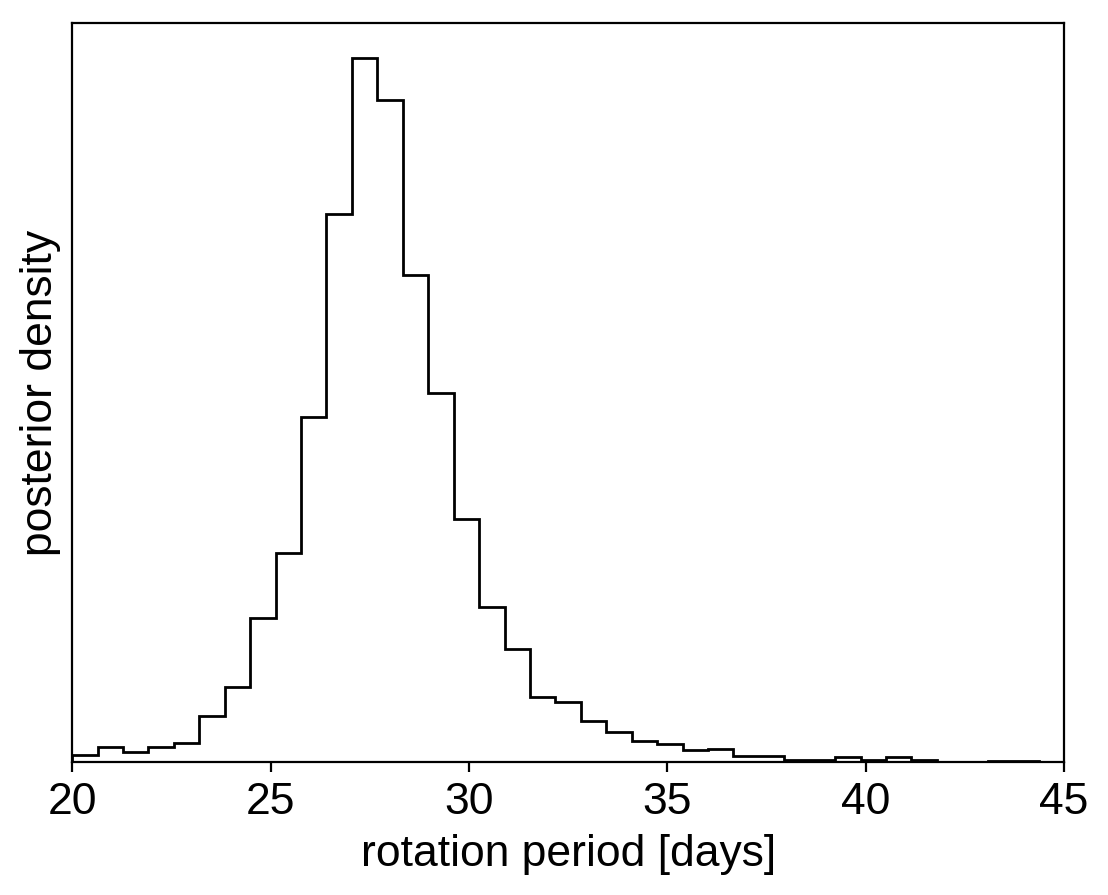

In [9]:
period_samples = trace["period"]
bins = np.linspace(20, 45, 40)
plt.hist(period_samples, bins, histtype="step", color="k")
plt.yticks([])
plt.xlim(bins.min(), bins.max())
plt.xlabel("rotation period [days]")
plt.ylabel("posterior density");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [10]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:exoplanet, exoplanet:foremanmackey17,
exoplanet:foremanmackey18, exoplanet:pymc3, exoplanet:theano}.


In [11]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {dfm/exoplanet v0.2.3},
   month = nov,
    year = 2019,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
